In [10]:
import gym
from collections import deque
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
%matplotlib inline

seed = 0

# Helper Function for Visualization

In [2]:
# Imports specifically so we can render outputs in Jupyter.
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

def display_frames_as_gif(frames):
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=5)
    display(display_animation(anim, default_mode='loop'))

# Helper Function

In [3]:
def run_episode(env, policy, animate=False, evaluation=False): # Run policy and collect (state, action, reward) pairs
    obs = env.reset()
    observes, actions, rewards, infos = [], [], [], []
    done = False
    while not done:
        
        obs = obs.astype(np.float32).reshape((1, -1))
        observes.append(obs)
        
        action = agent.get_action(obs)
        actions.append(action)
        obs, reward, done, info = env.step(action)
        
        if not isinstance(reward, float):
            reward = np.asscalar(reward)
        rewards.append(reward)
        infos.append(info)
        
    return (np.concatenate(observes), np.array(actions), np.array(rewards, dtype=np.float32), infos)

def run_policy(env, agent, episodes): # collect trajectories. if 'evaluation' is ture, then only mean value of policy distribution is used without sampling.
    total_steps = 0
    trajectories = []
    for e in range(episodes):
        observes, actions, rewards, infos = run_episode(env, agent)
        total_steps += observes.shape[0]
        trajectory = {'observes': observes,
                      'actions': actions,
                      'rewards': rewards,
                      'infos': infos}
        trajectories.append(trajectory)
    return trajectories

def build_train_set(trajectories): # prepare data from trajectories
    observes = np.concatenate([t['observes'] for t in trajectories])
    actions = np.concatenate([t['actions'] for t in trajectories])
    returns = np.concatenate([t['returns'] for t in trajectories])
    
    return observes, actions, returns

def compute_returns(trajectories, gamma=0.995):
    for trajectory in trajectories:
        rewards = trajectory['rewards']
        returns = np.zeros_like(rewards)
        g = 0
        for t in reversed(range(len(rewards))):
            g = rewards[t] + gamma*g
            returns[t] = g
        trajectory['returns'] = returns

# Numerical Solver

In [4]:
def conjugate_gradient(f_Ax, b, cg_iters=10, residual_tol=1e-10): # solve Ax = b
    '''
        cg_iters : the number of iteration
        residual_tol : accuracy of solution
    '''
    p = b.copy()
    r = b.copy()
    x = np.zeros_like(b)
    rdotr = r.dot(r)
    for i in range(cg_iters):
        z = f_Ax(p)
        v = rdotr / p.dot(z)
        x += v * p
        r -= v * z
        newrdotr = r.dot(r)
        mu = newrdotr / rdotr
        p = r + mu * p
        rdotr = newrdotr
        if rdotr < residual_tol:
            break
    return x

# TRPOAgent with softmax policy

## KL divergence

### $D_{kl}(\;\pi_{old}(\cdot|s) \;| \;\pi_{new}(\cdot|s)\;)=\sum_{a} \pi_{old}(a|s) \log\left(\frac{\pi_{new}(a|s)}{\pi_{old}(a|s)}\right)$

### $D_{kl}^{max}(\; \pi_{old}\;|\;\pi_{new}\;) = \max_{s} D_{kl}(\;\pi_{old}(\cdot|s)\;|\;\pi_{new}(\cdot|s)\;)$

### Finding maximum KL divergence is intractable in practice

### We approximate max by average

### $D_{kl}^{\rho}(\; \pi_{old}\;|\;\pi_{new}\;) = \sum_{s} \rho_{\pi_{old}}(s)D_{kl}(\;\pi_{old}(\cdot|s)\;|\;\pi_{new}(\cdot|s)\;)$

### We approximate average using MC sampling

### $D_{kl}^{\rho}(\; \pi_{old}\;|\;\pi_{new}\;) \approx \frac{1}{N} \sum_{i} D_{kl}(\;\pi_{old}(\cdot|s_i)\;|\;\pi_{new}(\cdot|s_i)\;)$

In [17]:
class TRPOAgent_softmax(object):
    def __init__(self, obs_dim, n_act,
                 epochs=1, hdim=64,
                 cg_damping=1e-3, max_kl=0.01,
                 seed=0):
        
        self.seed=seed
        
        self.obs_dim = obs_dim
        self.n_act = n_act
        
        self.epochs = epochs
        self.hdim = hdim
        
        self.cg_damping = cg_damping
        self.max_kl = max_kl
        
        self._build_graph()
        
    def _build_graph(self): # define tensorflow graph
        self.g = tf.Graph()
        with self.g.as_default():
            self._placeholders()
            self._policy_nn()
            self._logprob()
            self._loss()
            self._kl_entropy()
            self._trpo_optimizer()
            
            self.init = tf.global_variables_initializer()
            self._init_session()
            
    def _placeholders(self):
        # observations, actions and returns:
        self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs')
        self.act_ph = tf.placeholder(tf.int32, (None, ), 'act')
        self.scores_ph = tf.placeholder(tf.float32, (None,), 'score')

        # learning rate:
        self.lr_ph = tf.placeholder(tf.float32, (), 'lr')
        
        # old parameter
        self.old_logits_ph = tf.placeholder(tf.float32, (None,self.n_act), 'old_logits')

    def _policy_nn(self):
        
        hid1_size = self.hdim
        hid2_size = self.hdim
        
        # TWO HIDDEN LAYERS
        out = tf.layers.dense(self.obs_ph, hid1_size, tf.tanh,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h1")
        out = tf.layers.dense(out, hid2_size, tf.tanh,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h2")
        
        # LOGITS FUNCTION
        self.logits = tf.layers.dense(out, self.n_act,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="logits")
        
        # SOFTMAX POLICY
        self.pi = tf.nn.softmax(self.logits)
        
        # SAMPLE OPERATION
        categorical = tf.contrib.distributions.Categorical(logits=self.logits)
        self.sample_action = categorical.sample(1,seed=self.seed)
        
    def _logprob(self):
        # Action Index -> One Hot Vector
        one_hot_act = tf.one_hot(self.act_ph,self.n_act)
        
        # PROBABILITY WITH TRAINING PARAMETER  
        self.log_p = -tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_act,logits=self.logits)
        
        # PROBABILITY WITH OLD PARAMETER  
        self.log_p_old = -tf.nn.softmax_cross_entropy_with_logits_v2(labels=one_hot_act,logits=self.old_logits_ph)
        
    def _loss(self):
        
        # TRPO Loss
        ratio = tf.exp(self.log_p - self.log_p_old) # Importance Weight
        self.loss = -tf.reduce_mean(self.scores_ph*ratio)
        
    def _kl_entropy(self):

        pi = self.pi
        pi_old = tf.nn.softmax(self.old_logits_ph)
                
        # KL DIVERGENCE BETWEEN TWO CATEGORICAL
        kl = tf.reduce_sum(pi_old*(tf.log(pi_old)-tf.log(pi)),axis=1)
        self.kl = tf.reduce_mean(kl)
        
        # ENTROPY OF CATEGORICAL
        entropy = -tf.reduce_sum(pi*tf.log(pi),axis=1) # sum -p*log(p)
        self.entropy = tf.reduce_mean(entropy) # average over Batch
         
    def _trpo_optimizer(self):
        var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        
        # FLATTEN VARIABLE
        self.flat_var = tf.concat([tf.reshape(v, [np.prod(v.shape)]) for v in var_list], 0)
        
        # GRADIENT OF LOSS
        pg_grads = tf.gradients(self.loss, var_list)
        self.pg = tf.concat([tf.reshape(pg_grad, [np.prod(v.shape)]) for (v, pg_grad) in zip(var_list, pg_grads)], 0)
        
        # GRADIENT OF KL DIVERGENCE
        grads = tf.gradients(self.kl, var_list)
        
        self.flat_tangent = tf.placeholder(tf.float32, shape=(None))
        
        shapes = [v.shape for v in var_list]
        start = 0
        tangents = []
        for shape in shapes:
            size = int(np.prod(shape))
            param = tf.reshape(self.flat_tangent[start:(start + size)], shape)
            tangents.append(param)
            start += size
        
        # PRODUCT BETWEEN THE GRADIENT OF KL AND A VECTOR, G * V
        gvp = [tf.reduce_sum(g * t) for (g, t) in zip(grads, tangents)]
        
        # GRADIENT OF GRADIENT VECTOR PRODUCT
        gvp_grads = tf.gradients(gvp, var_list)
        self.fvp =  tf.concat([tf.reshape(gvp_grad, [np.prod(v.shape)]) for (v, gvp_grad) in zip(var_list, gvp_grads)], 0)
        
        # UPDATE OPERATION
        assigns = []
        total_size = sum(int(np.prod(shape)) for shape in shapes)
        self.theta = tf.placeholder(tf.float32, shape=(total_size))
        start = 0
        for (shape, v) in zip(shapes, var_list):
            size = int(np.prod(shape))
            assigns.append(v.assign(tf.reshape(self.theta[start:start+size],shape)))
            start += size
        self.set_from_flat = assigns
        
    def _init_session(self):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config,graph=self.g)
        self.sess.run(self.init)

    def get_action(self, obs): # SAMPLE FROM POLICY
        feed_dict = {self.obs_ph: obs}
        sampled_action, = self.sess.run(self.sample_action,feed_dict=feed_dict)
        return sampled_action[0]
    
    def control(self, obs): # COMPUTE MEAN
        feed_dict = {self.obs_ph: obs}
        best_action = np.argmax(self.sess.run(self.pi,feed_dict=feed_dict))
        return best_action        
    
    def update(self, observes, actions, scores): # TRAIN POLICY

        old_logits = self.sess.run(self.logits,{self.obs_ph: observes}) # COMPUTE OLD LOGITS
        feed_dict = {self.obs_ph: observes,
                     self.act_ph: actions,
                     self.scores_ph: scores,
                     self.old_logits_ph: old_logits}  
        
        thprev = self.sess.run(self.flat_var) # GET CURRENT NETWORK PARAMETERS

        def hessian_vector_product(p): # HESSIAN VECTOR PRODUCT, Hx
            feed_dict[self.flat_tangent] = p
            return self.sess.run(self.fvp, feed_dict) + p * self.cg_damping

        g = self.sess.run(self.pg, feed_dict=feed_dict) # GET GRADIENT, g = d loss/ d theta
        stepdir = conjugate_gradient(hessian_vector_product, -g) # CONJUGATE GRADIENT H^{-1} g
        
        shs = (.5 * stepdir.dot(hessian_vector_product(stepdir)) ) # NORM of GRADIENT

        lm = np.sqrt(shs / self.max_kl) # SCALE OF GRADIENT

        fullstep = stepdir / lm # NORMALIZATION
        
        expectedimprove = g.dot(fullstep) # EXPECTED IMPROVEMENT

        surrbefore = self.sess.run(self.loss, feed_dict=feed_dict)
        
        # LINESEARCH
        stepsize = 1.
        for _ in range(5):
            thnew = thprev + fullstep * stepsize
            self.sess.run(self.set_from_flat, feed_dict={self.theta:thnew})

            surr, kl = self.sess.run([self.loss, self.kl], feed_dict=feed_dict)
            improve = surr - surrbefore
            
            if not np.isfinite(surr).all(): # SOMETHINGS WRONG
                self.sess.run(self.set_from_flat, feed_dict={self.theta:thprev})
                break
            elif kl > self.max_kl * 1.5: # VIOLATE KL DIVERGENCE CONSTRAINT
                stepsize *= .5
            elif improve < 0: # PERFORMANCE DROP
                stepsize *= .5
            else:
                break
                
        loss, kl, entropy  = self.sess.run([self.loss, self.kl, self.entropy], feed_dict)
        return loss, kl, entropy 
    
    def close_sess(self):
        self.sess.close()

# Training

In [18]:
env = gym.make('CartPole-v1')

np.random.seed(seed)
tf.set_random_seed(seed)
env.seed(seed=seed)

obs_dim = env.observation_space.shape[0]
n_act = env.action_space.n

agent = TRPOAgent_softmax(obs_dim, n_act, cg_damping=1e-2, max_kl=0.1, hdim=32,seed=seed)

avg_return_list = deque(maxlen=10)
avg_loss_list = deque(maxlen=10)

episode_size = 5
nupdates = 200

for update in range(nupdates+1):

    trajectories = run_policy(env, agent, episodes=episode_size)
    compute_returns(trajectories)
    observes, actions, returns = build_train_set(trajectories)
    
    nz_returns = (returns - np.mean(returns))/np.std(returns) # magic!! # local update
    
    pol_loss, kl, entropy = agent.update(observes, actions, nz_returns)

    avg_loss_list.append(pol_loss)
    avg_return_list.append([np.sum(t['rewards']) for t in trajectories])
    if (update%20) == 0:
        print('[{}/{}] return : {:.3f},  policy loss : {:.3f}, policy kl : {:.5f}, policy entropy : {:.3f}'.format(
            update, nupdates, np.mean(avg_return_list), np.mean(avg_loss_list), kl, entropy))
        
    if (np.mean(avg_return_list) > 495): # Threshold return to success cartpole
        print('[{}/{}] return : {:.3f}, policy loss : {:.3f}'.format(update,nupdates, np.mean(avg_return_list), np.mean(avg_loss_list)))
        print('The problem is solved with {} episodes'.format(update*episode_size))
        break

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
[0/200] return : 23.800,  policy loss : -0.003, policy kl : 0.00038, policy entropy : 0.693
[20/200] return : 44.340,  policy loss : -0.005, policy kl : 0.00034, policy entropy : 0.656
[40/200] return : 186.800,  policy loss : -0.003, policy kl : 0.00027, policy entropy : 0.591
[60/200] return : 370.460,  policy loss : -0.002, policy kl : 0.00036, policy entropy : 0.582
[73/200] return : 497.960, policy loss : -0.001
The problem is solved with 365 episodes


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Total Reward : 500.00



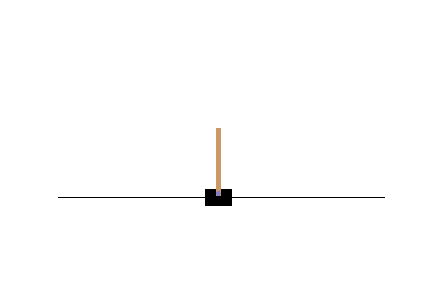
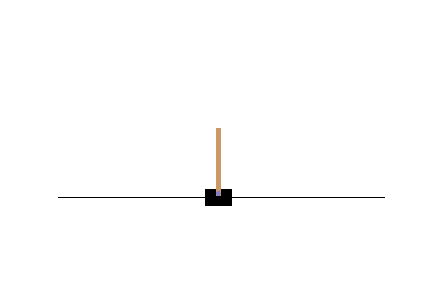
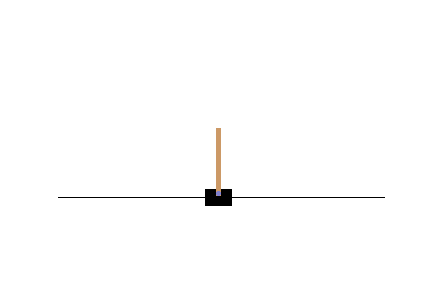
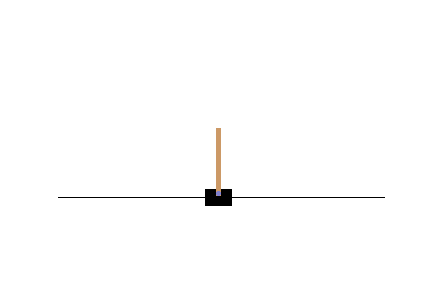
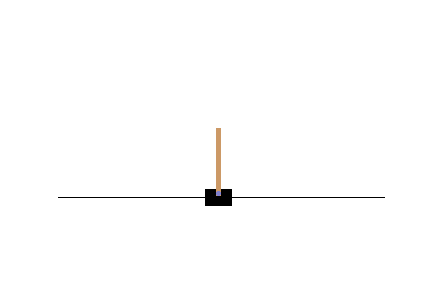
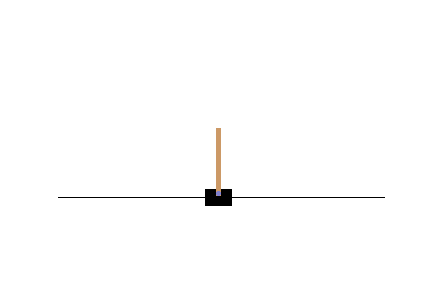
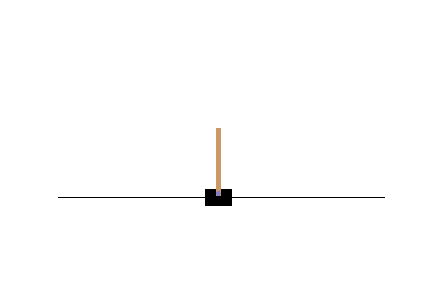
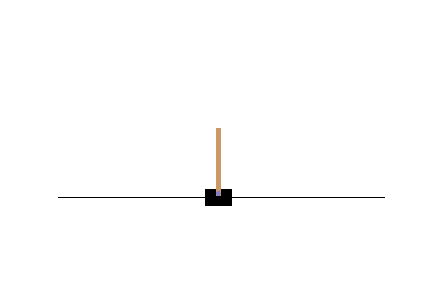
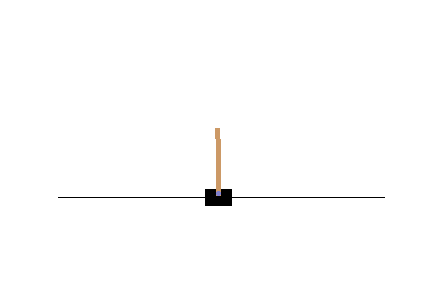
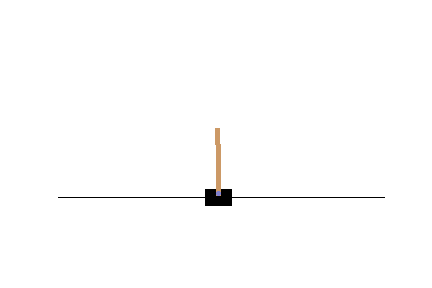
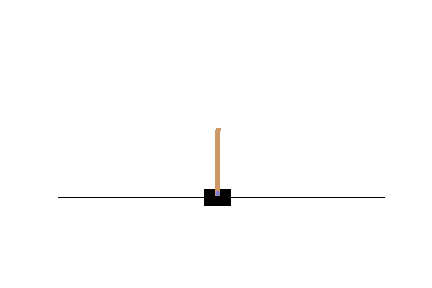
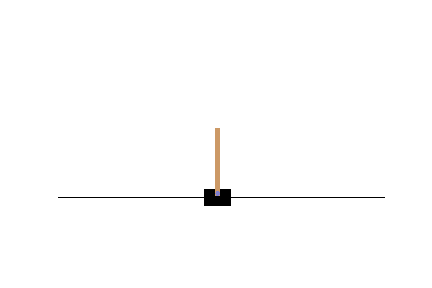
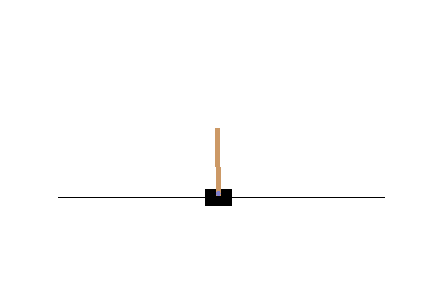
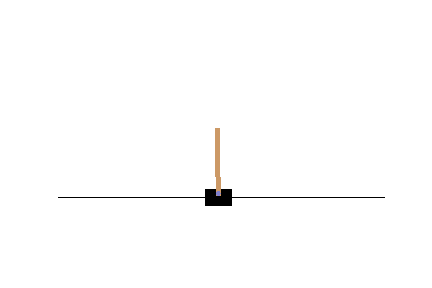
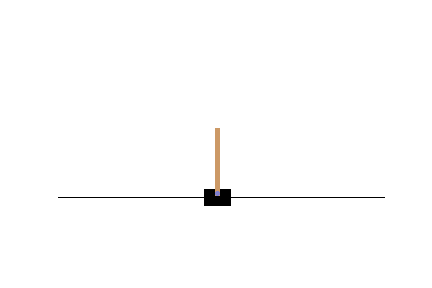
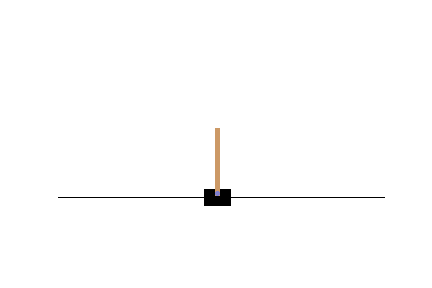
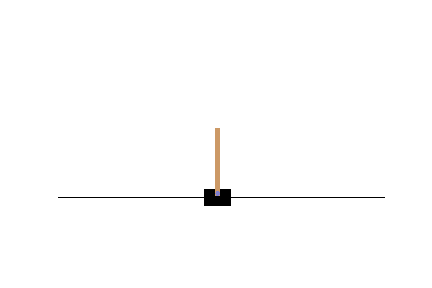
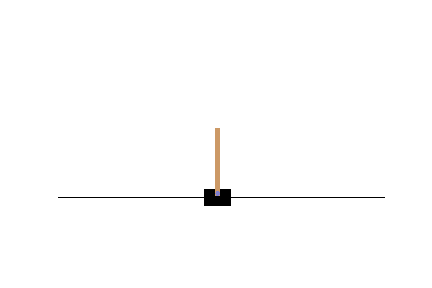
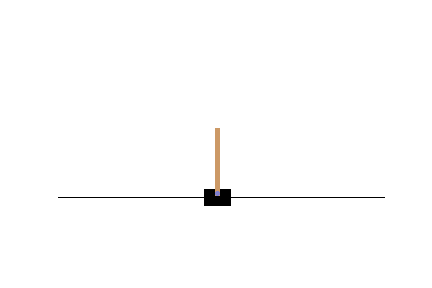
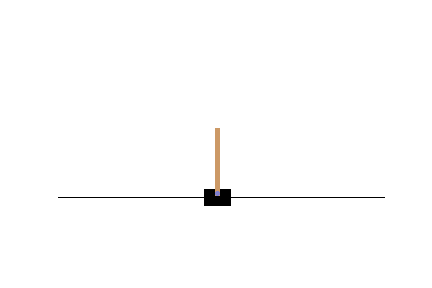
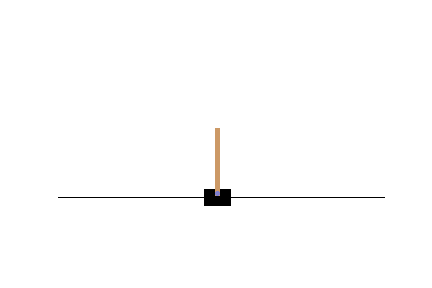
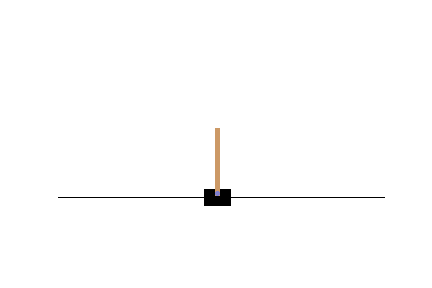
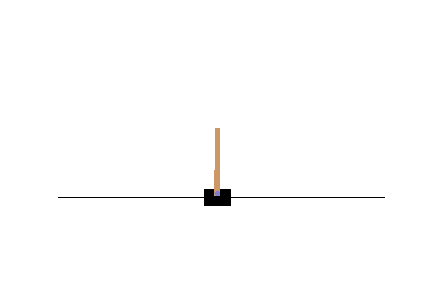
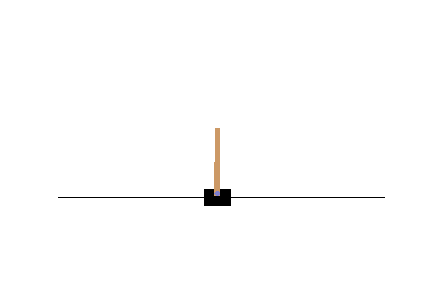
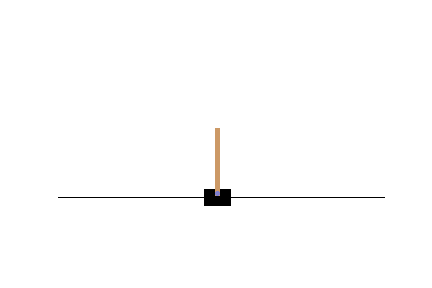
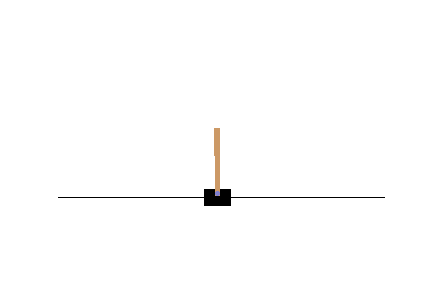
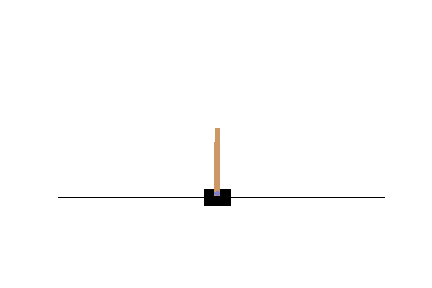
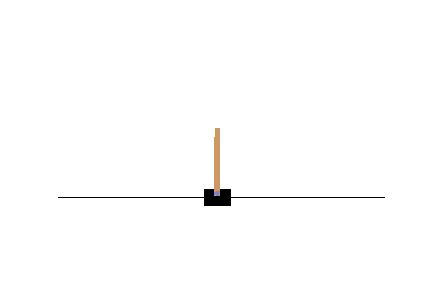
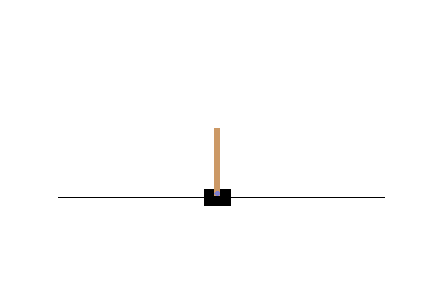
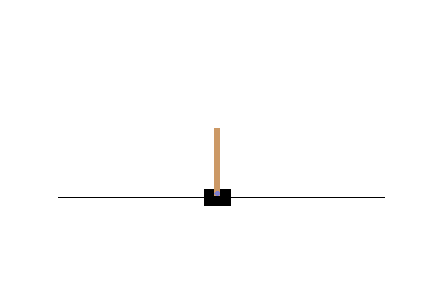
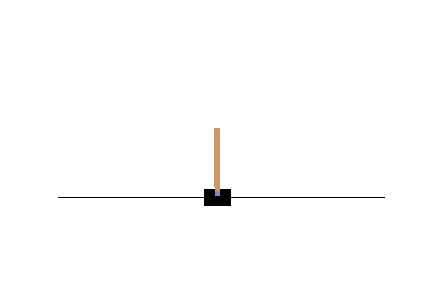
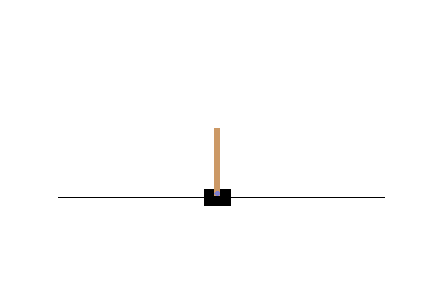
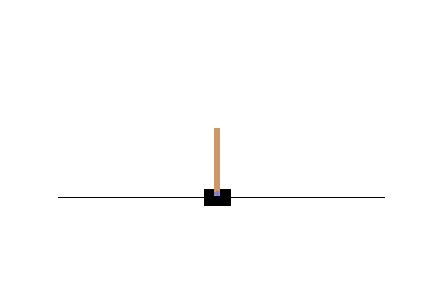
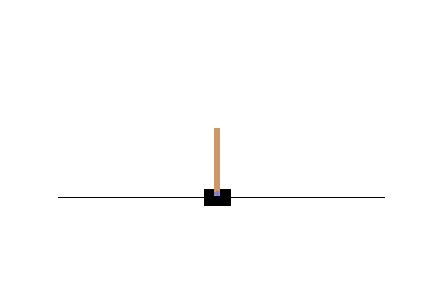
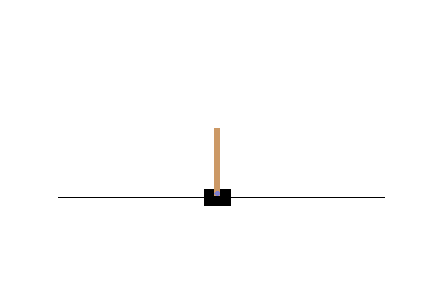
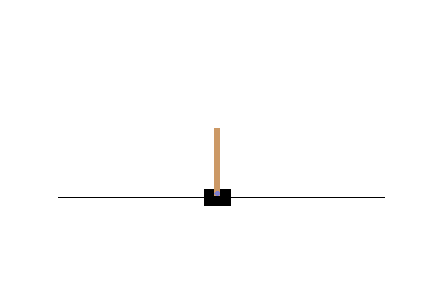
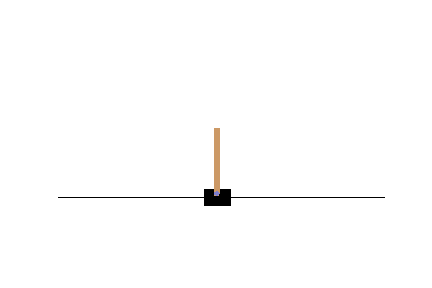
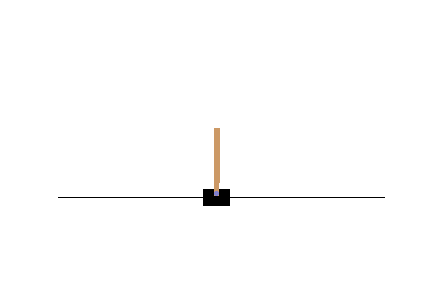
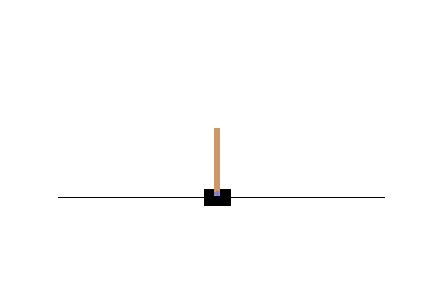
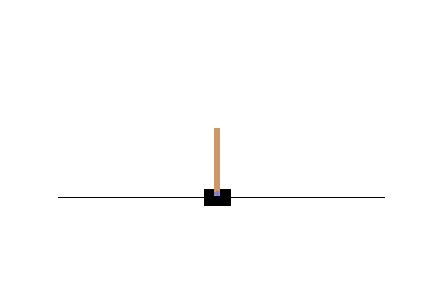
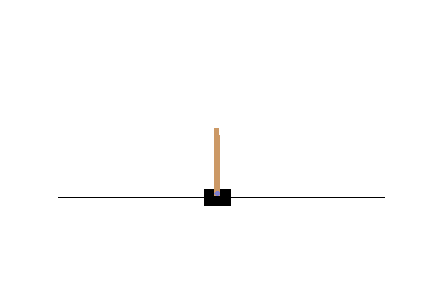
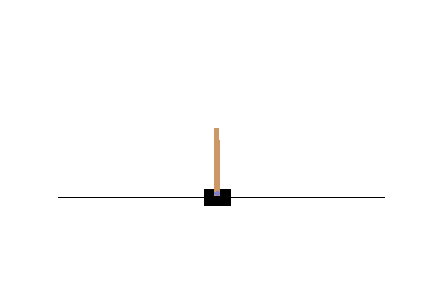
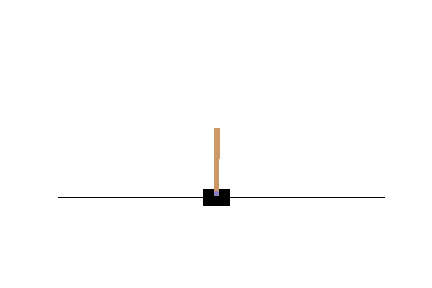
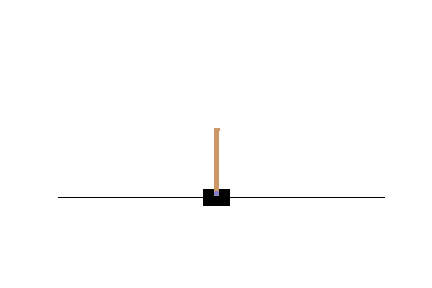
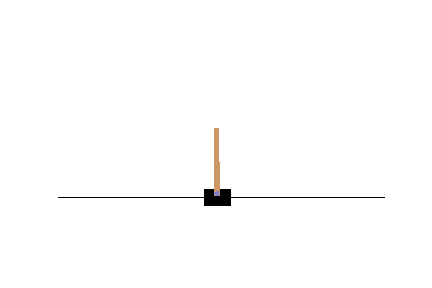
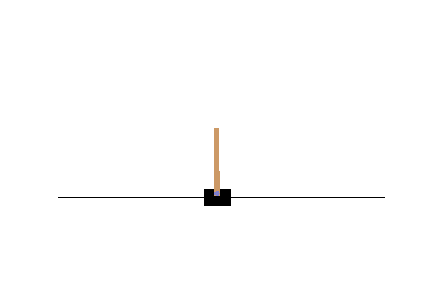
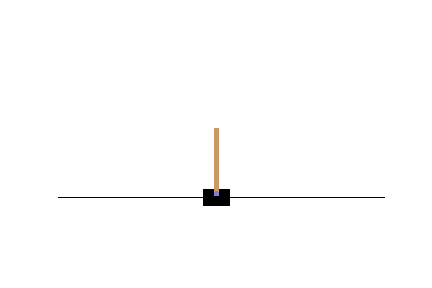
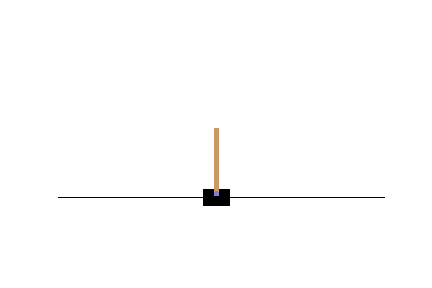
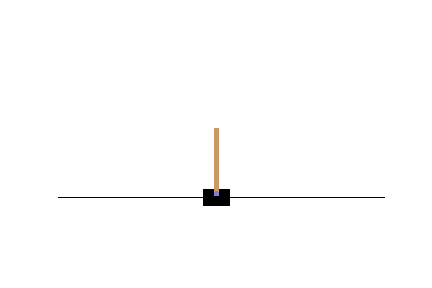
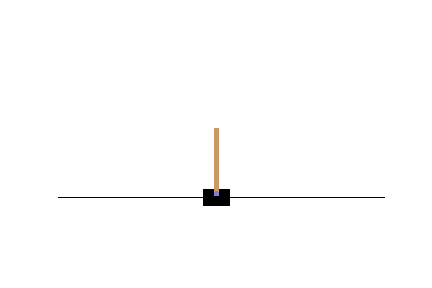
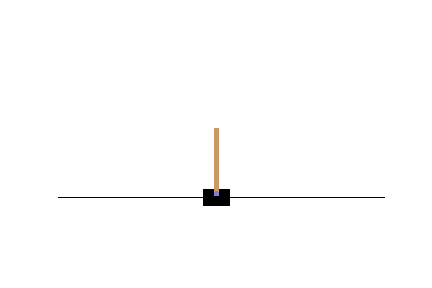
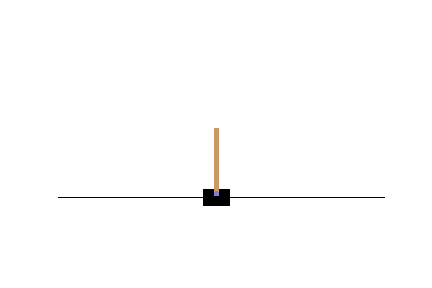
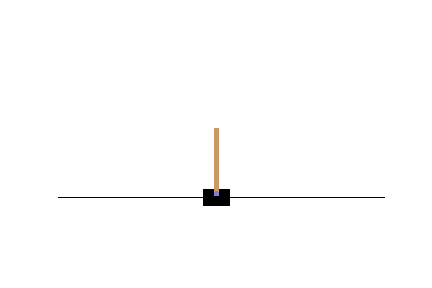
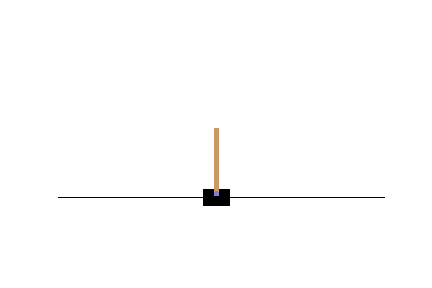
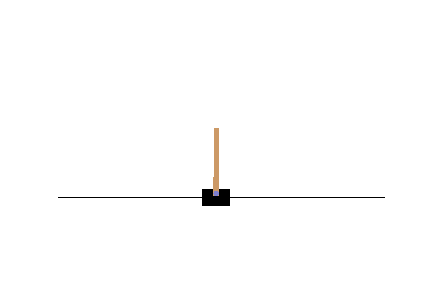
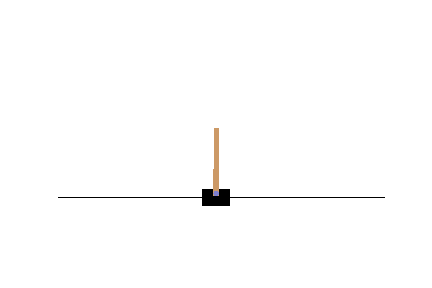
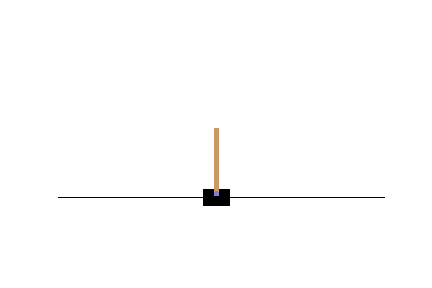
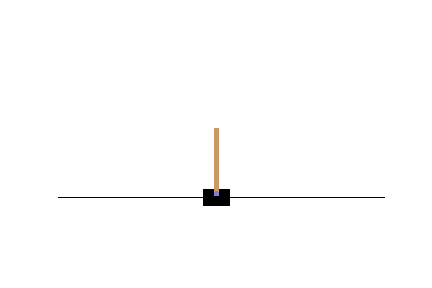
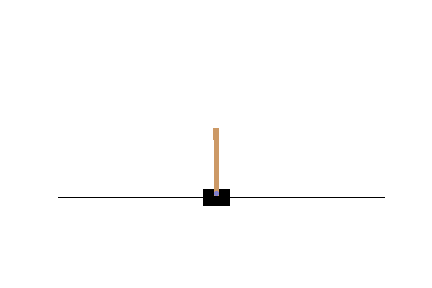
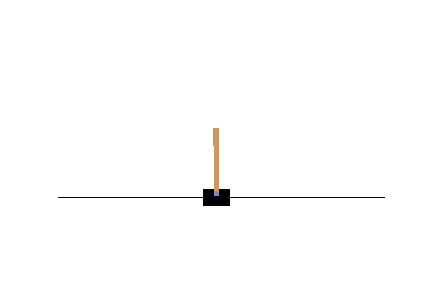
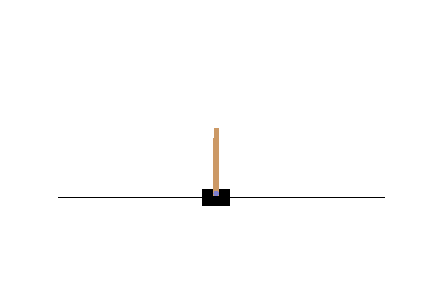
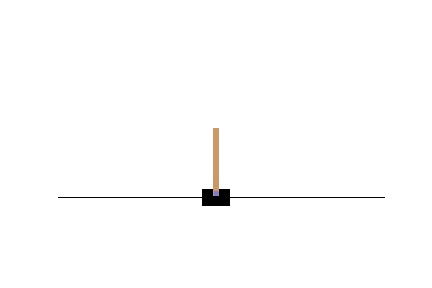
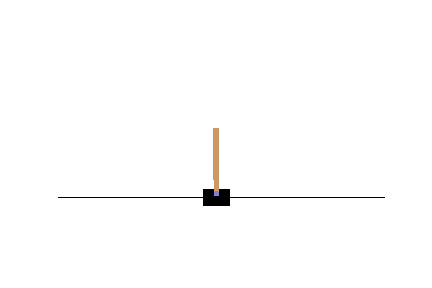
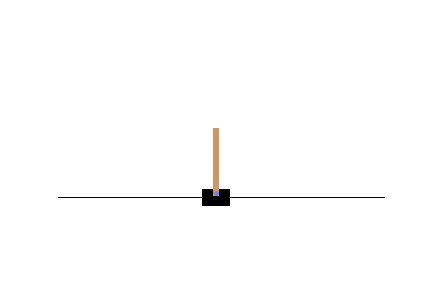
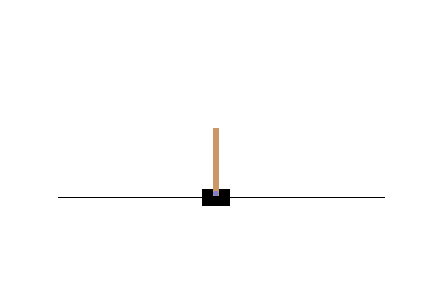
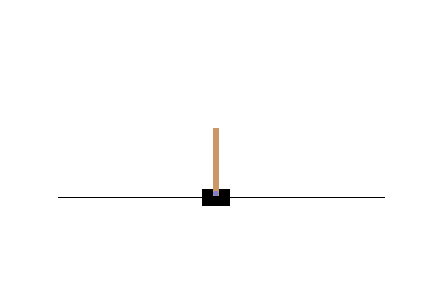
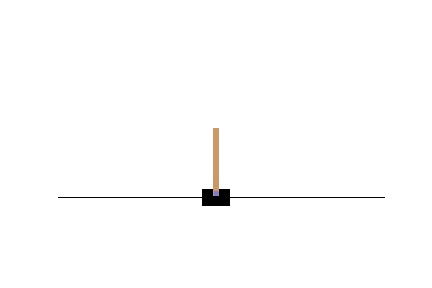
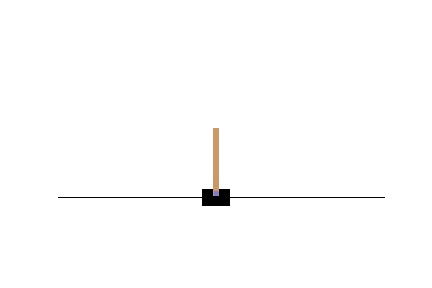
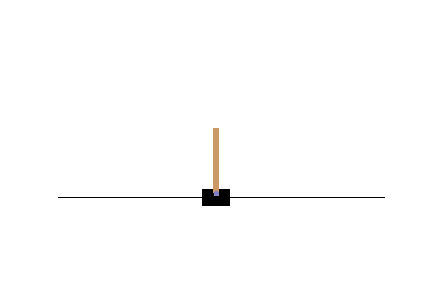
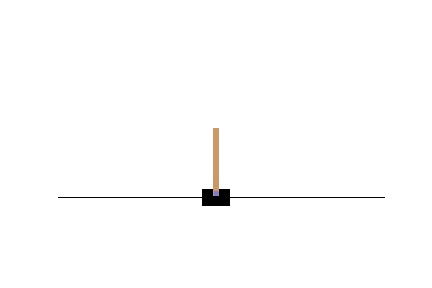
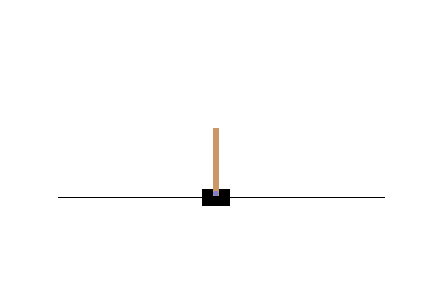
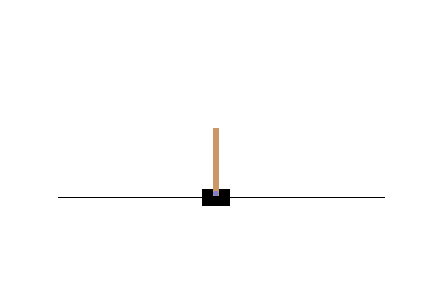
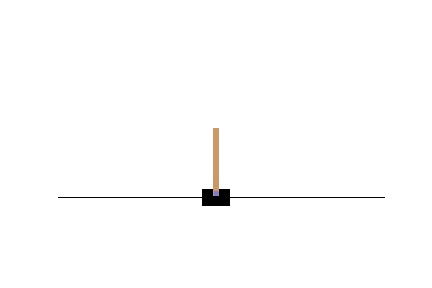
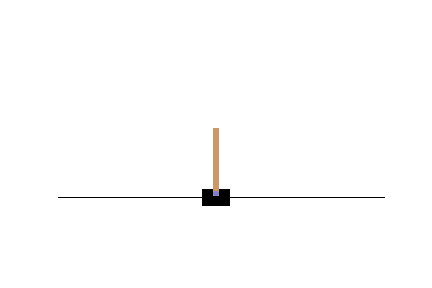
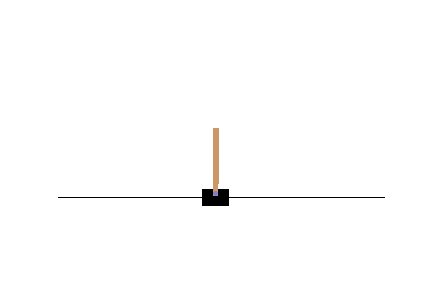
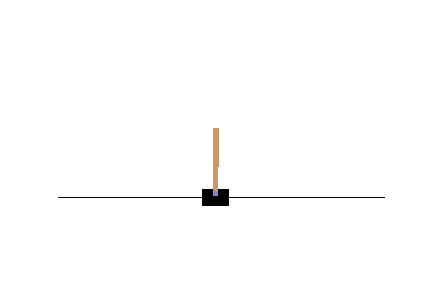
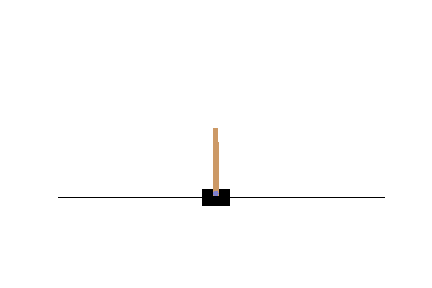
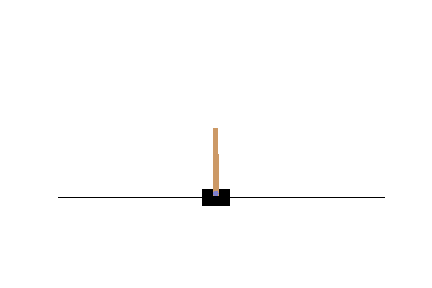
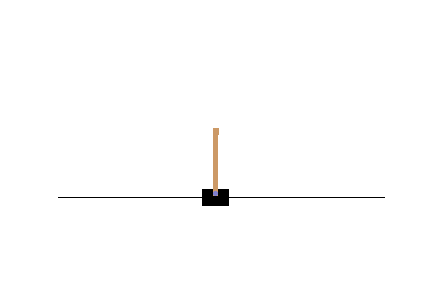
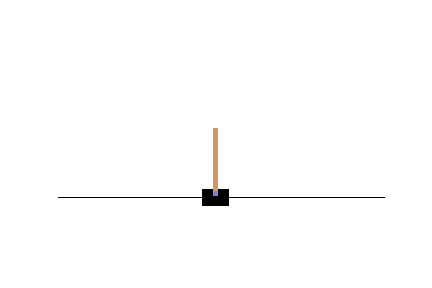
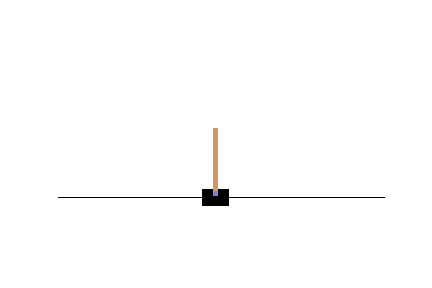
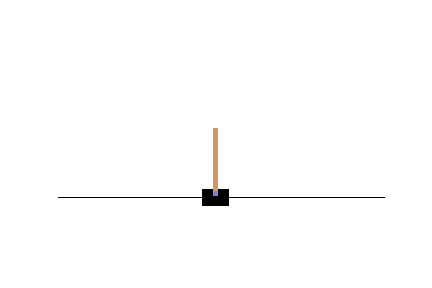
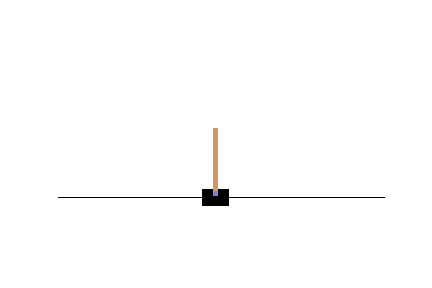
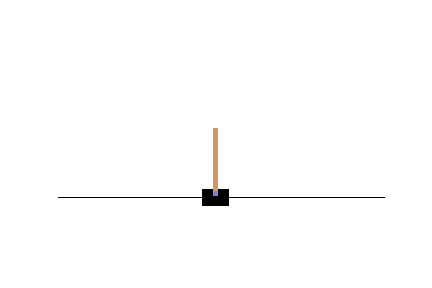
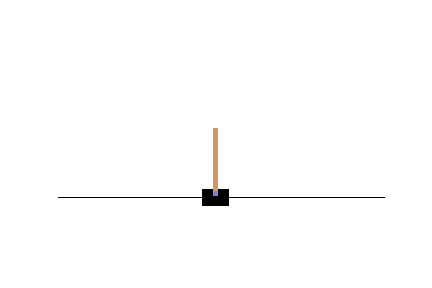
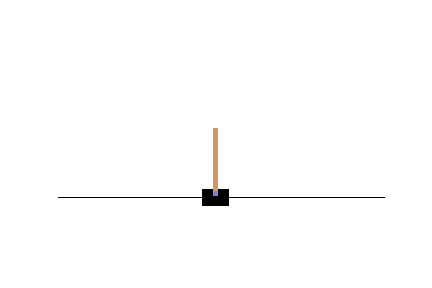
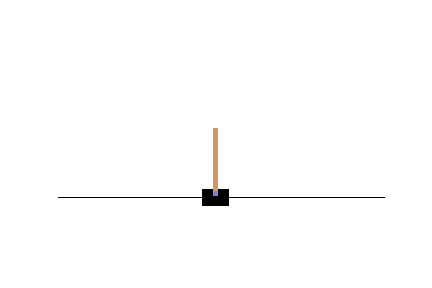
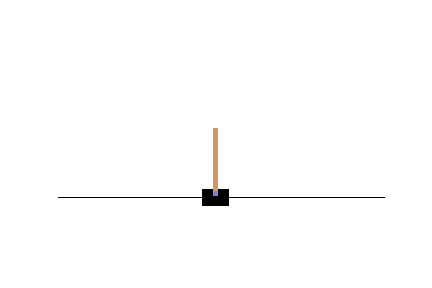
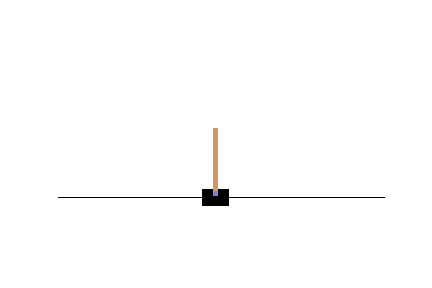
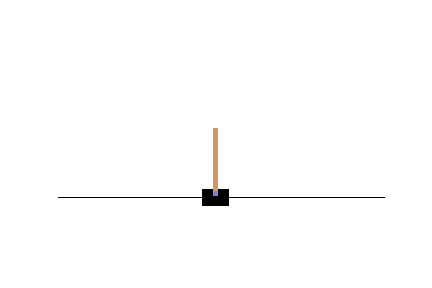
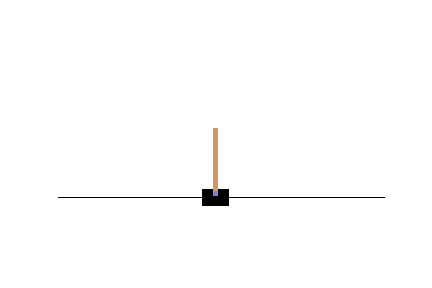
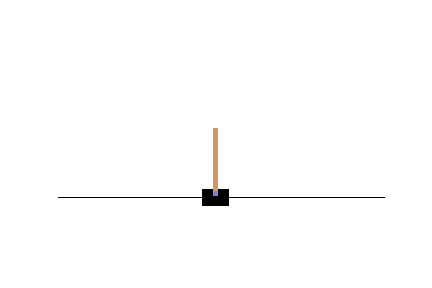
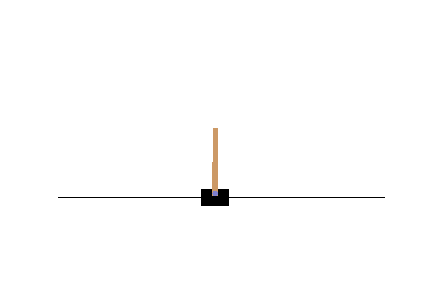
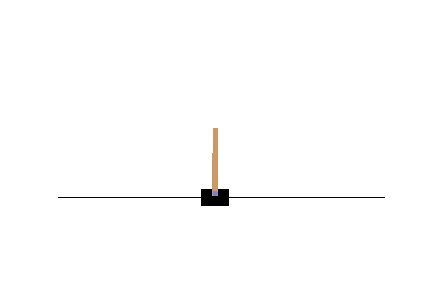
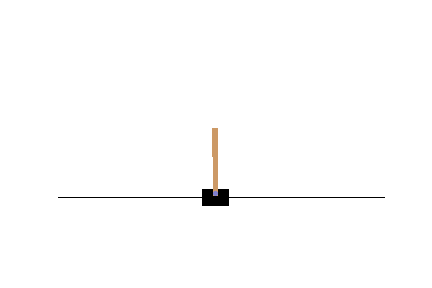
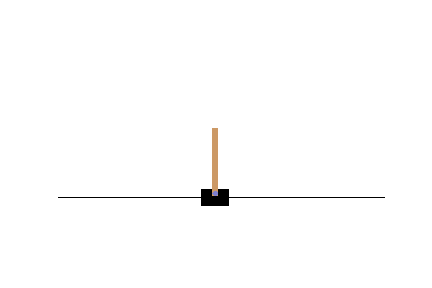
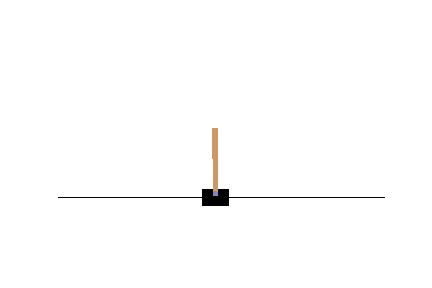
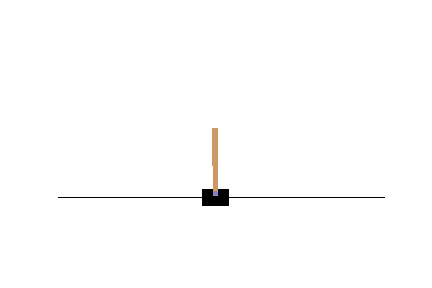
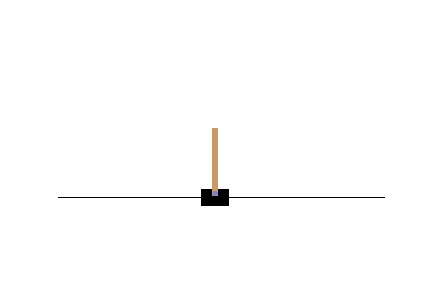
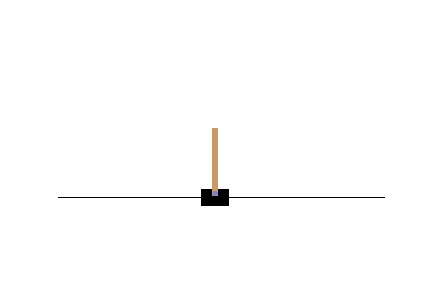
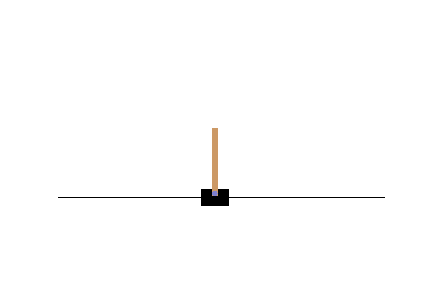
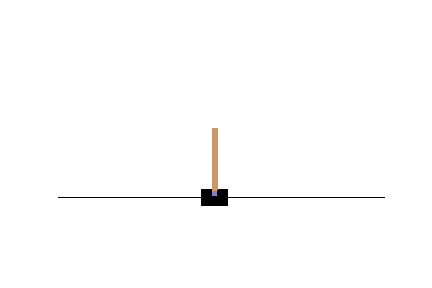
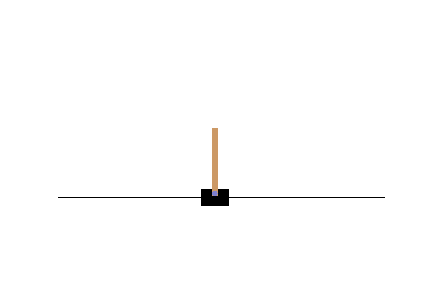
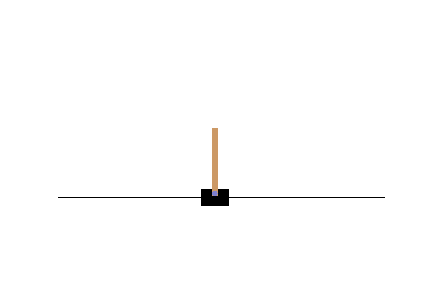
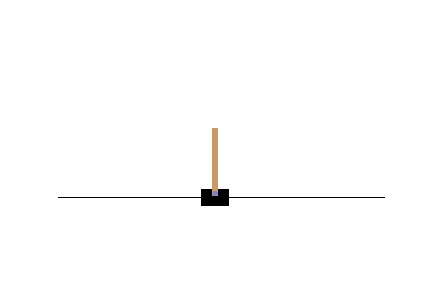
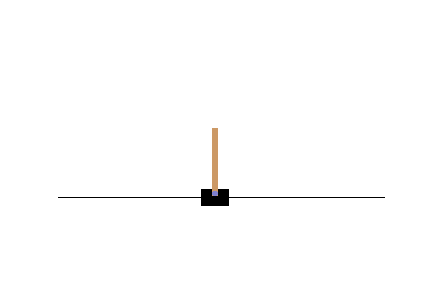
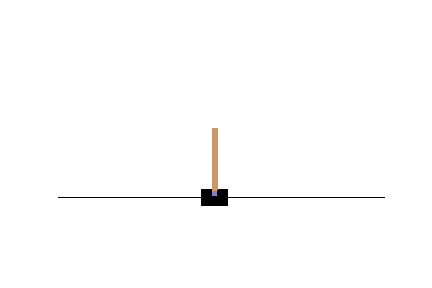
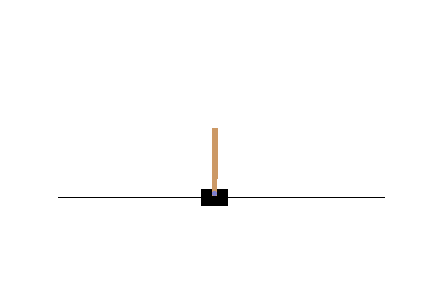
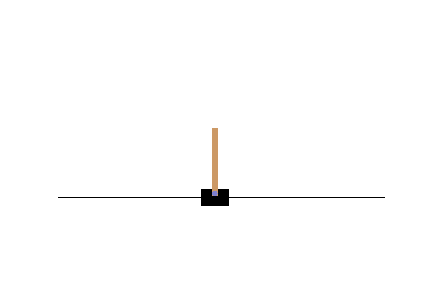
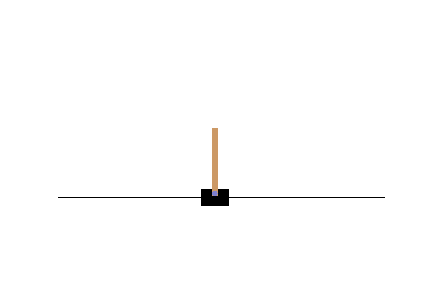
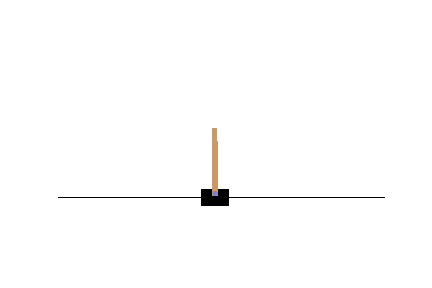
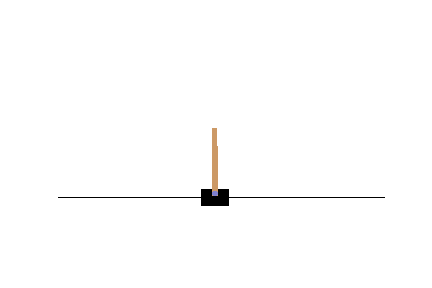
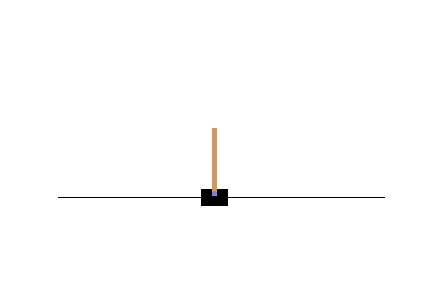
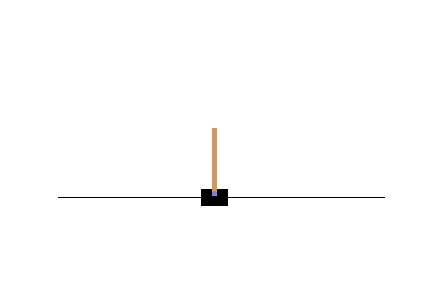
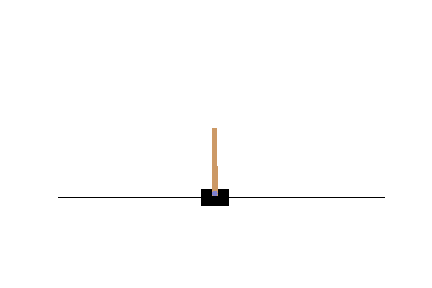
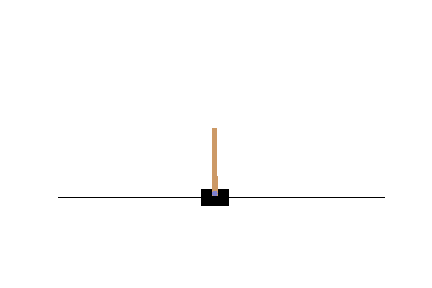
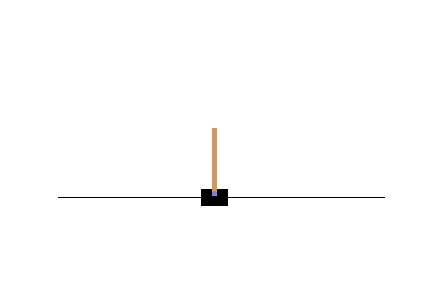
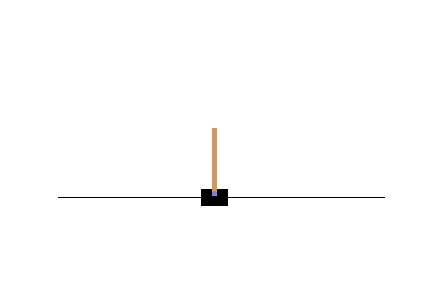
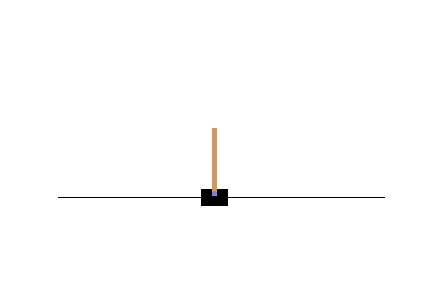
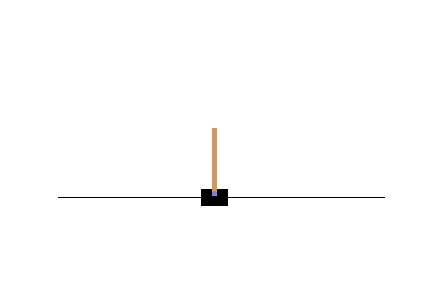
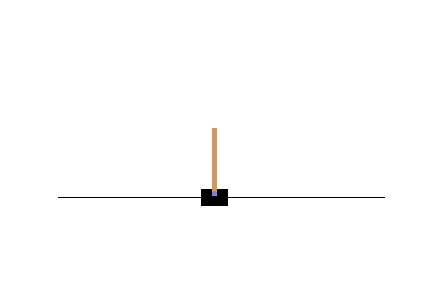
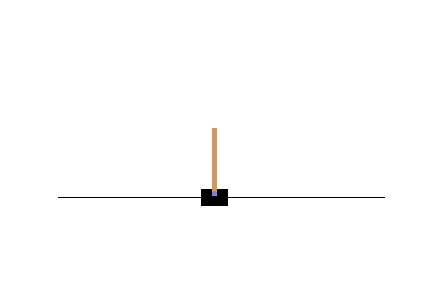
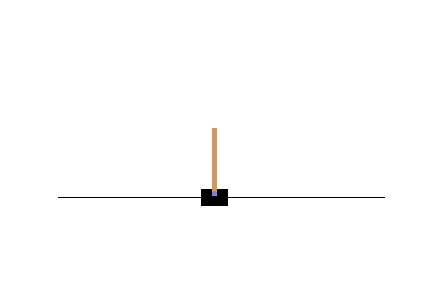
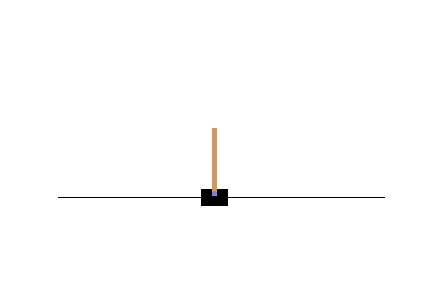
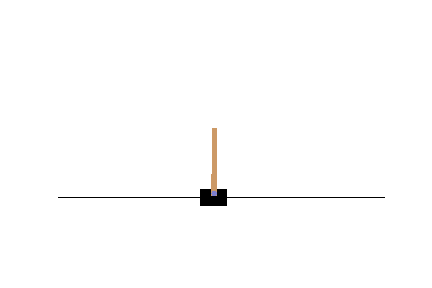
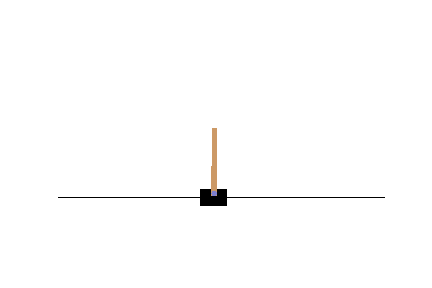
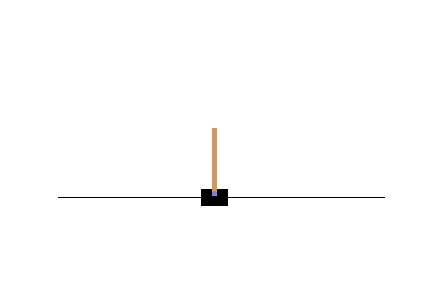
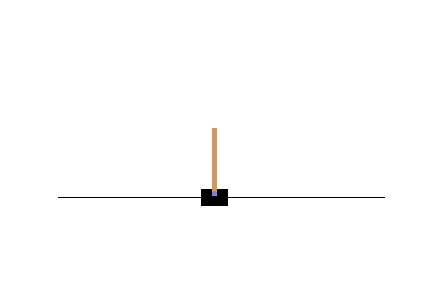
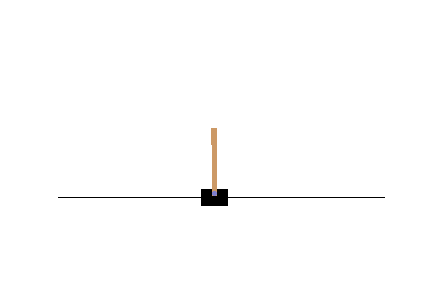
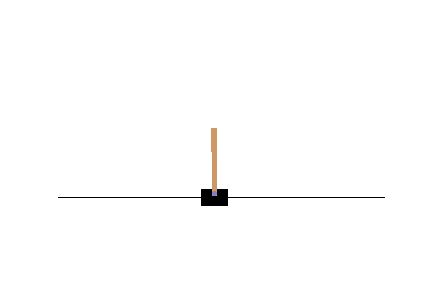
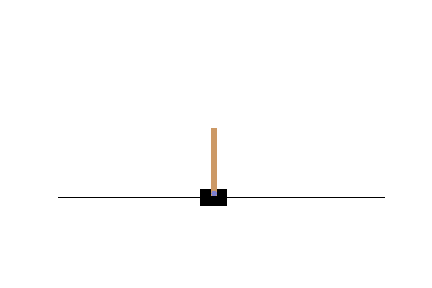
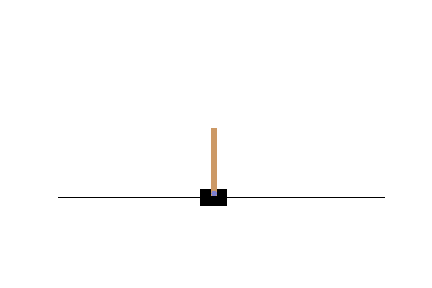
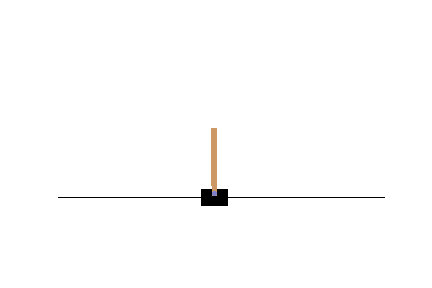
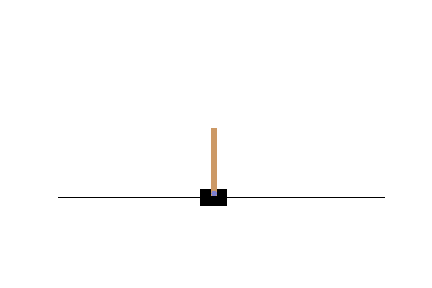
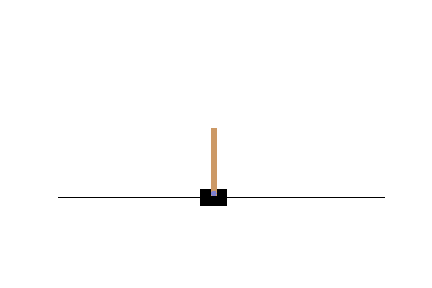
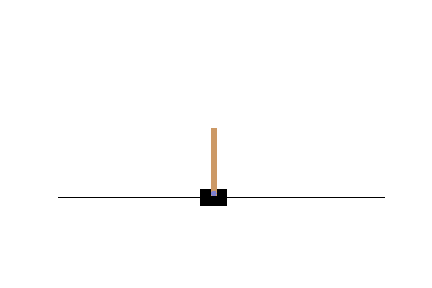
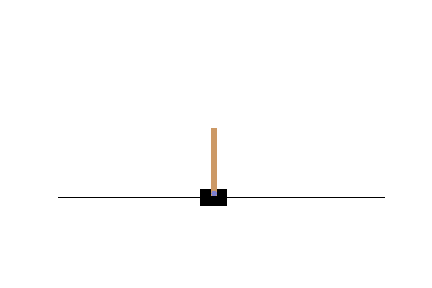
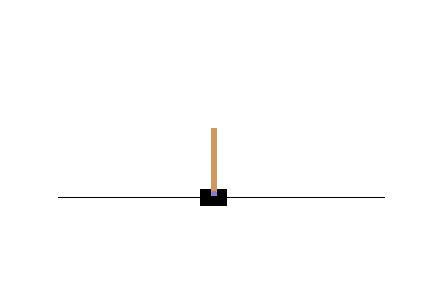
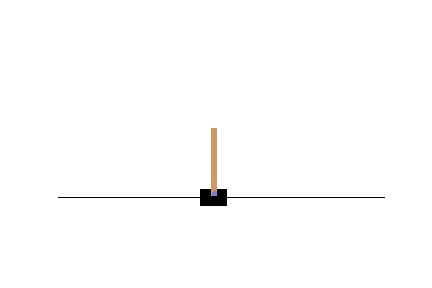
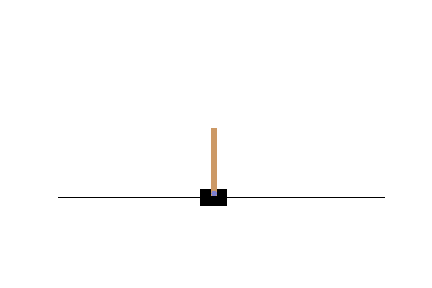
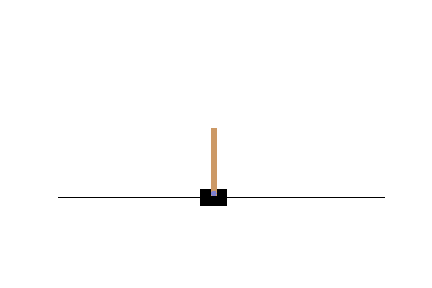
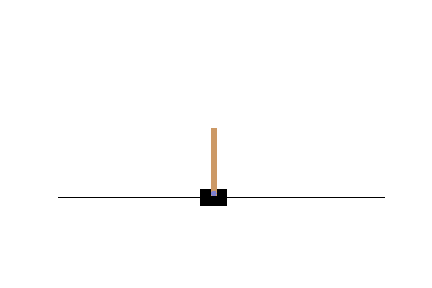
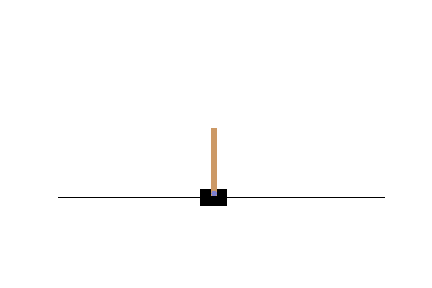
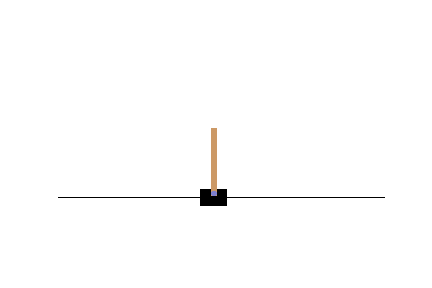
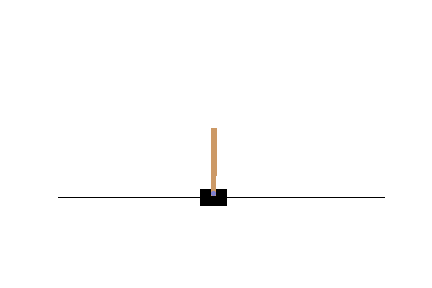
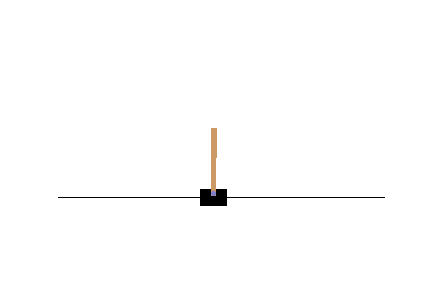
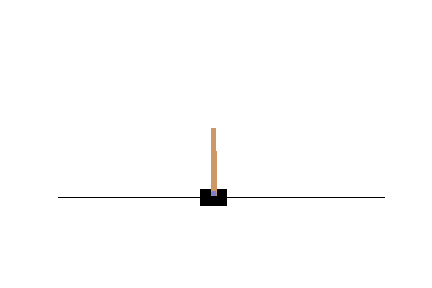
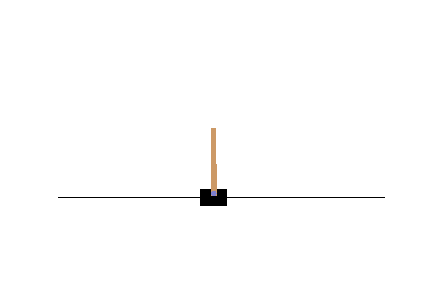
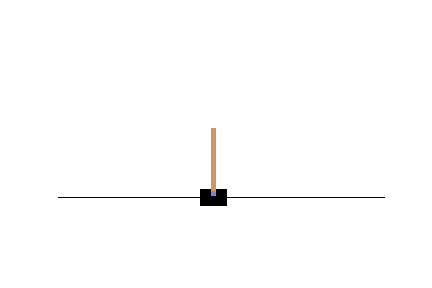
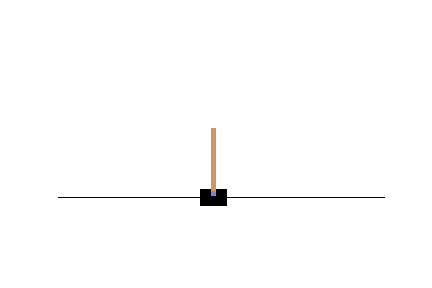
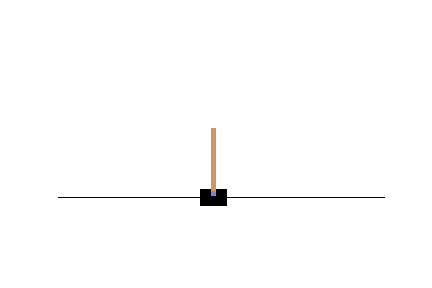
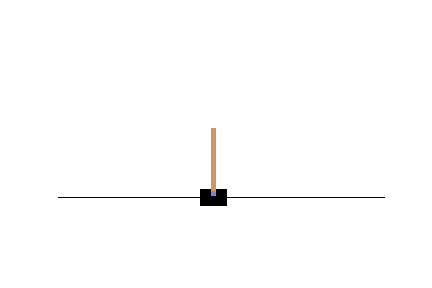
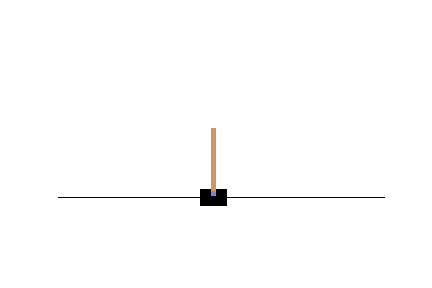
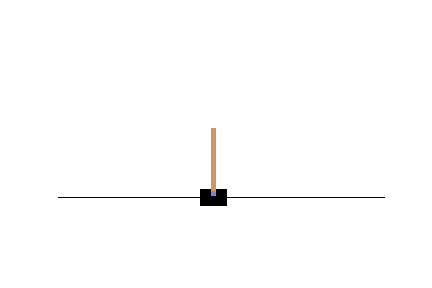
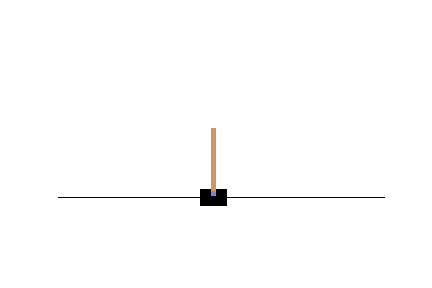
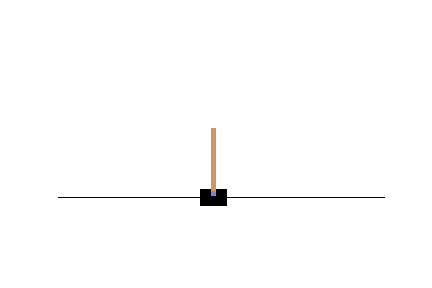
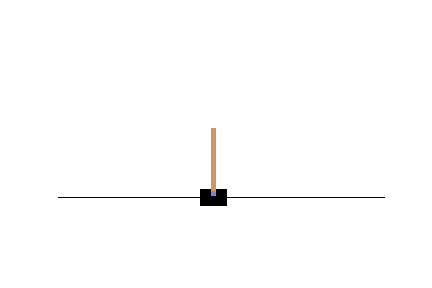
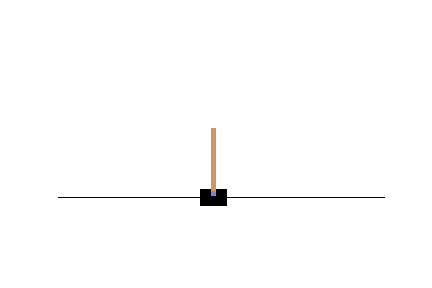
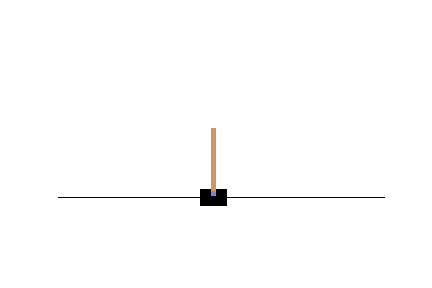
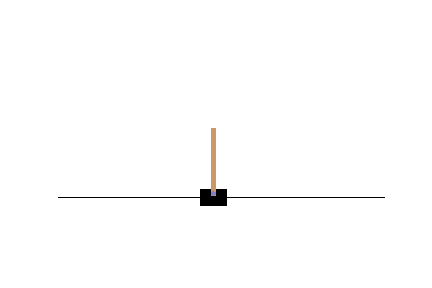
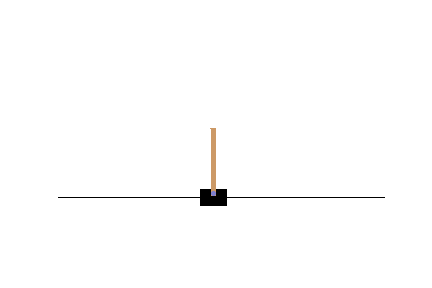
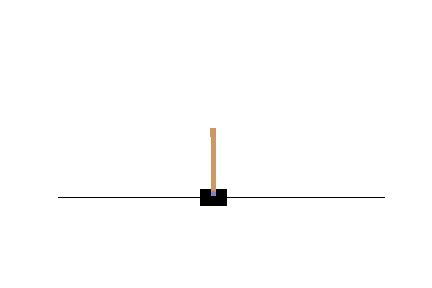
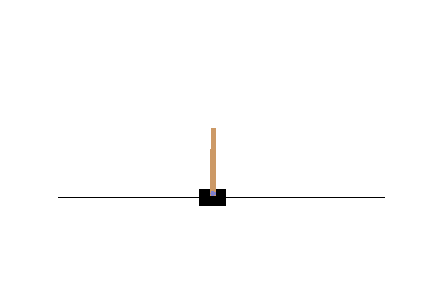
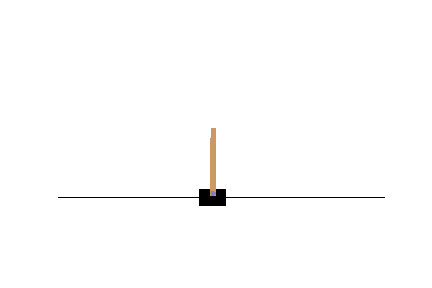
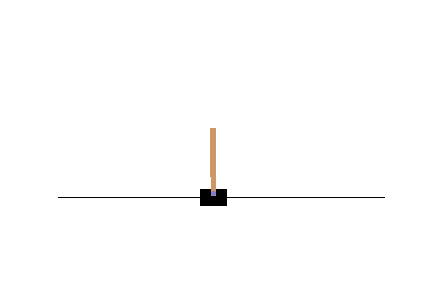
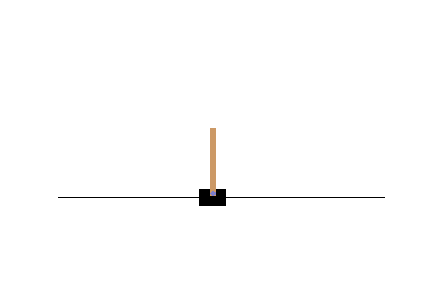
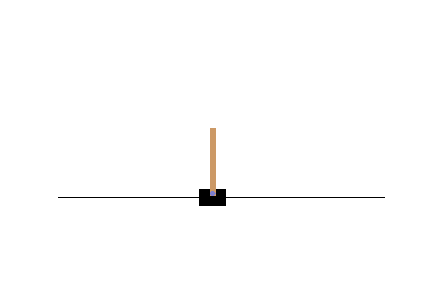
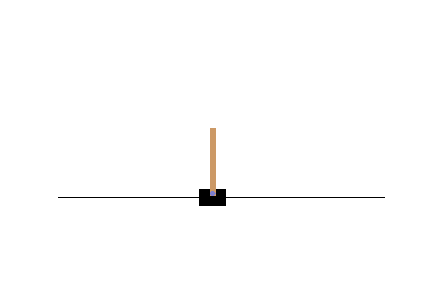
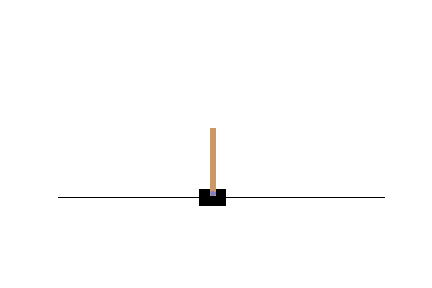
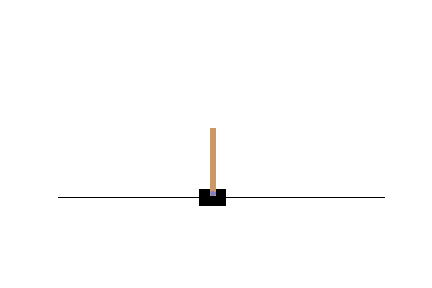
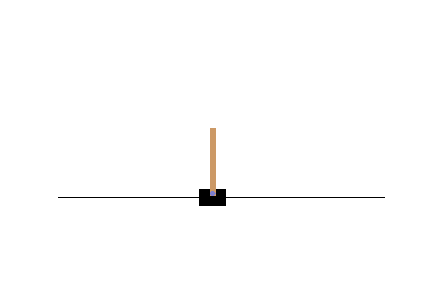
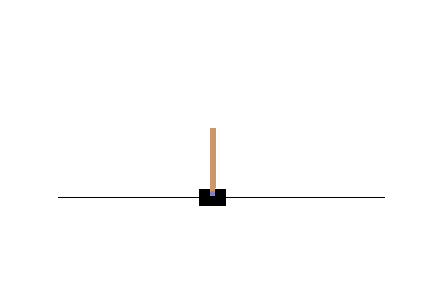
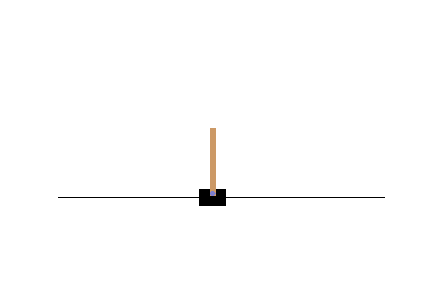
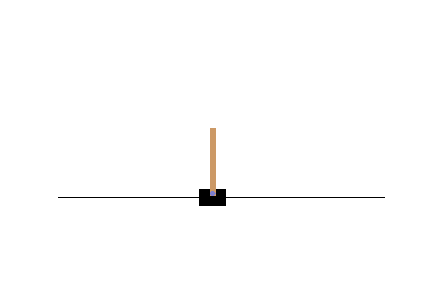
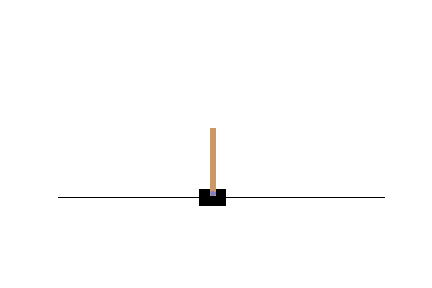
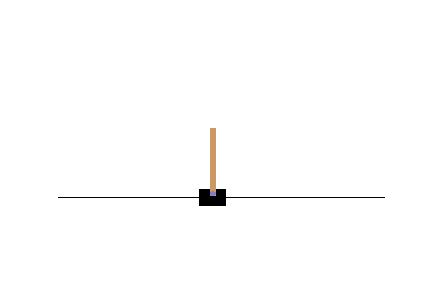
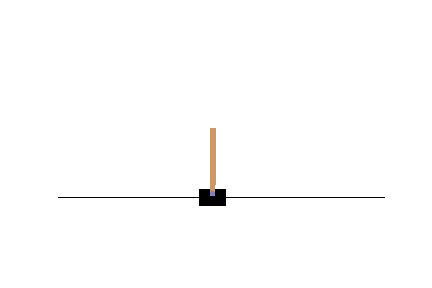
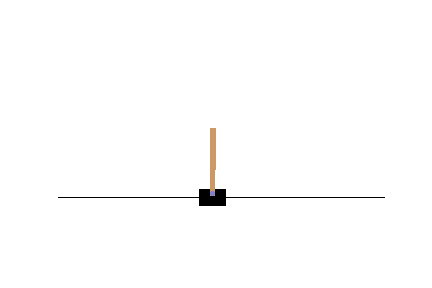
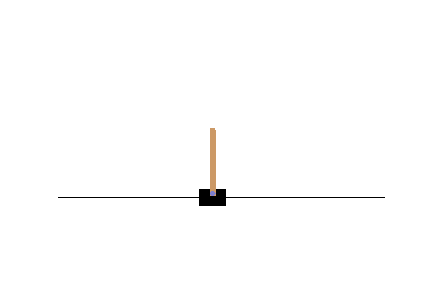
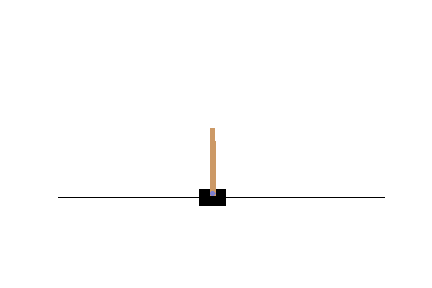
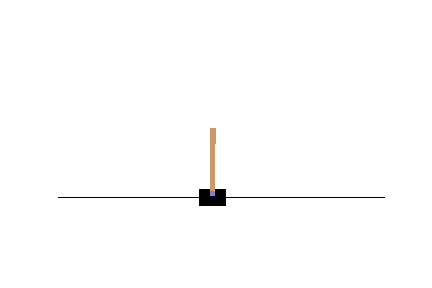
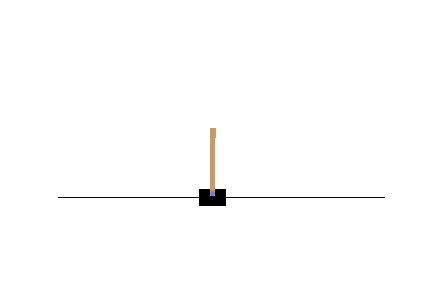
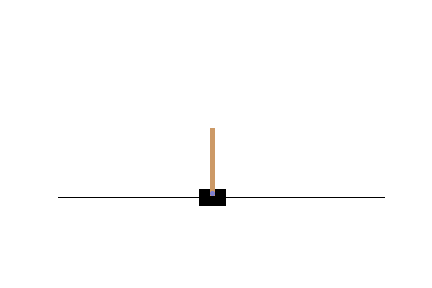
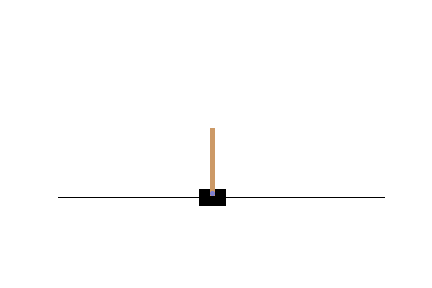
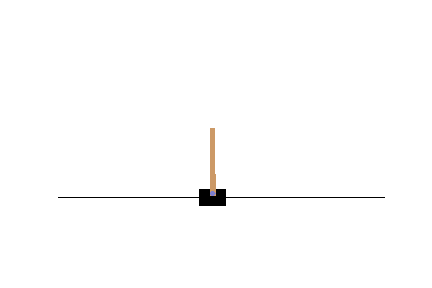
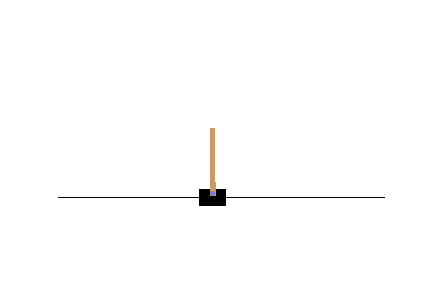
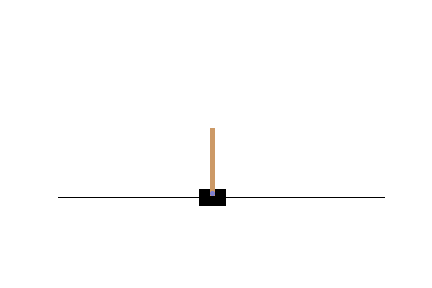
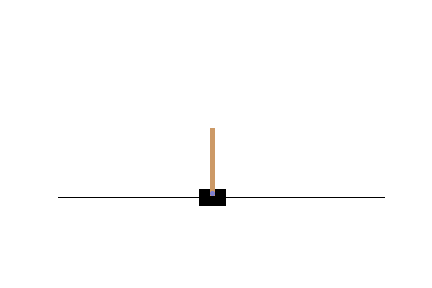
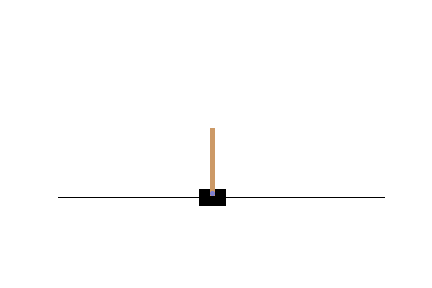
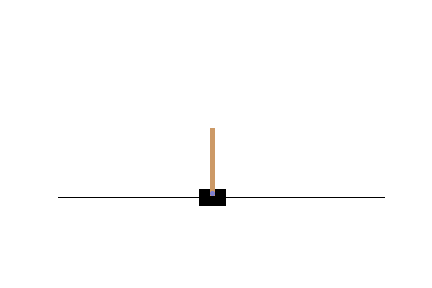
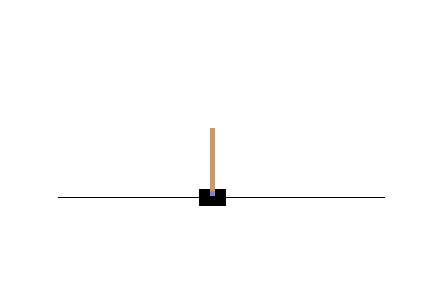
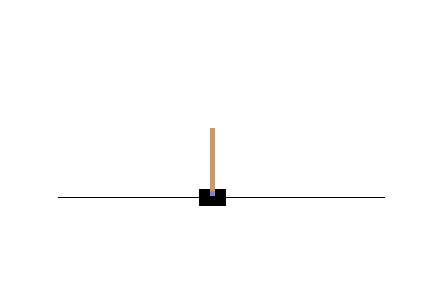
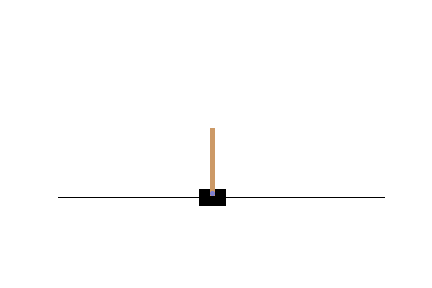
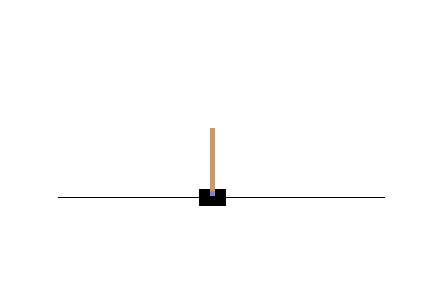
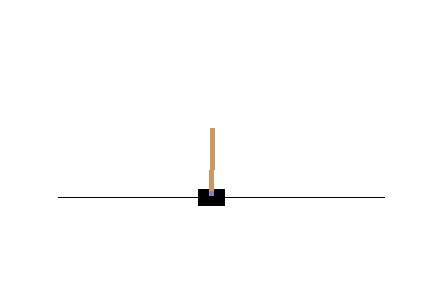
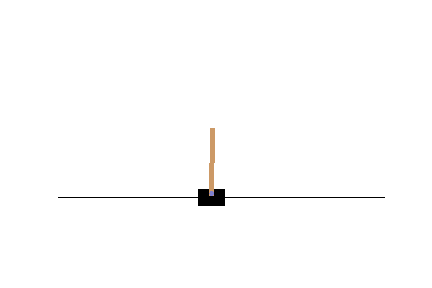
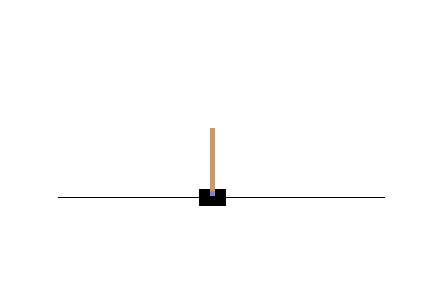
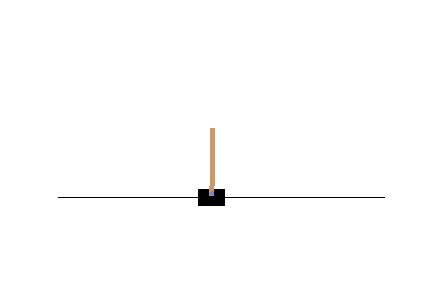
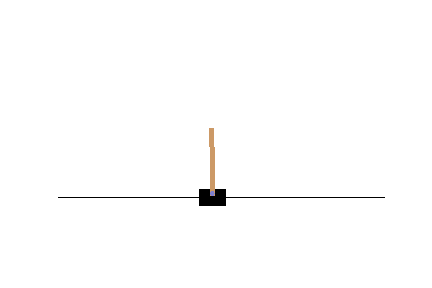
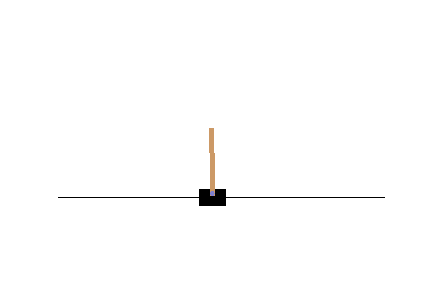
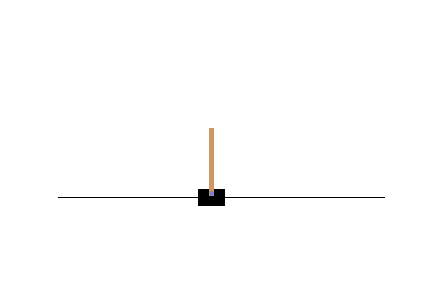
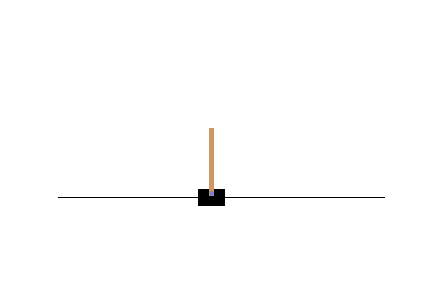
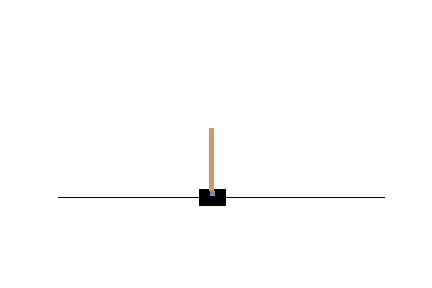
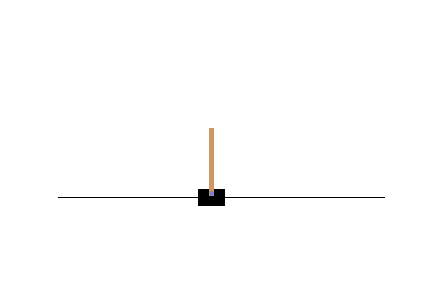
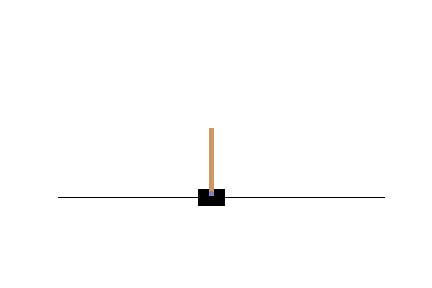
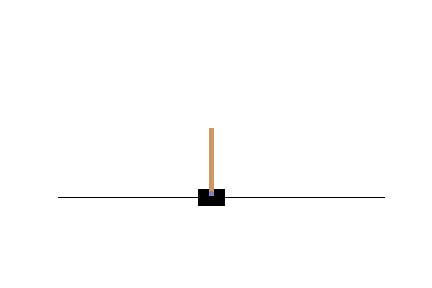
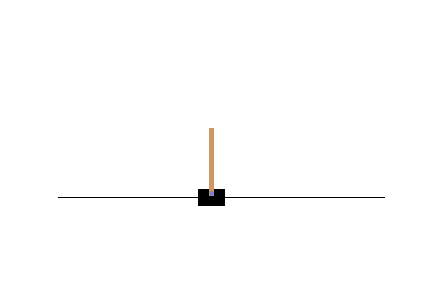
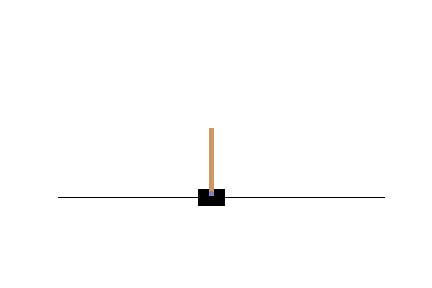
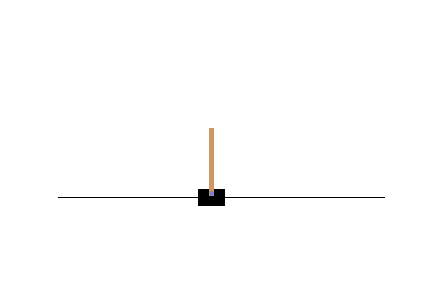
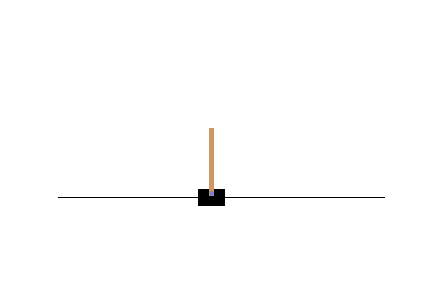
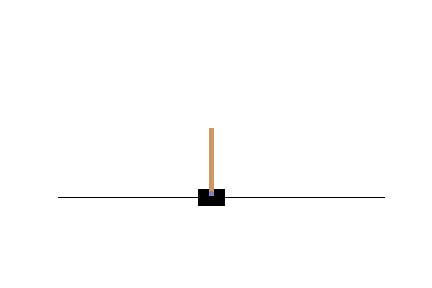
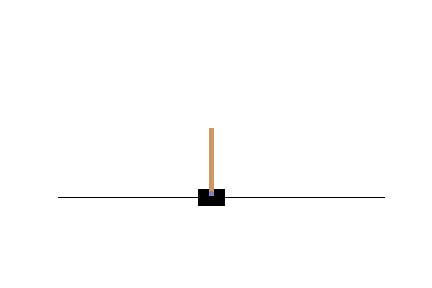
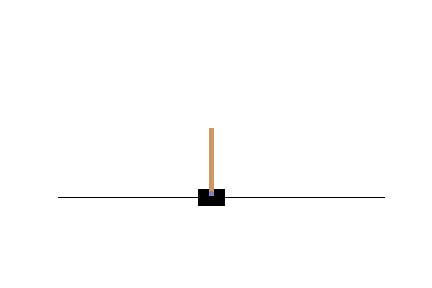
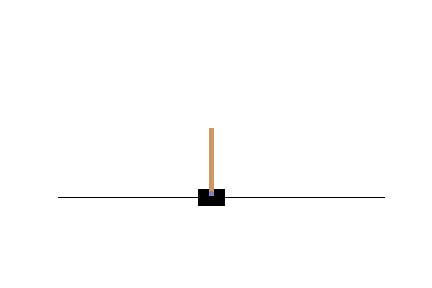
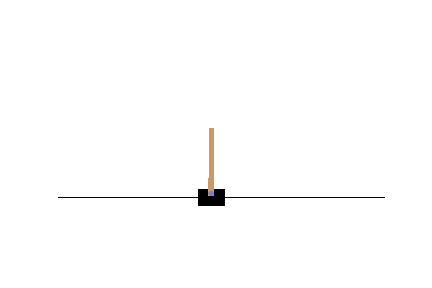
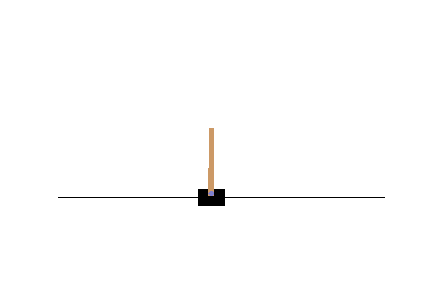
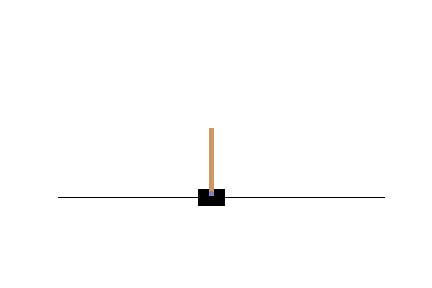
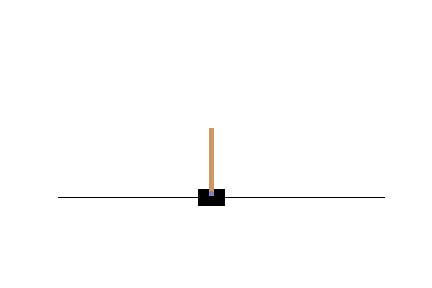
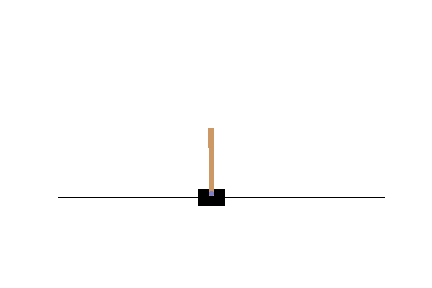
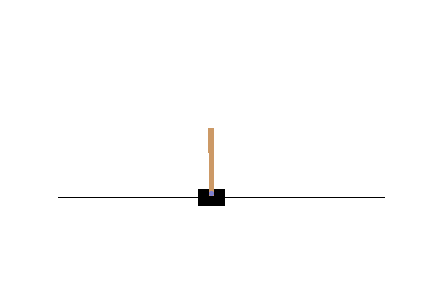
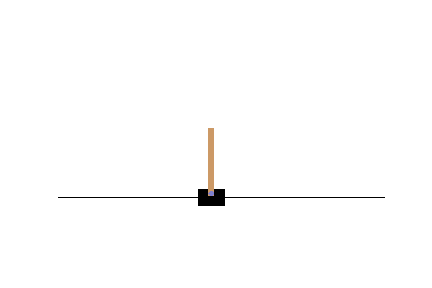
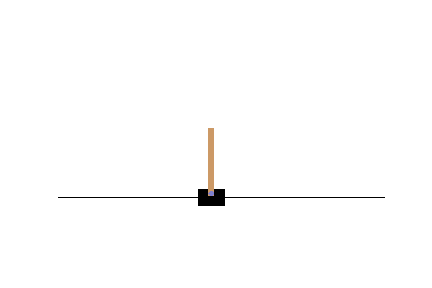
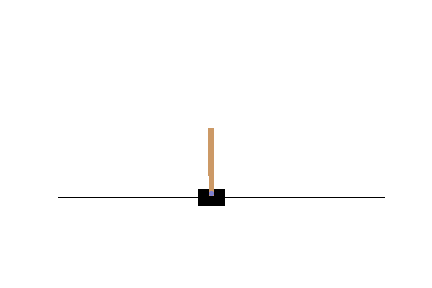
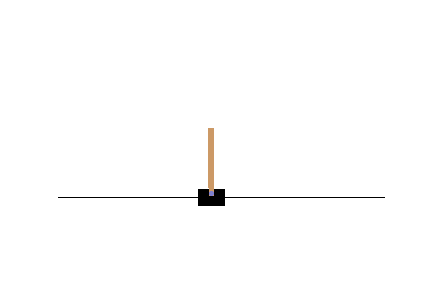
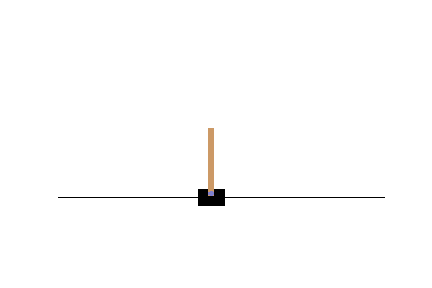
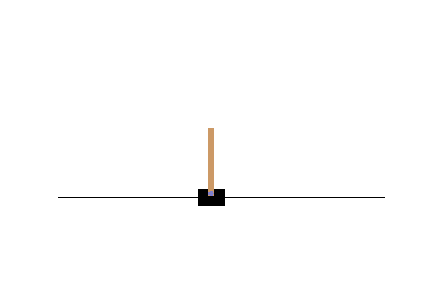
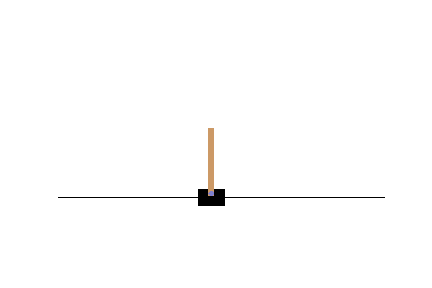
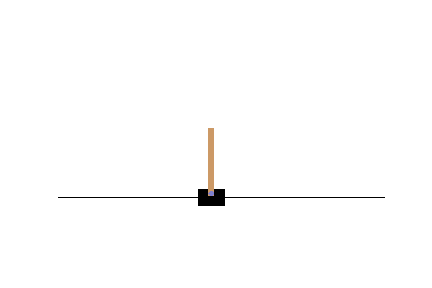
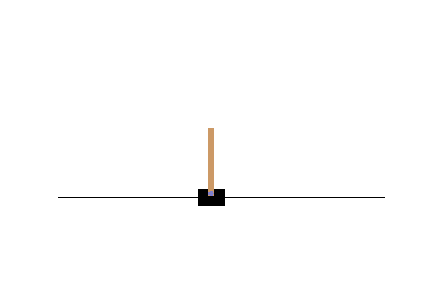
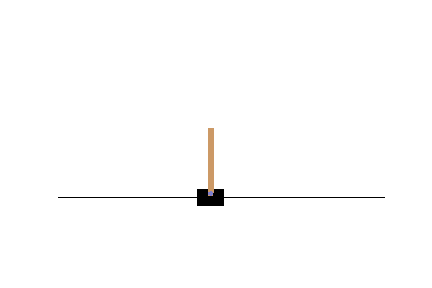
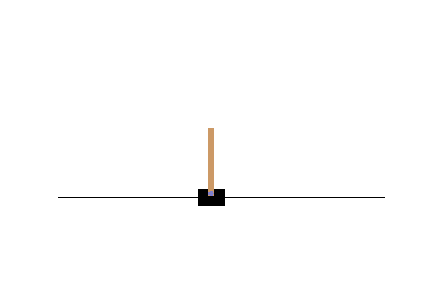
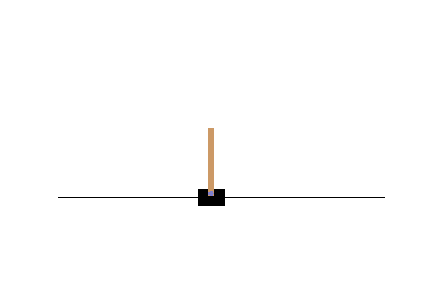
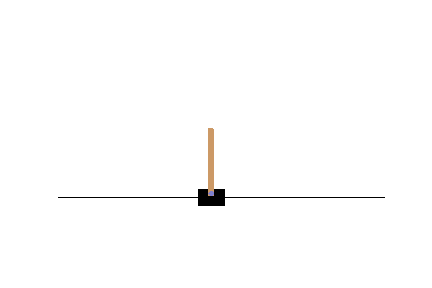
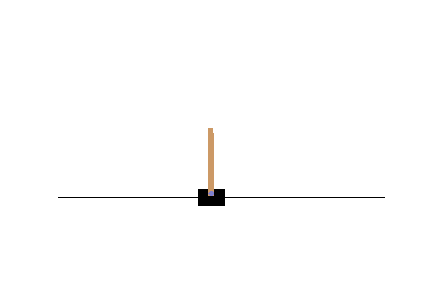
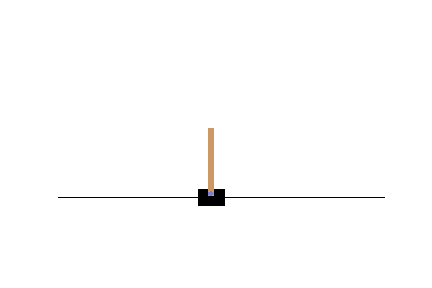
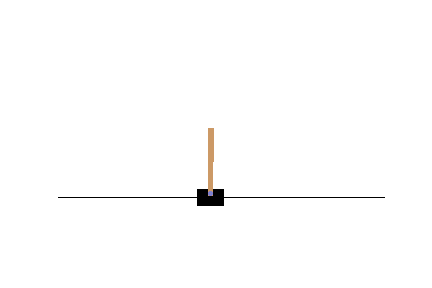
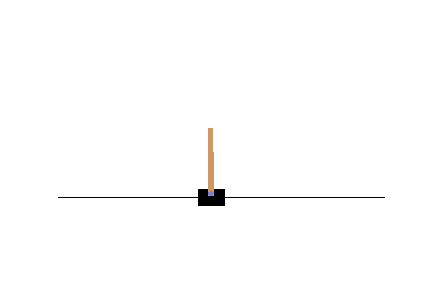
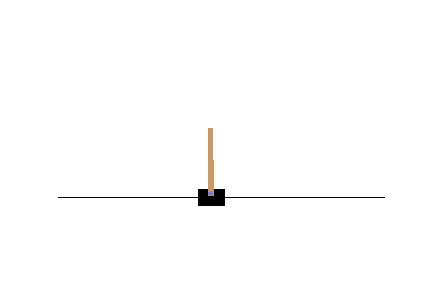
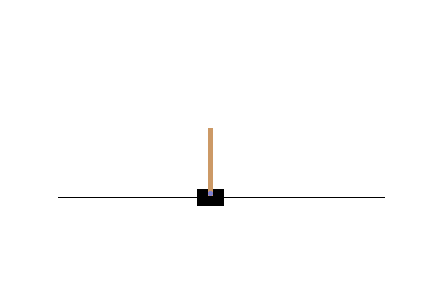
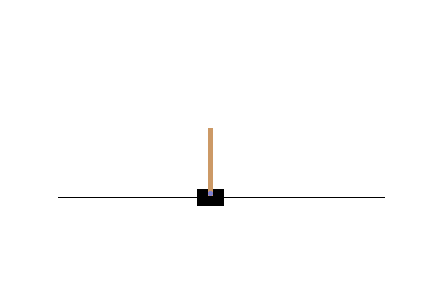
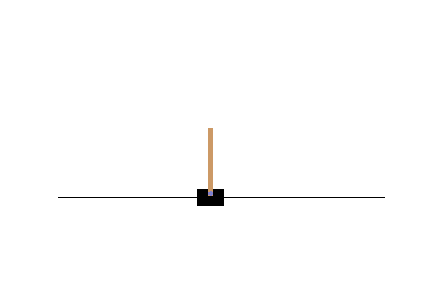
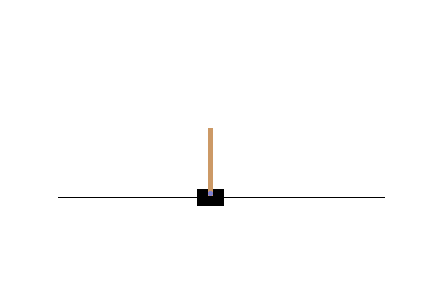
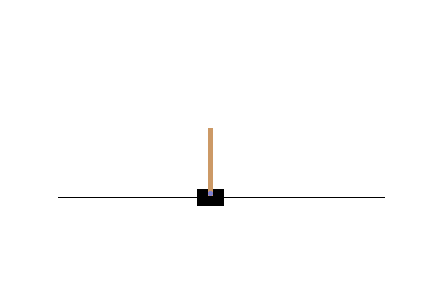
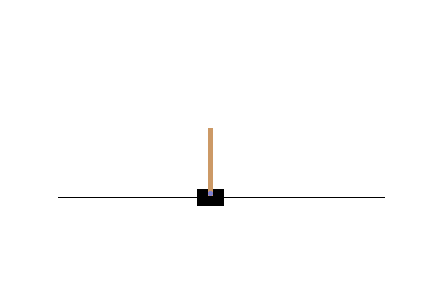
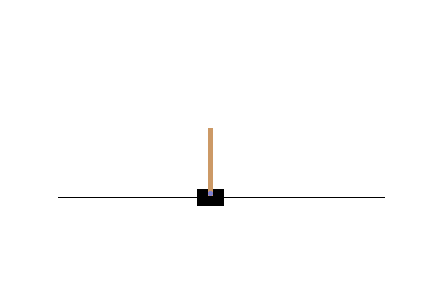
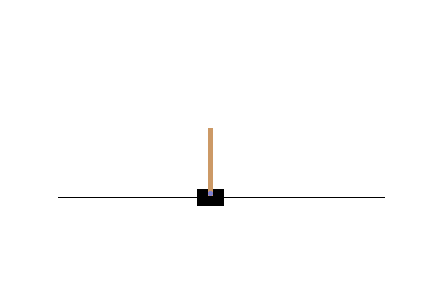
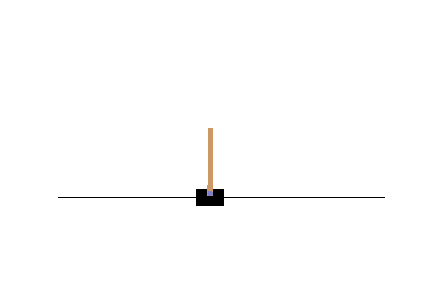
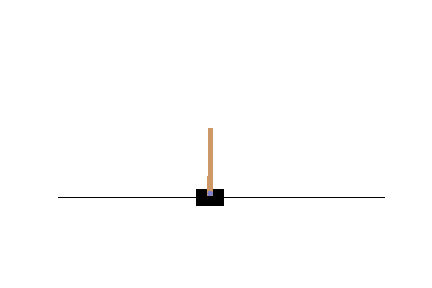
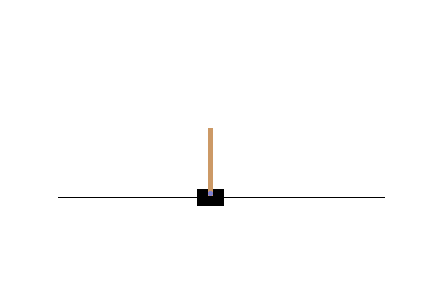
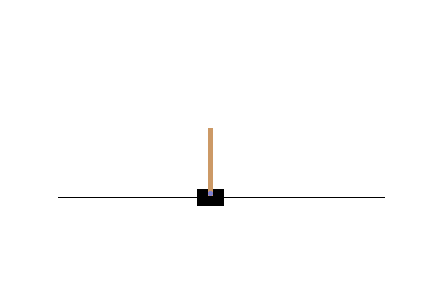
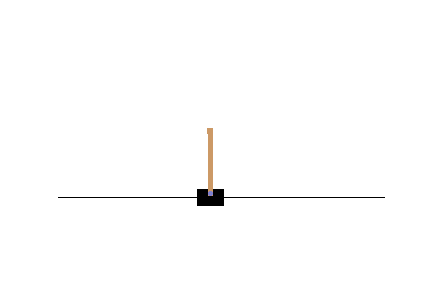
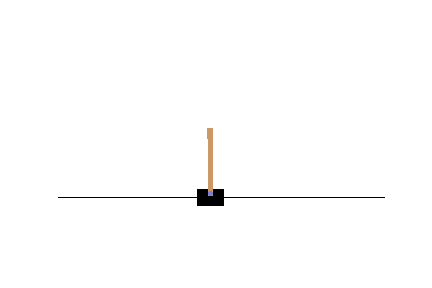
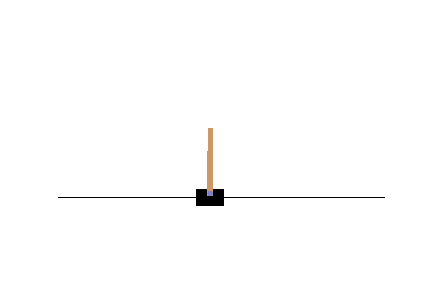
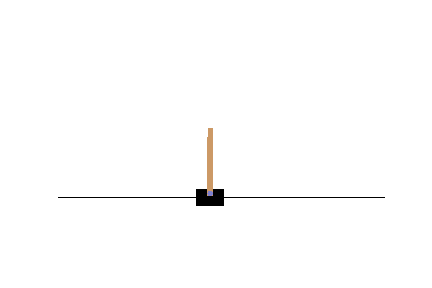
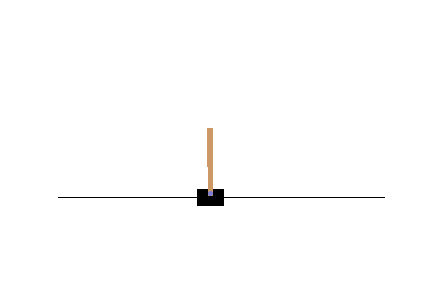
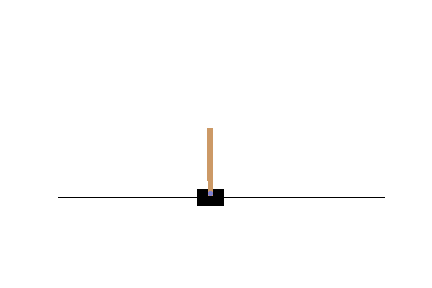
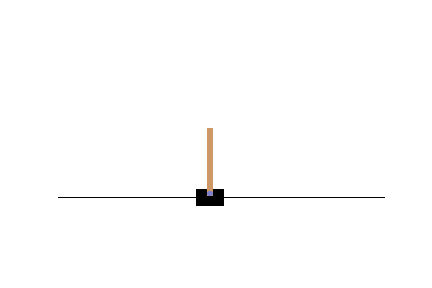
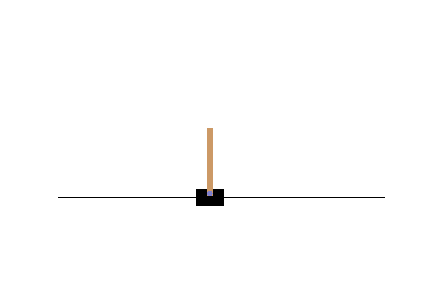
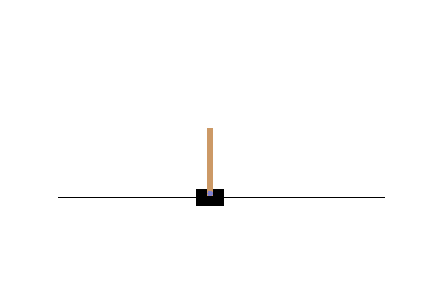
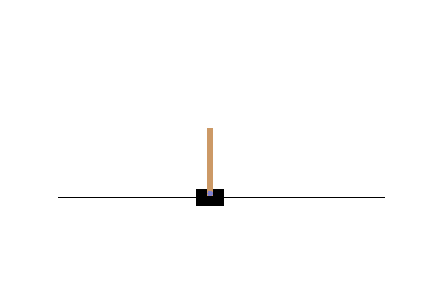
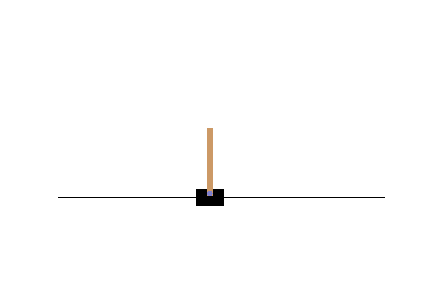
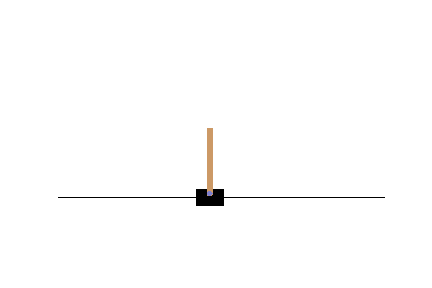
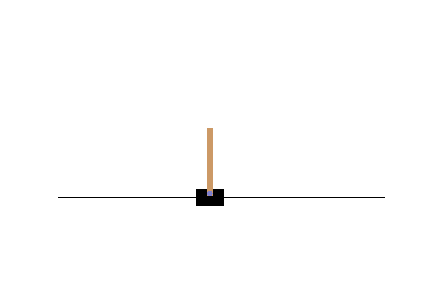
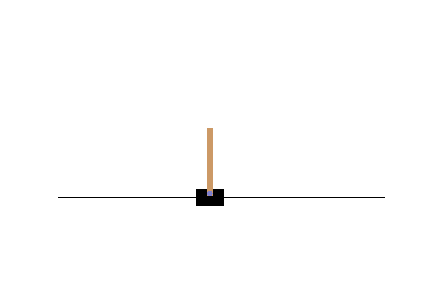
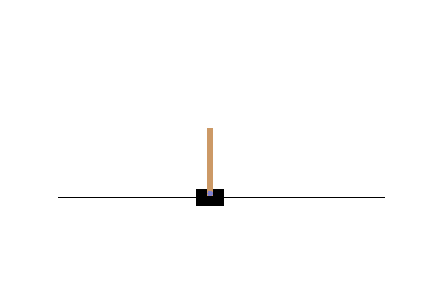
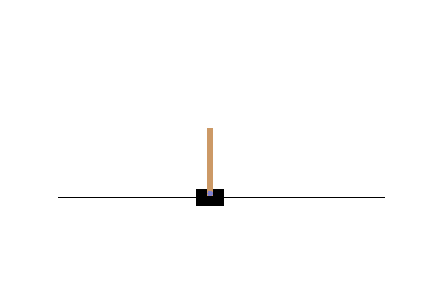
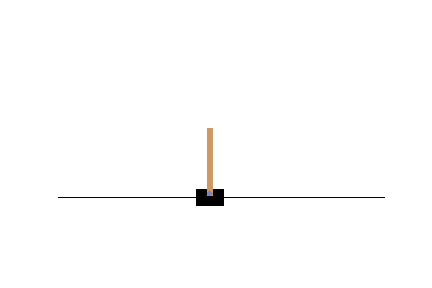
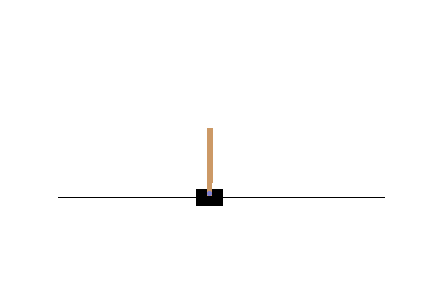
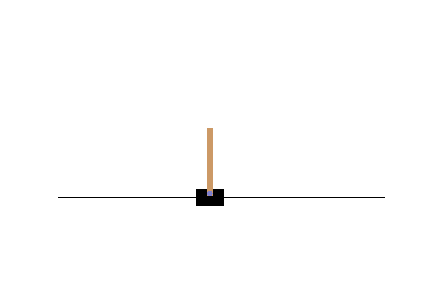
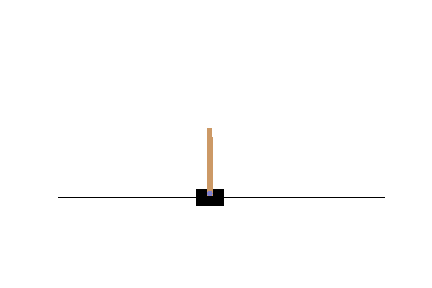
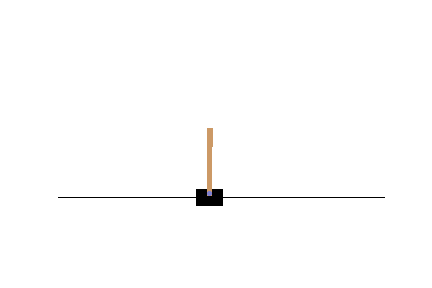
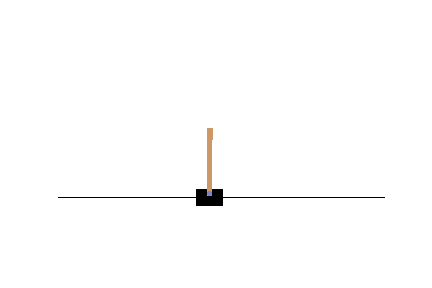
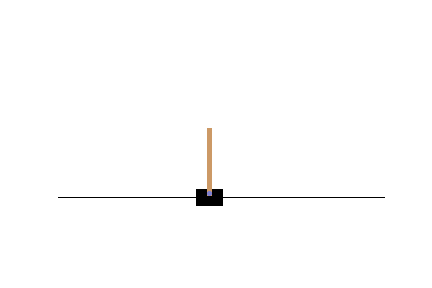
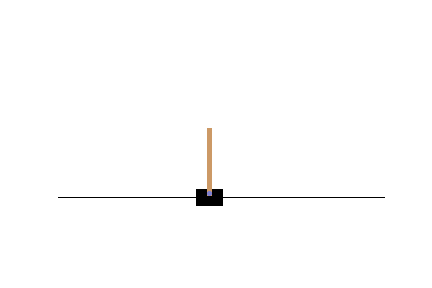
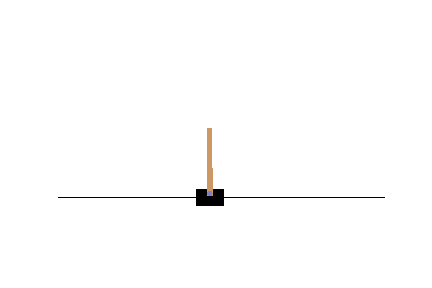
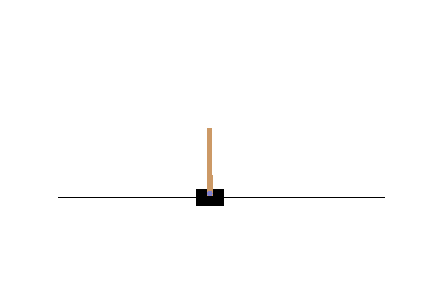
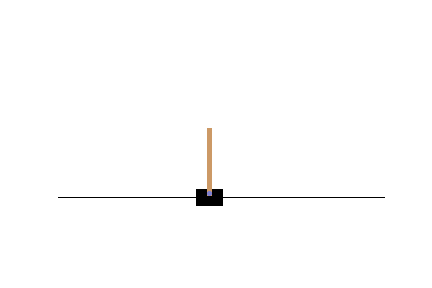
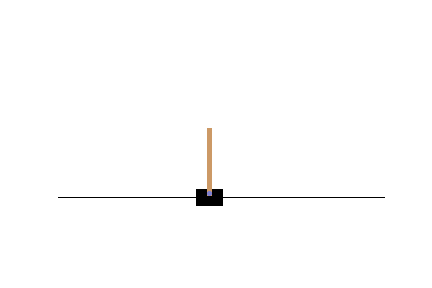
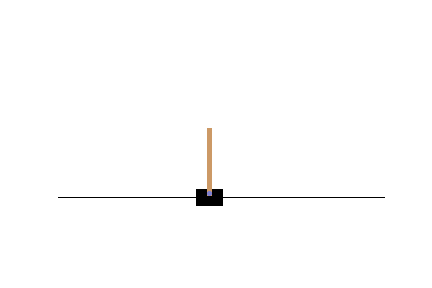
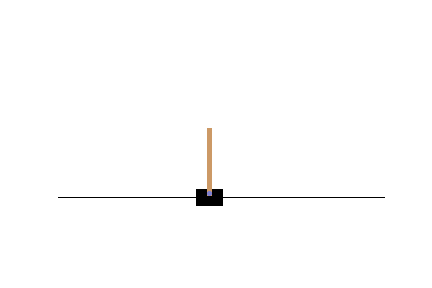
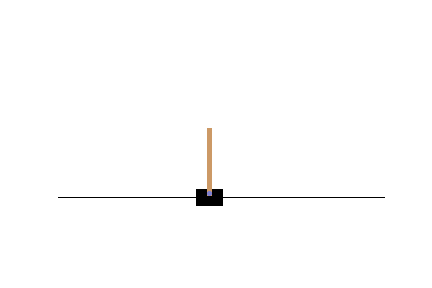
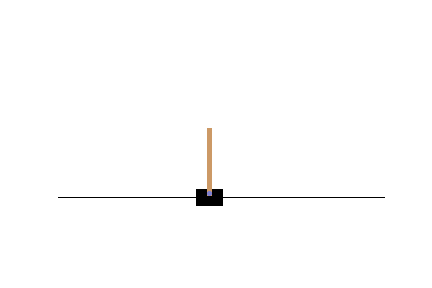
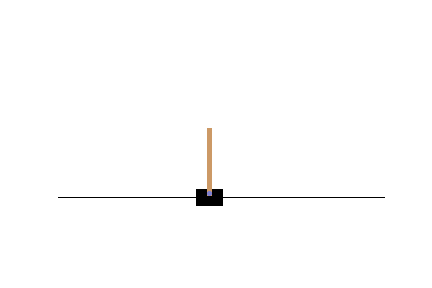
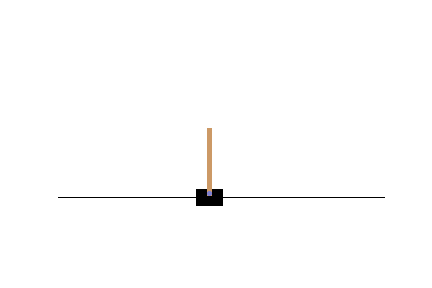
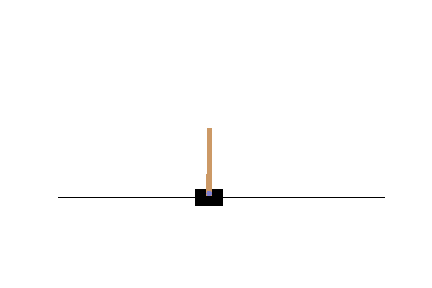
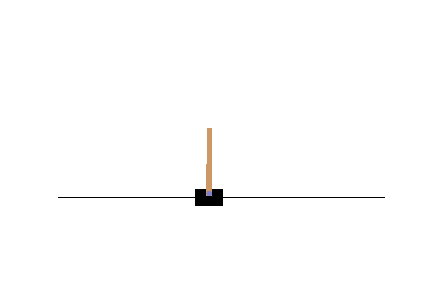
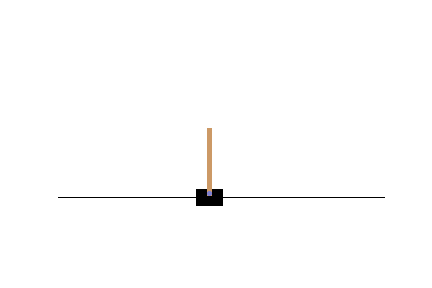
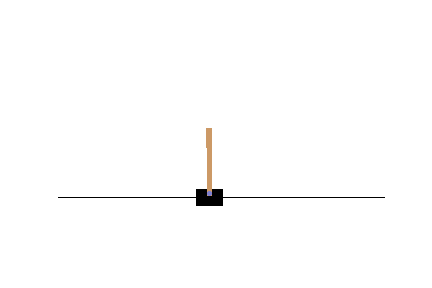
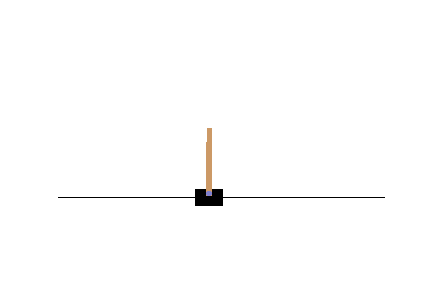
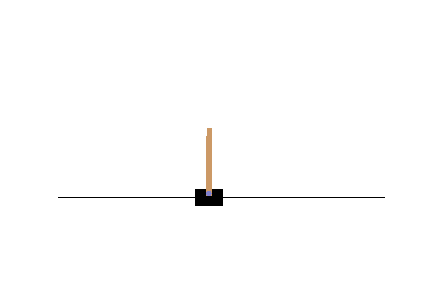
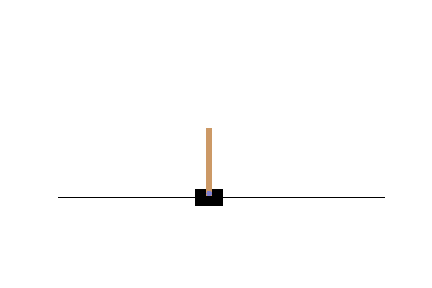
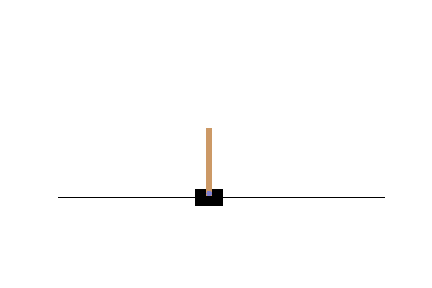
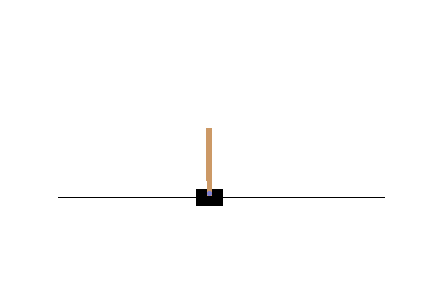
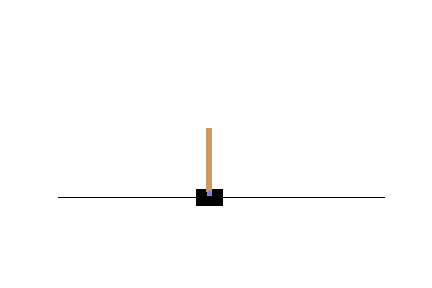
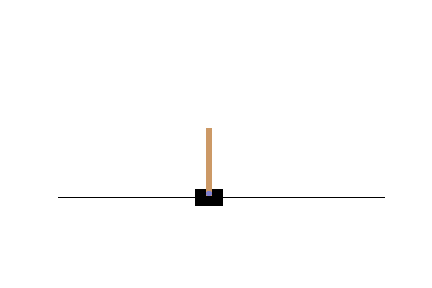
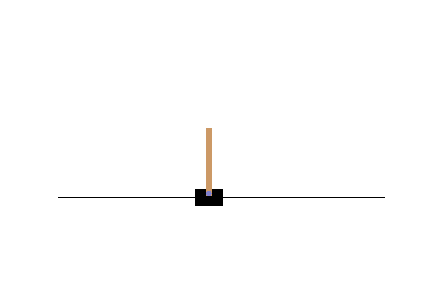
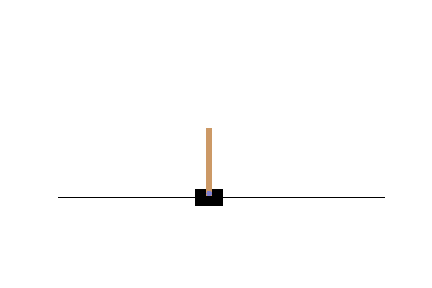
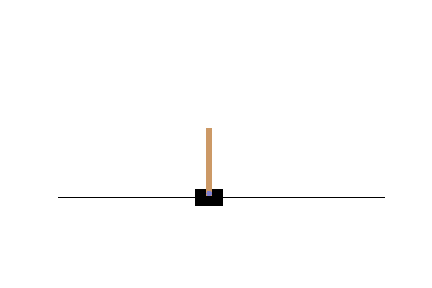
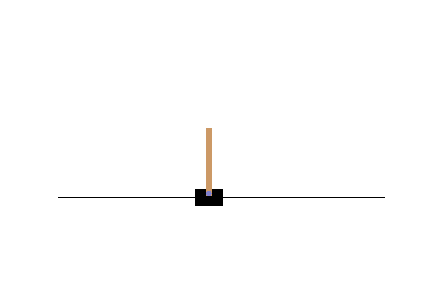
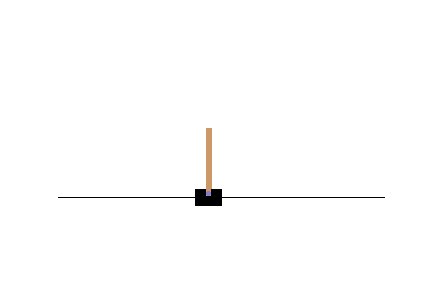
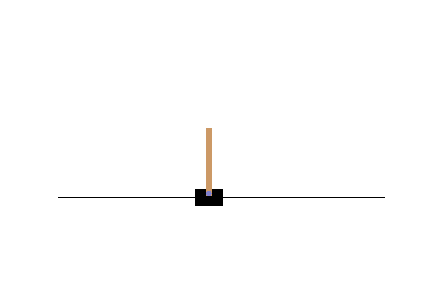
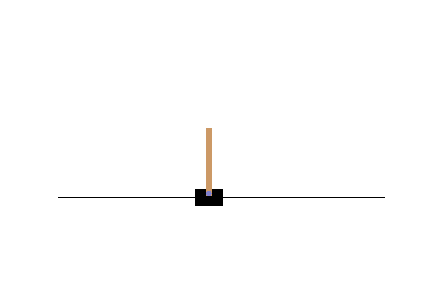
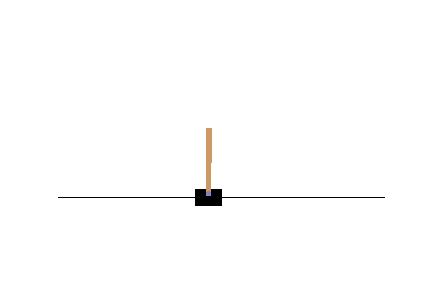
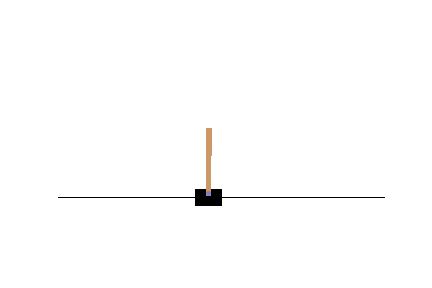
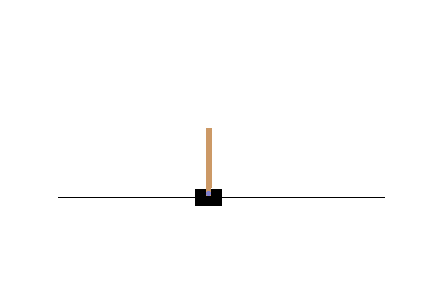
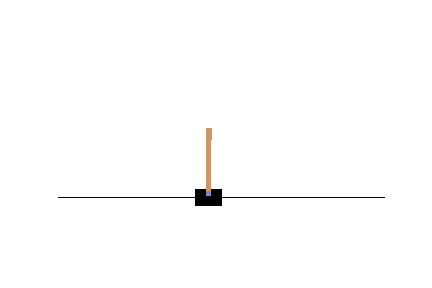
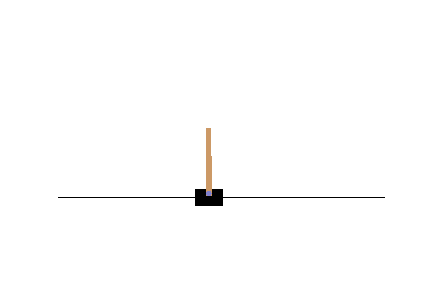
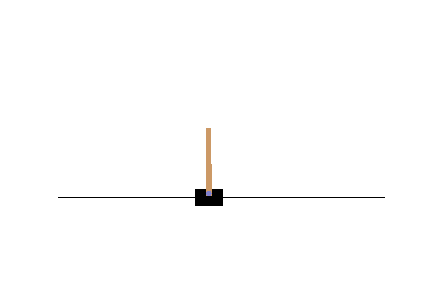
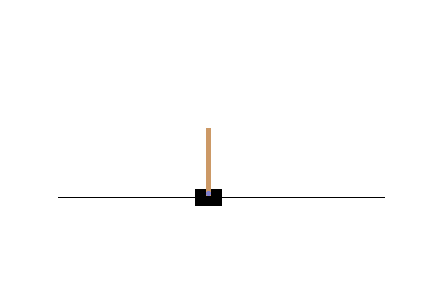
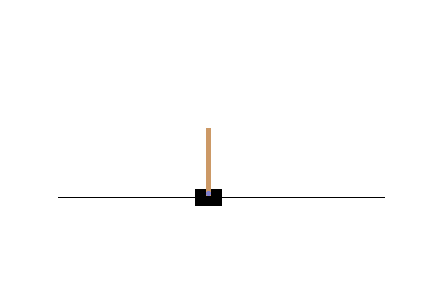
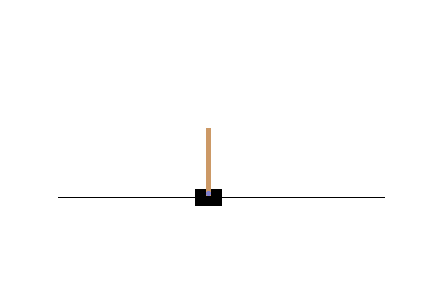
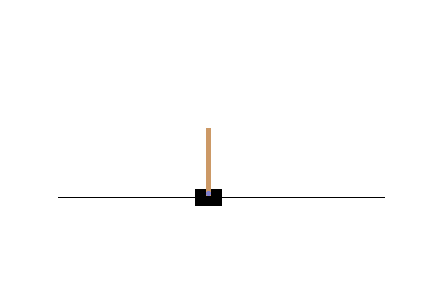
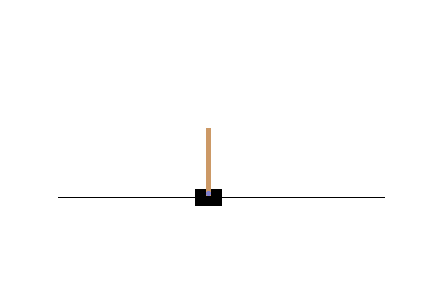
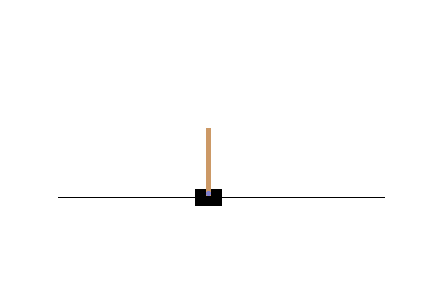
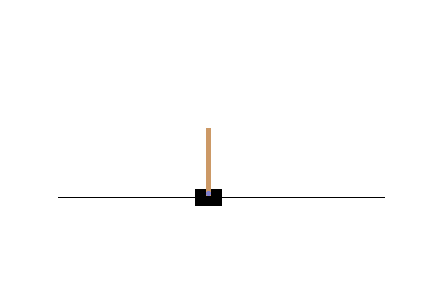
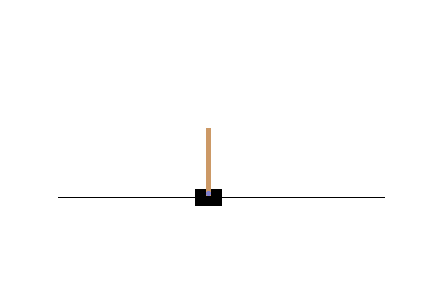
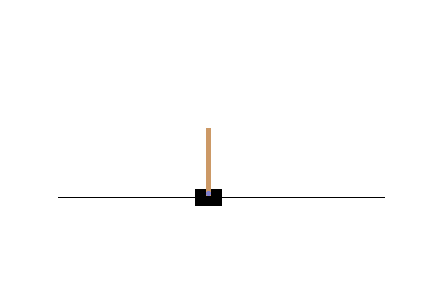
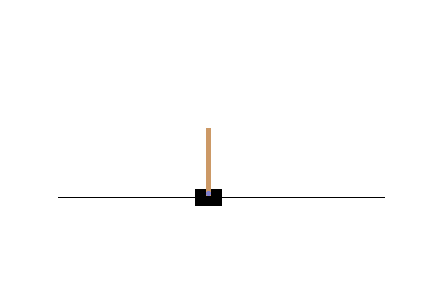
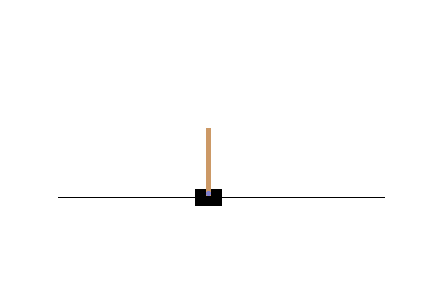
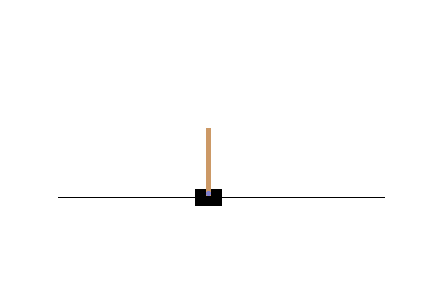
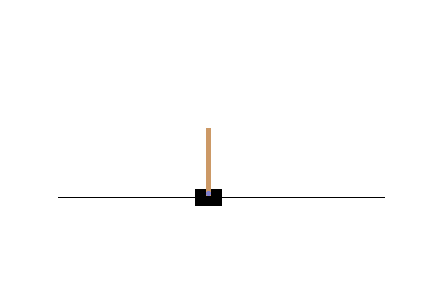
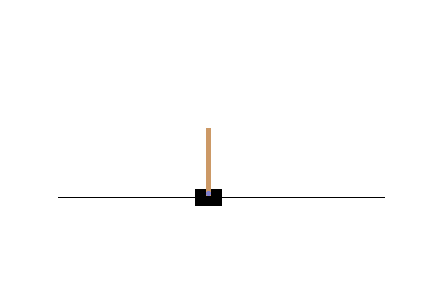
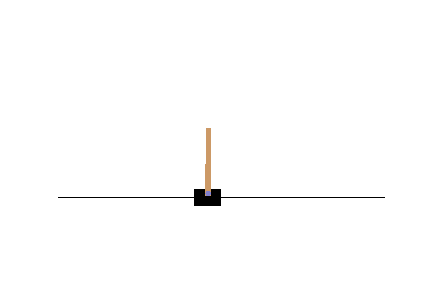
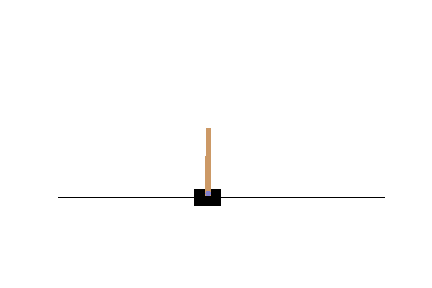
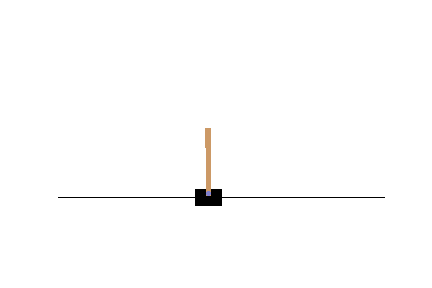
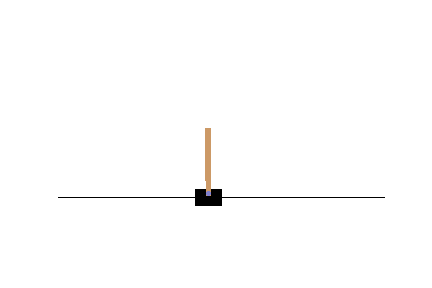
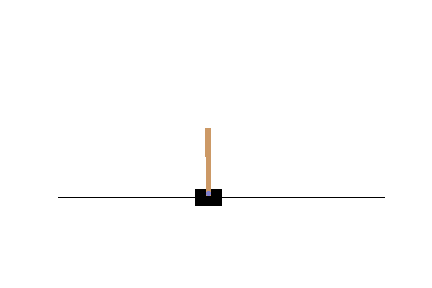
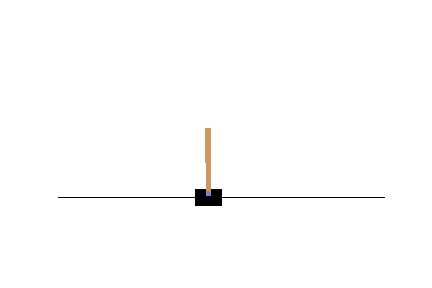
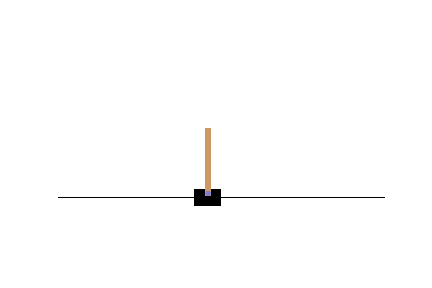
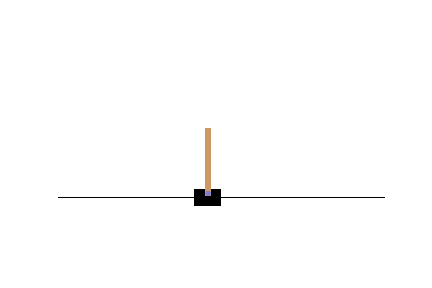
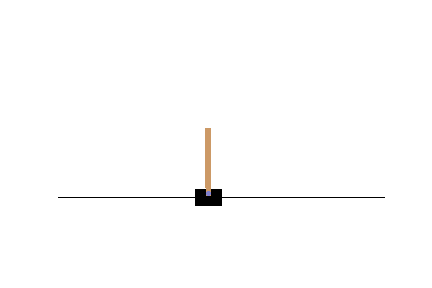
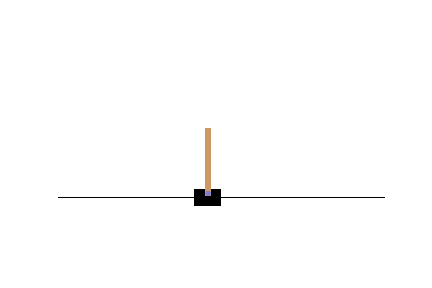
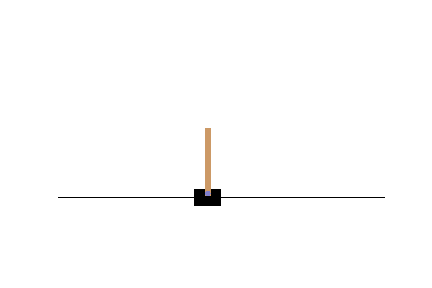
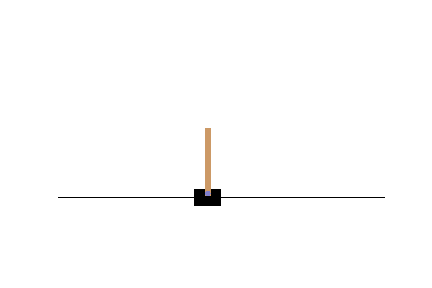
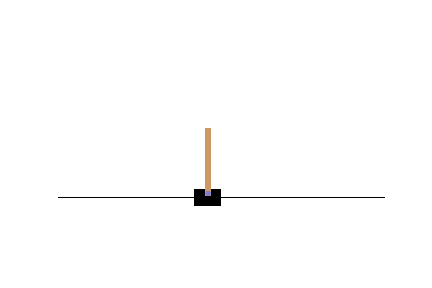
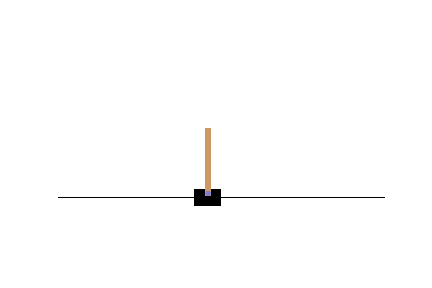
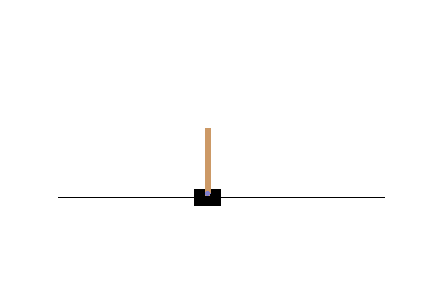
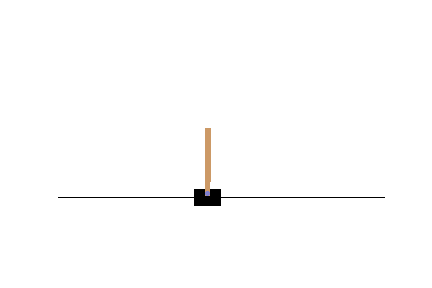
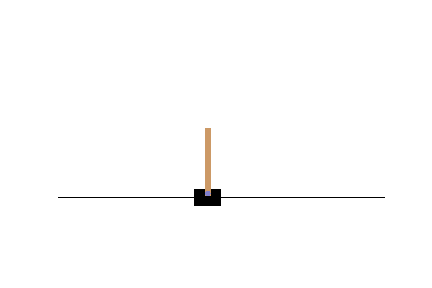
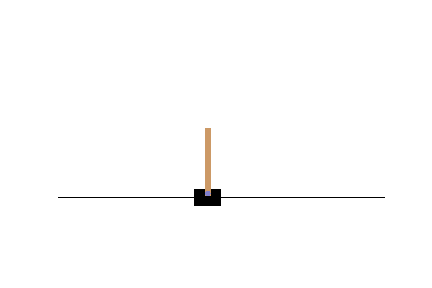
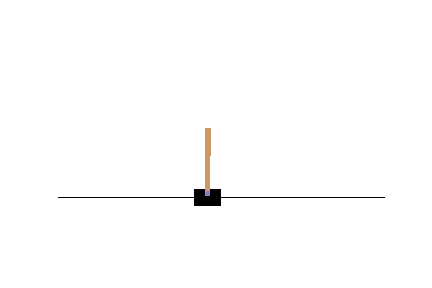
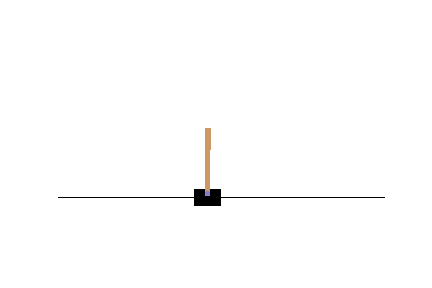
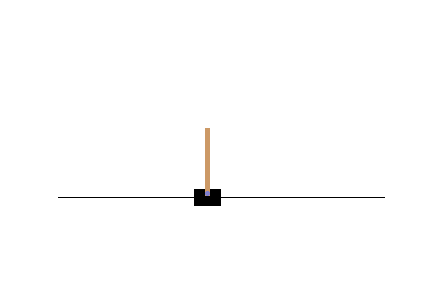
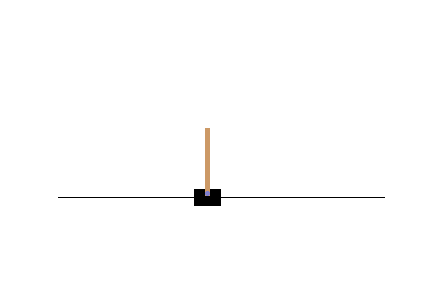
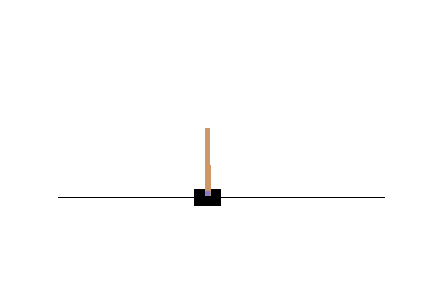
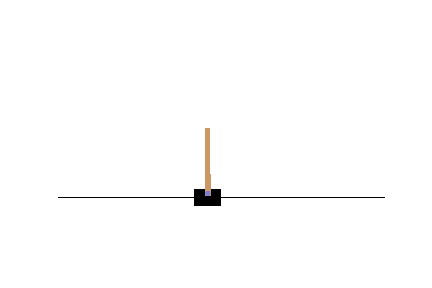
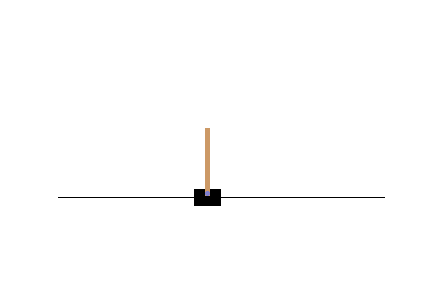
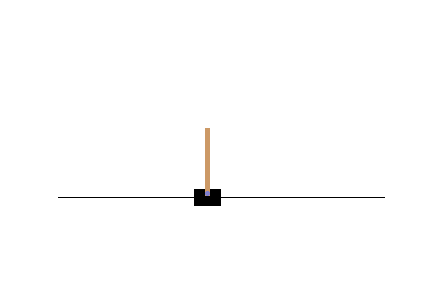
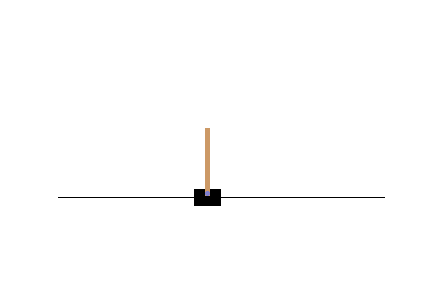
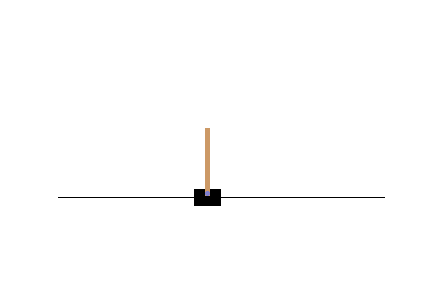
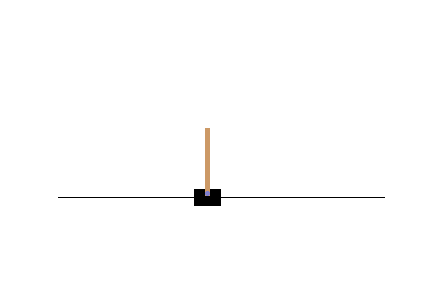
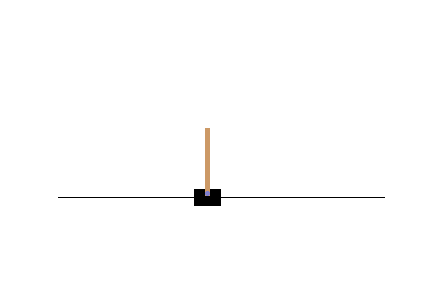
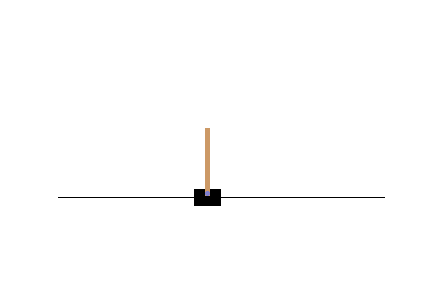
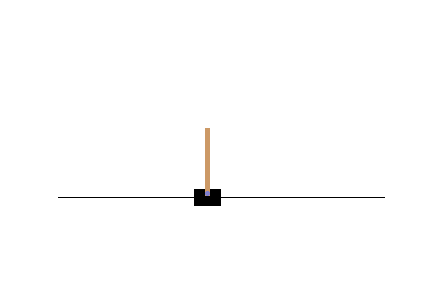
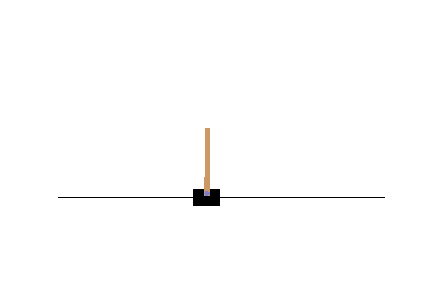
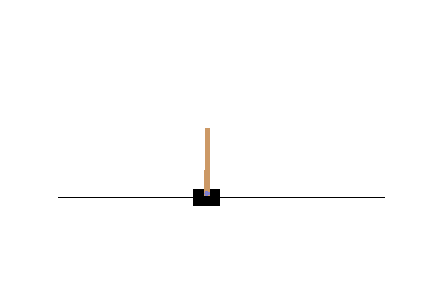
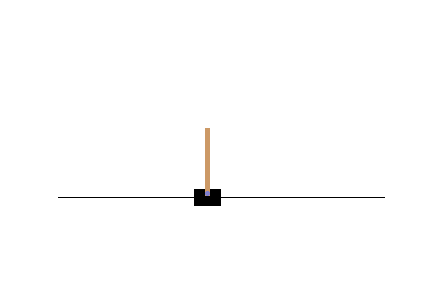
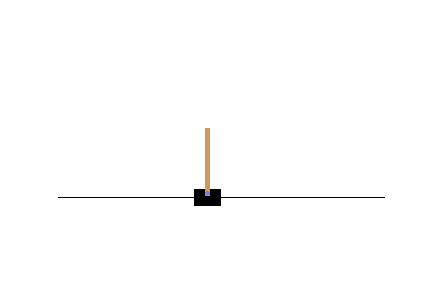
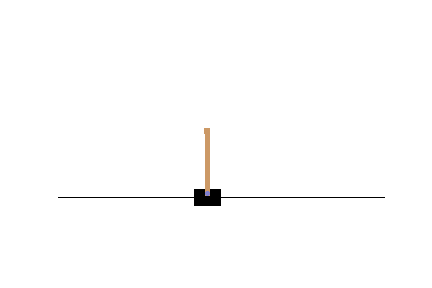
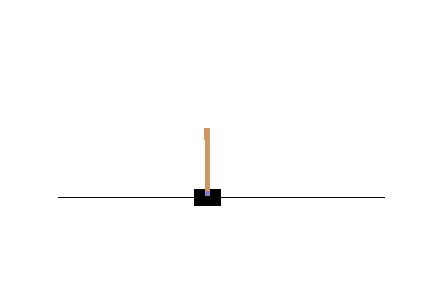
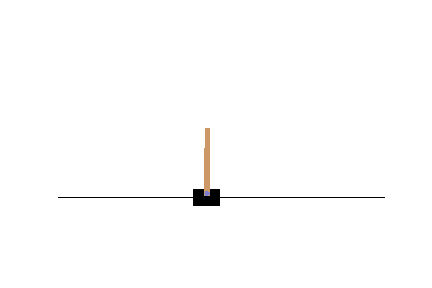
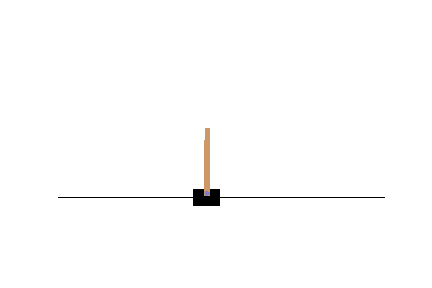
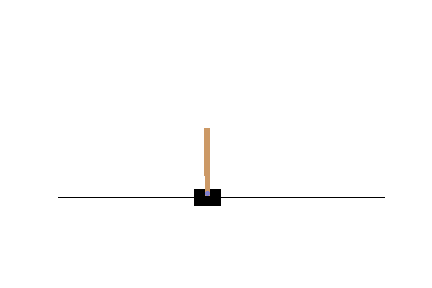
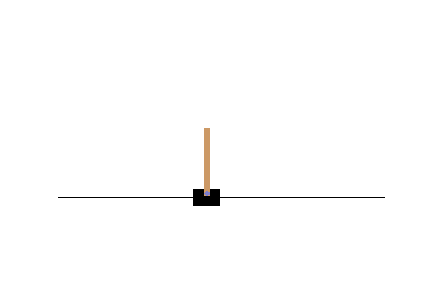
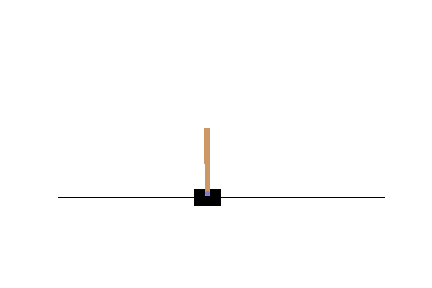
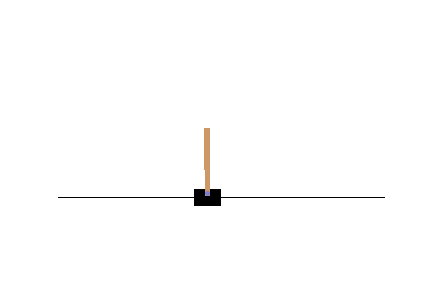
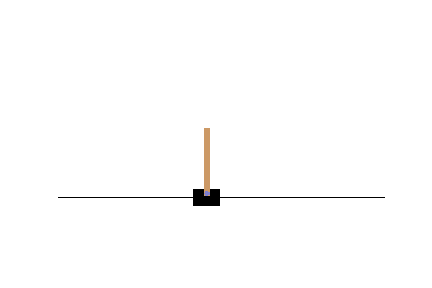
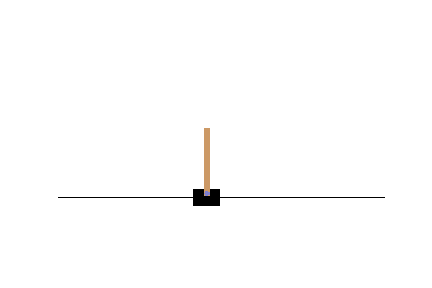
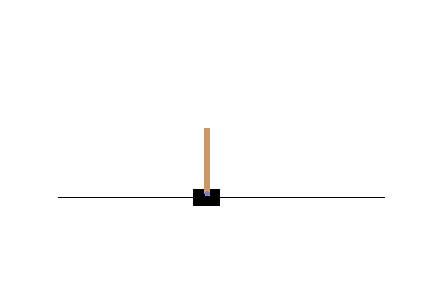
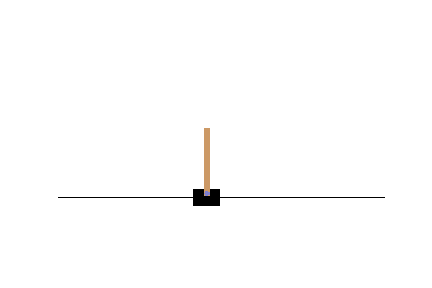
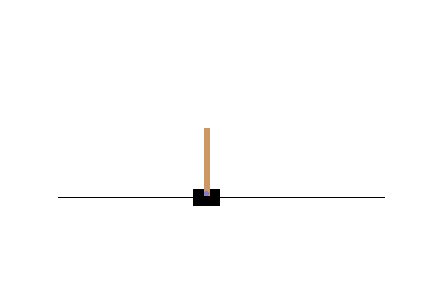
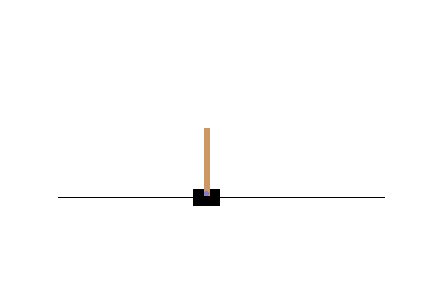
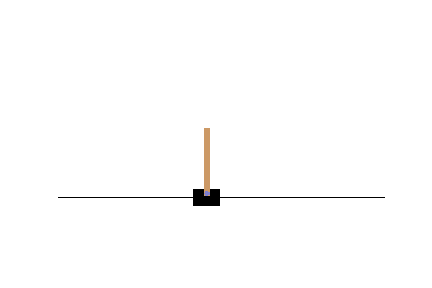
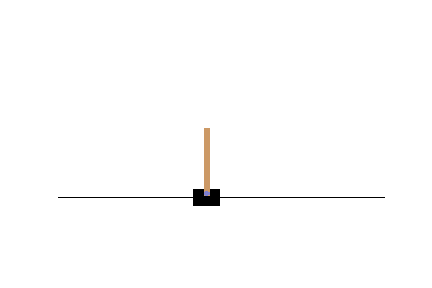
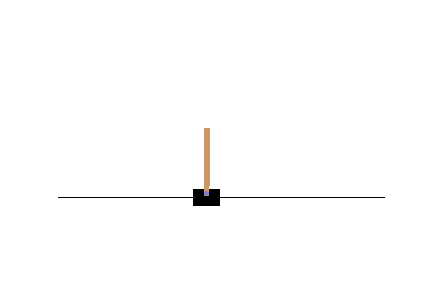
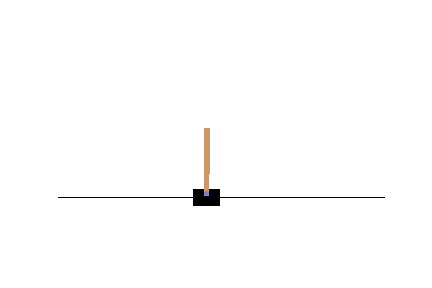
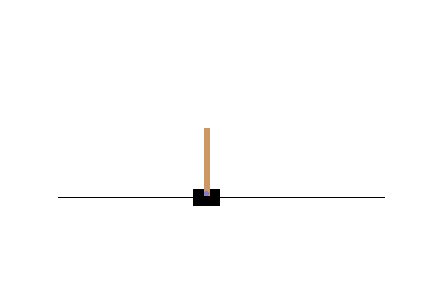
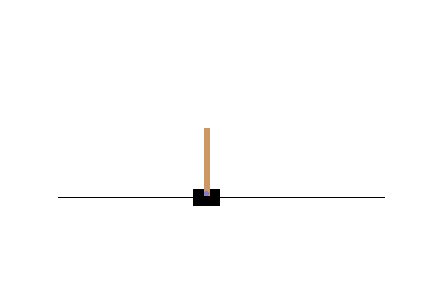
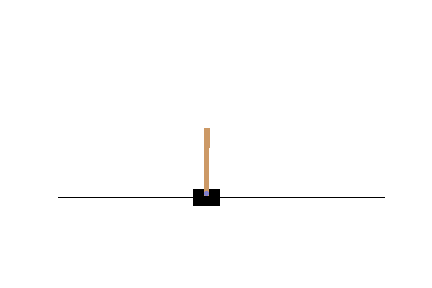
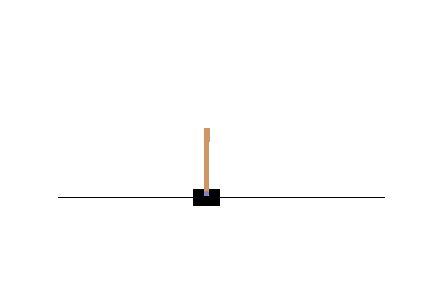
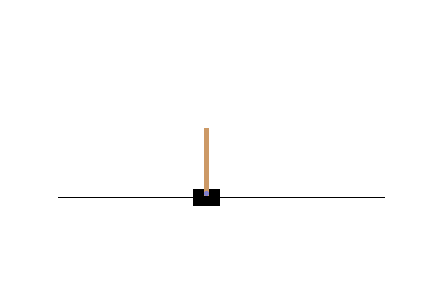
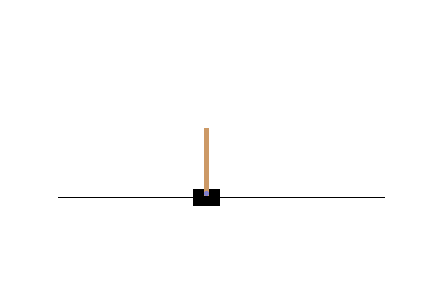
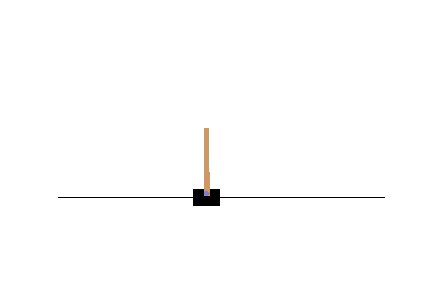
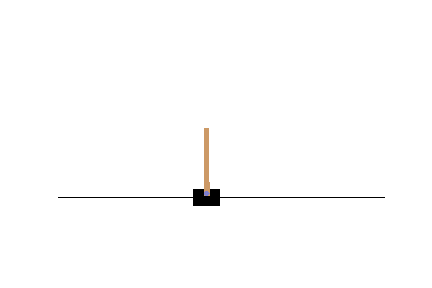
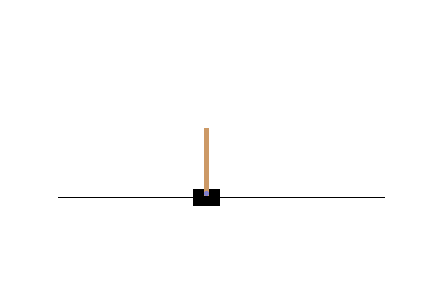
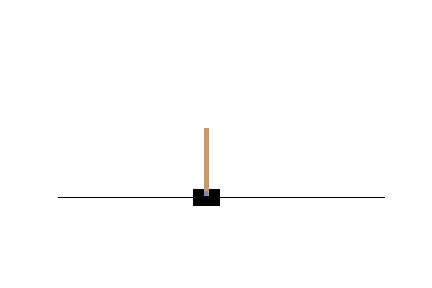
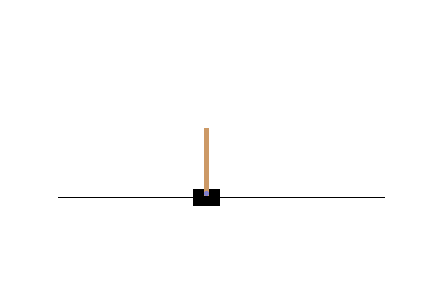
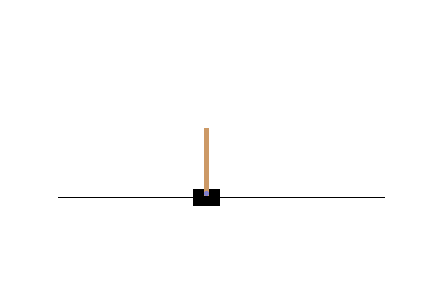
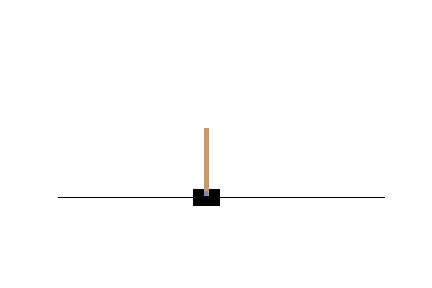
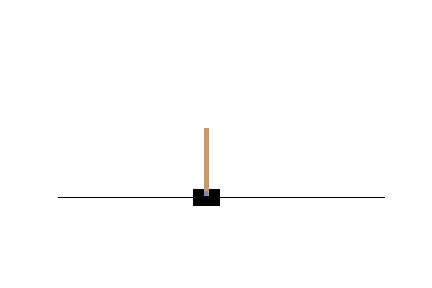
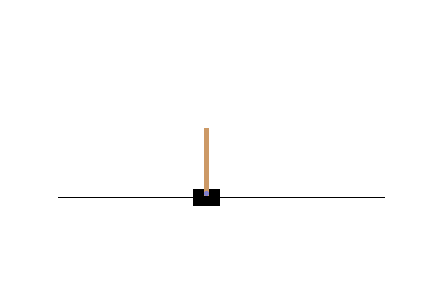
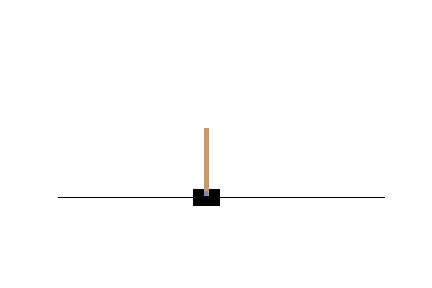
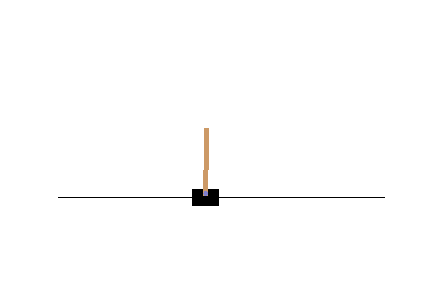
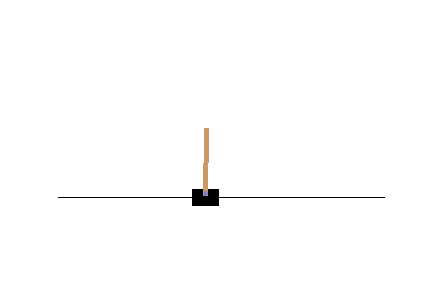
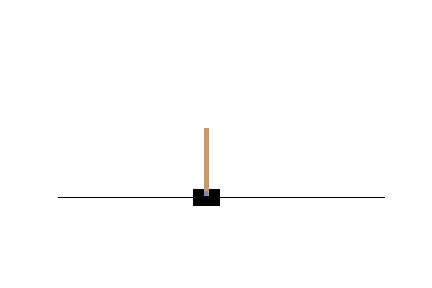
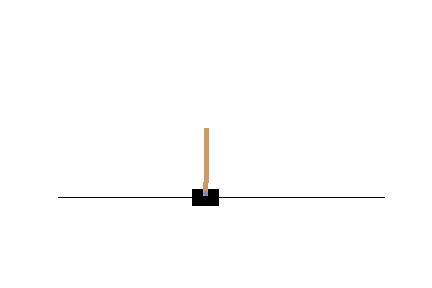
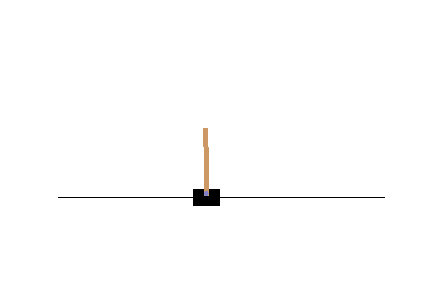
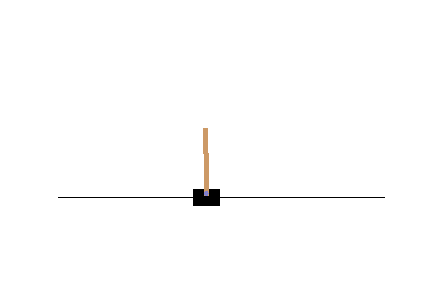
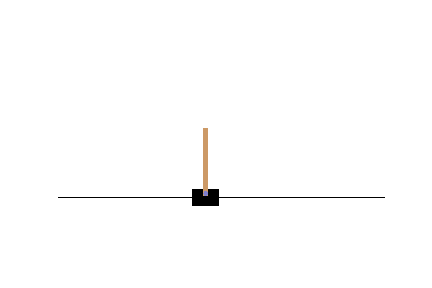
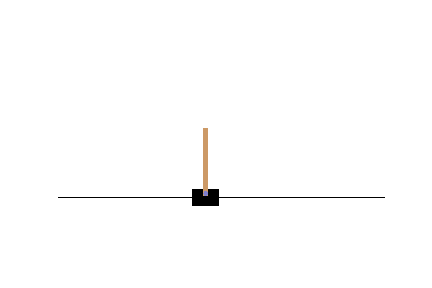
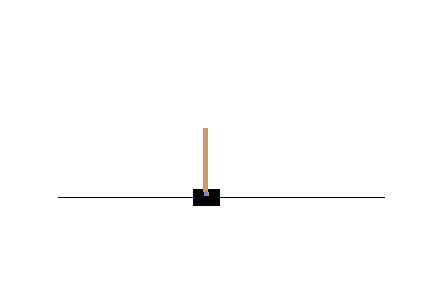
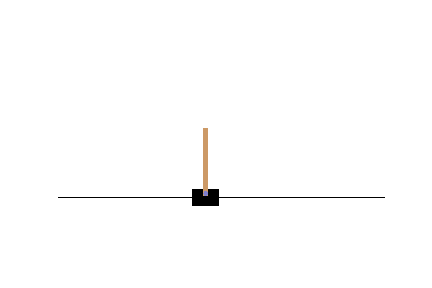
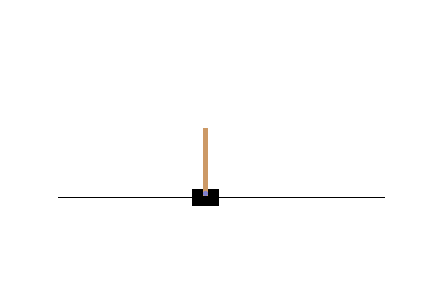
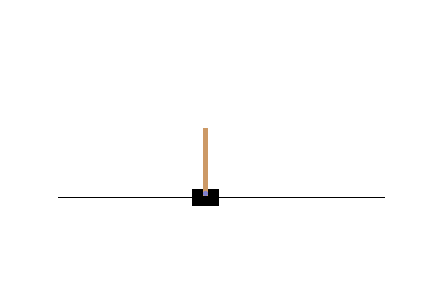
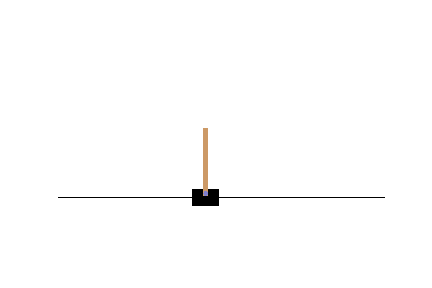
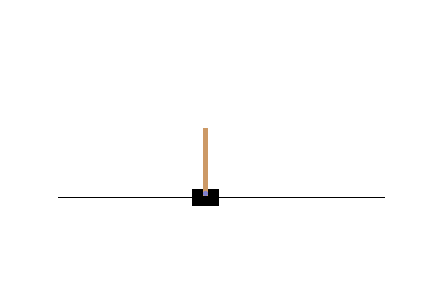
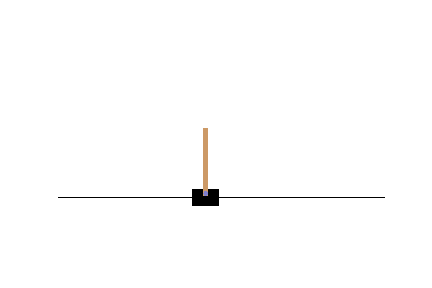
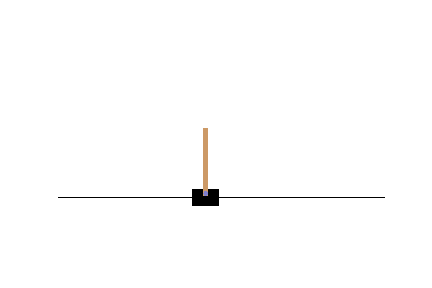
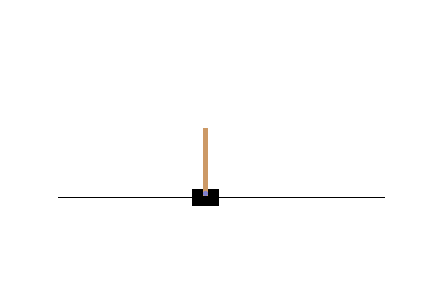
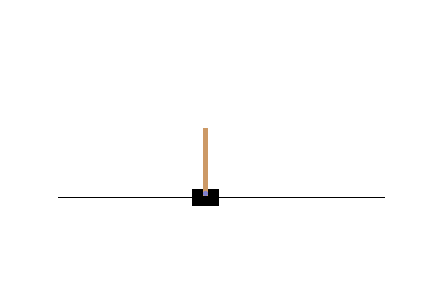
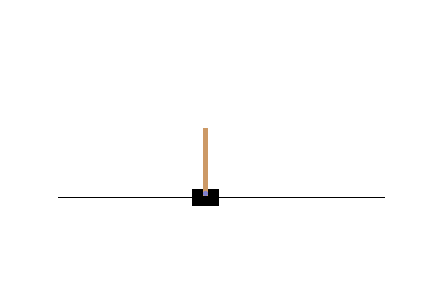
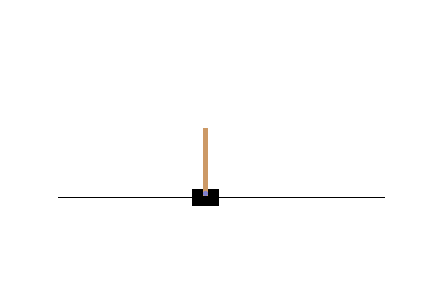
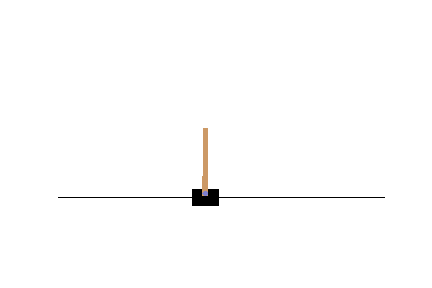
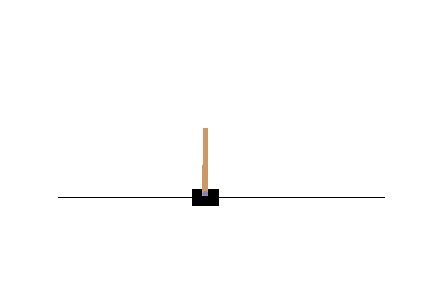
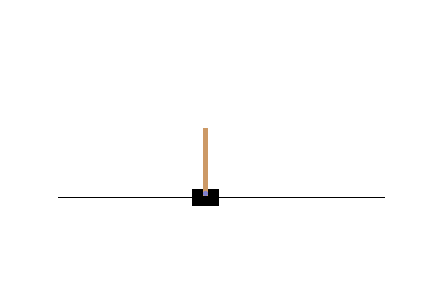
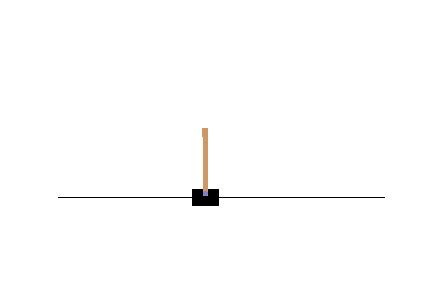
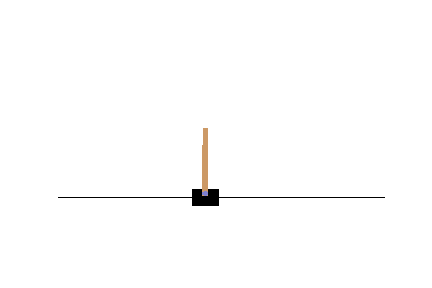
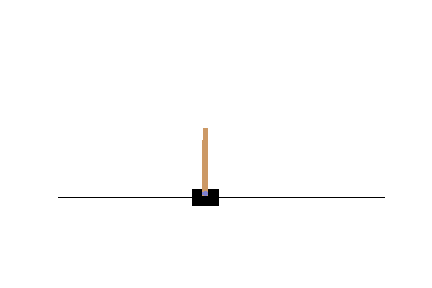
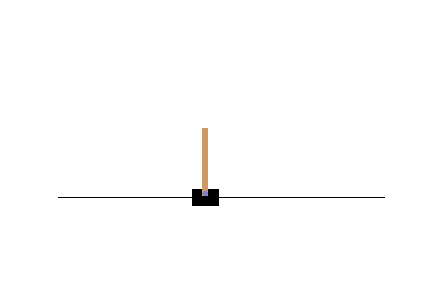
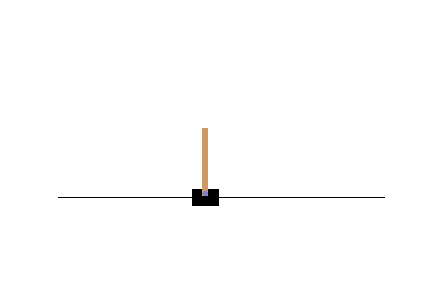
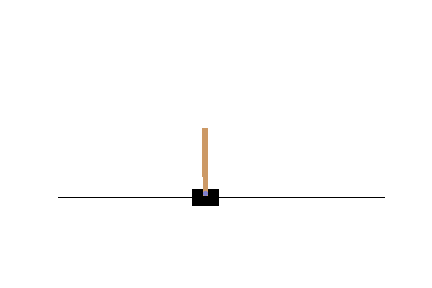
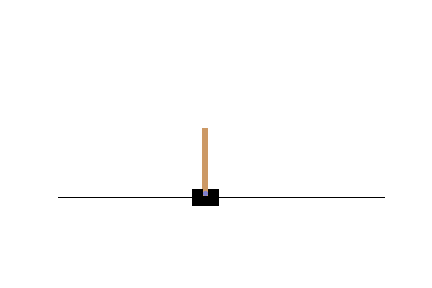
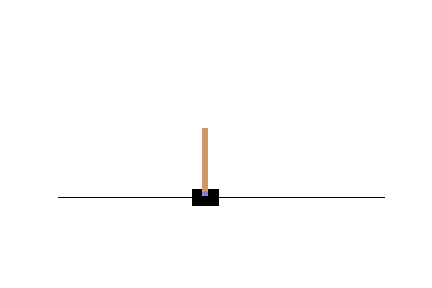
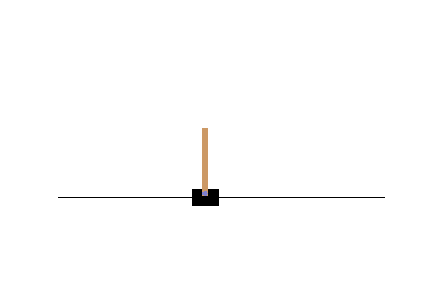
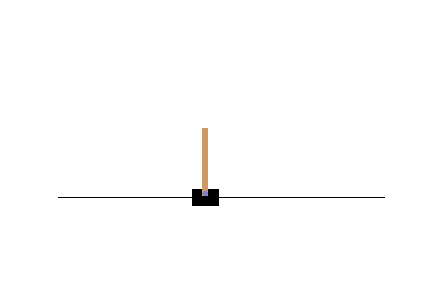
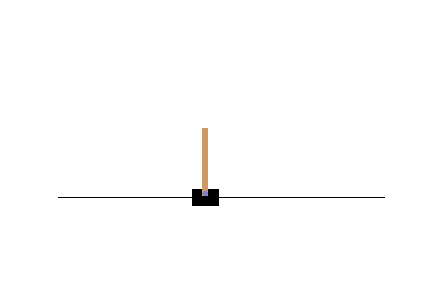
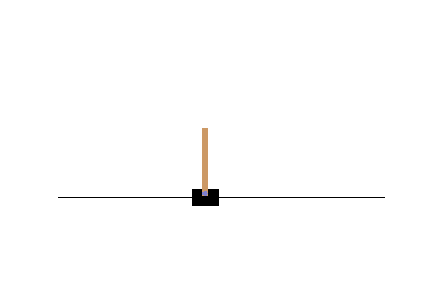
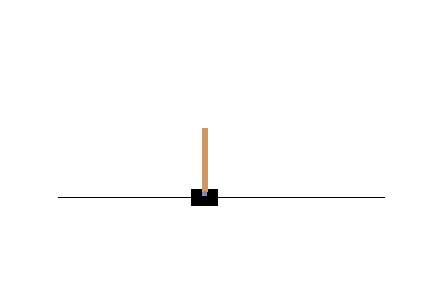
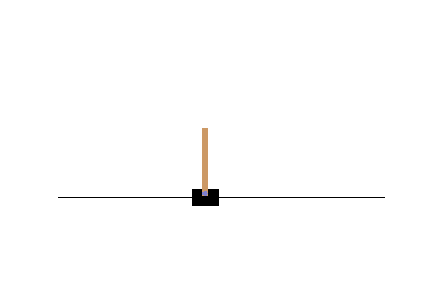
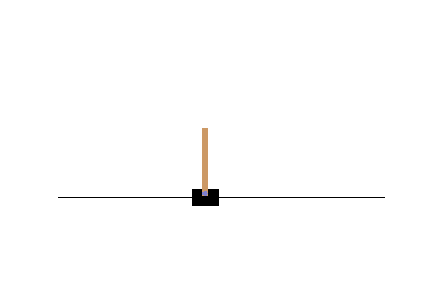
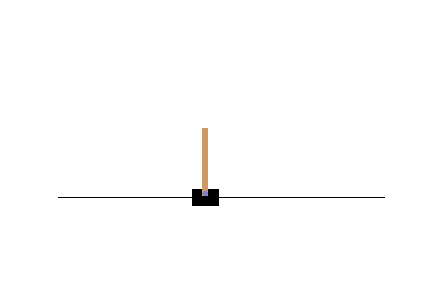
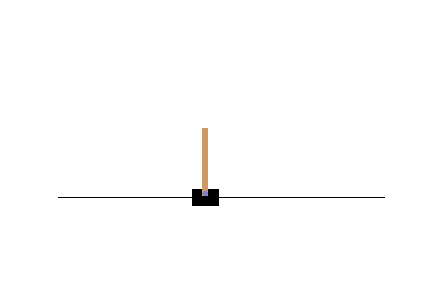
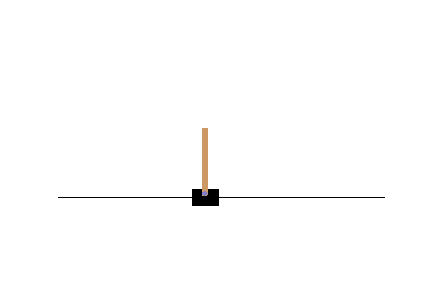
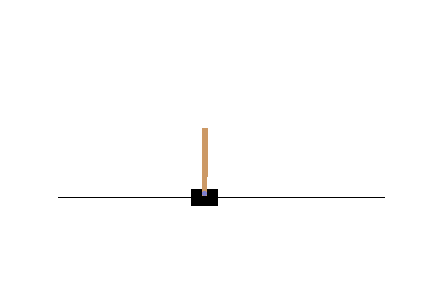
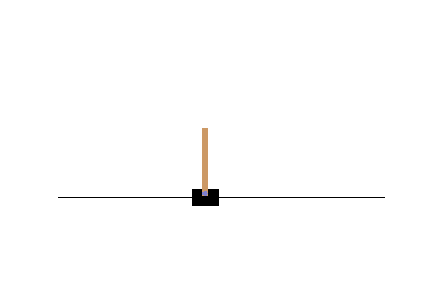
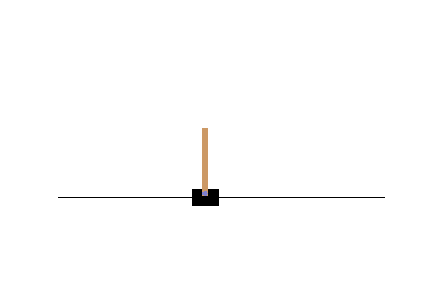
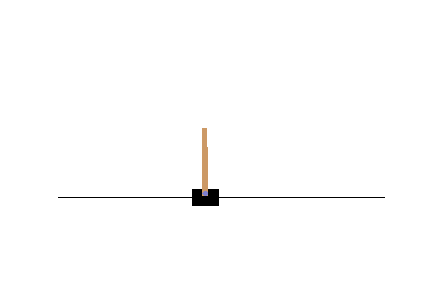
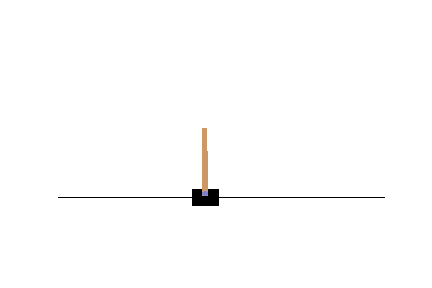
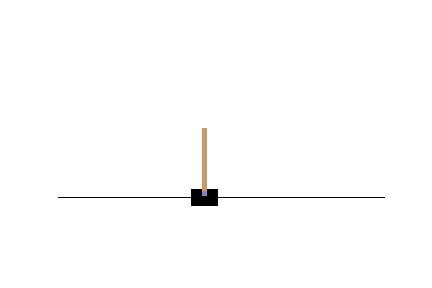
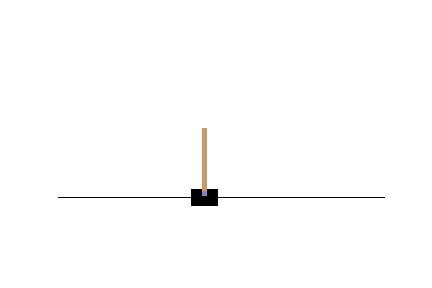
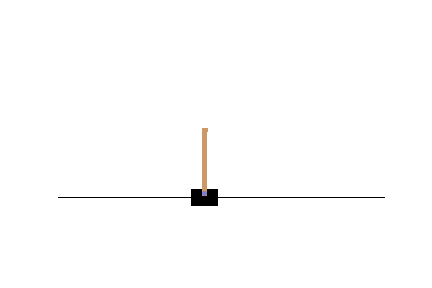
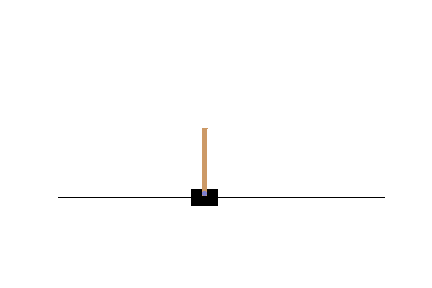
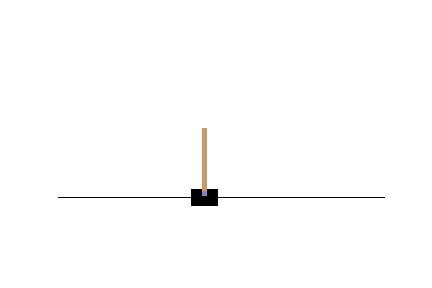
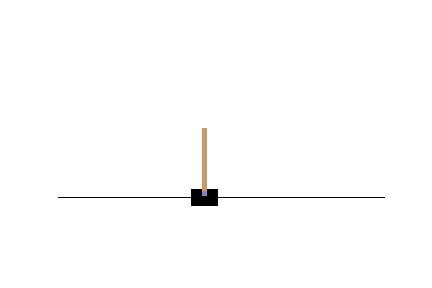
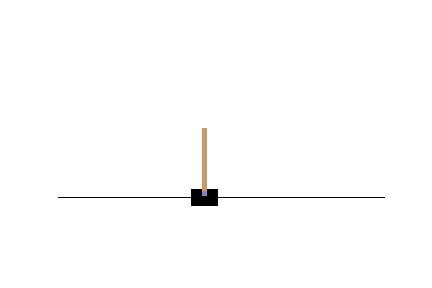
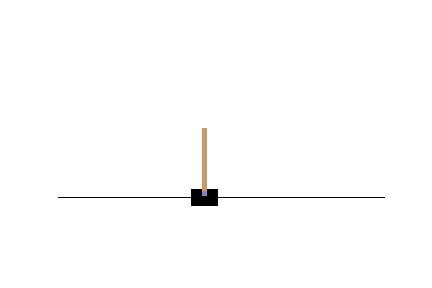
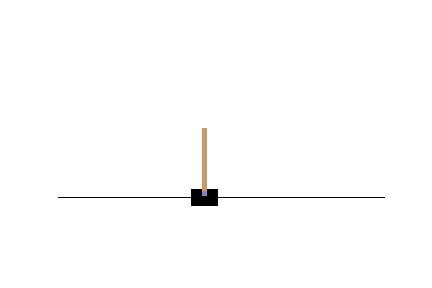
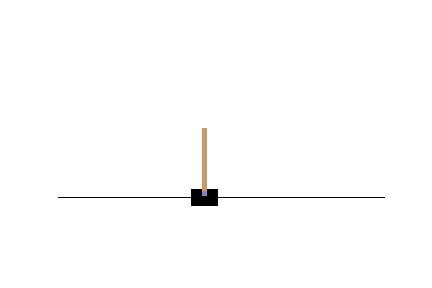
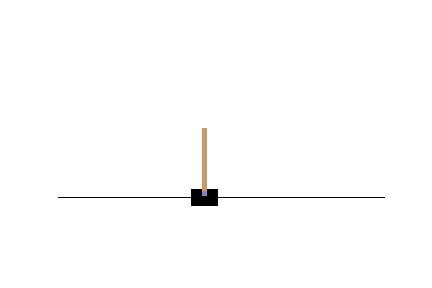
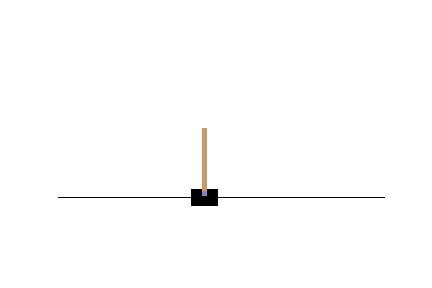
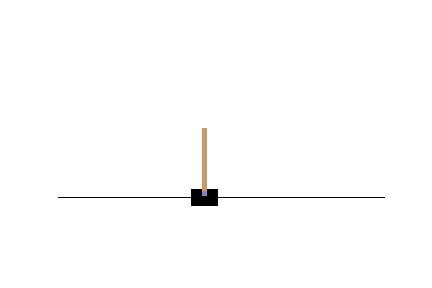
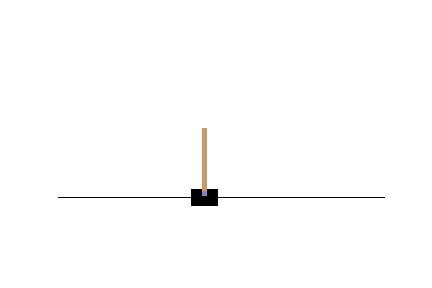
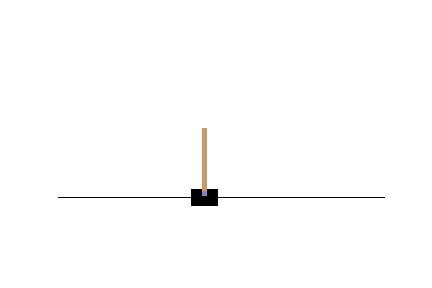
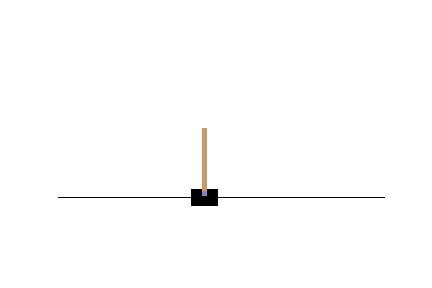
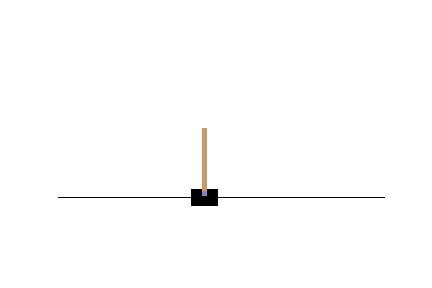
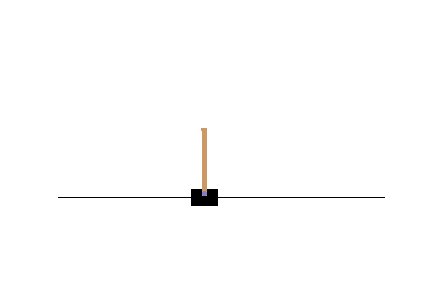
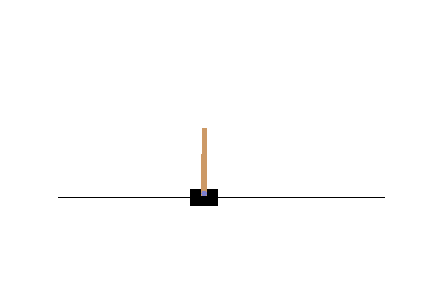
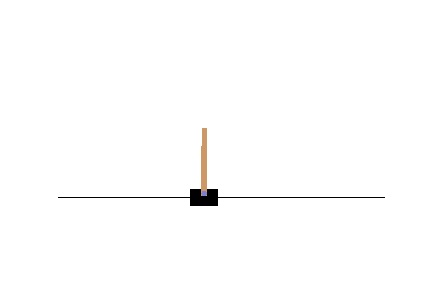
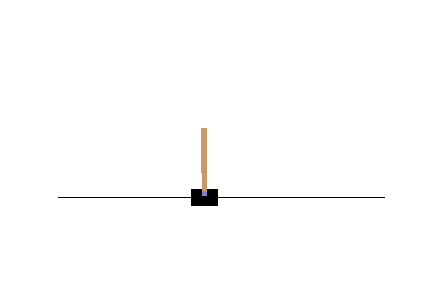
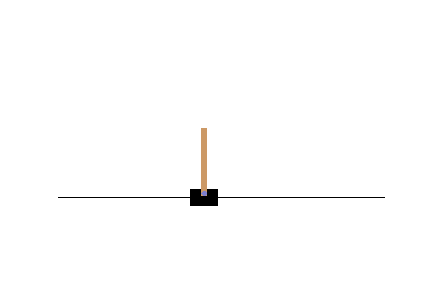
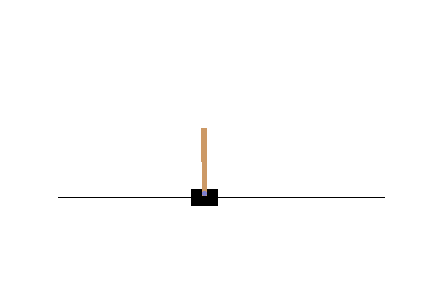
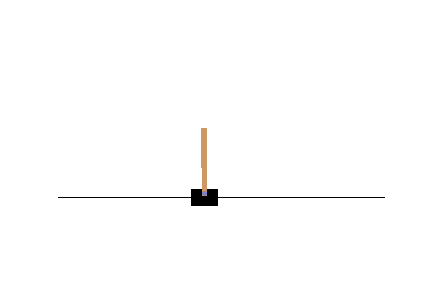
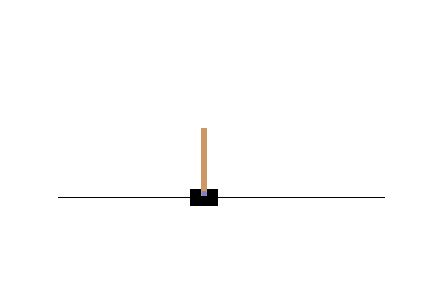
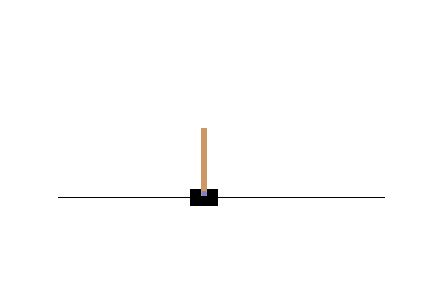
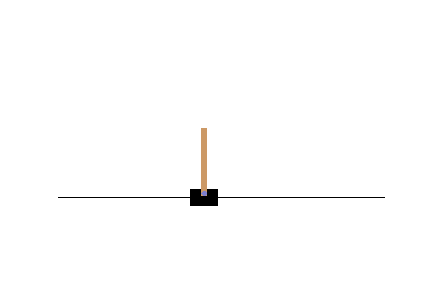
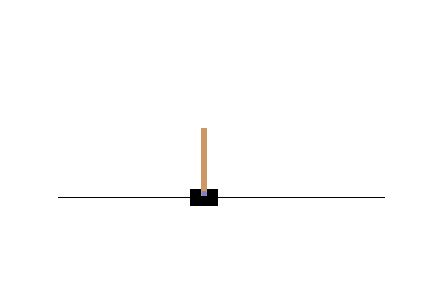
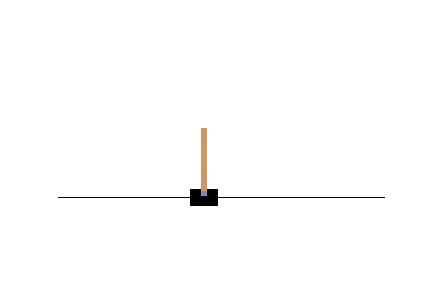
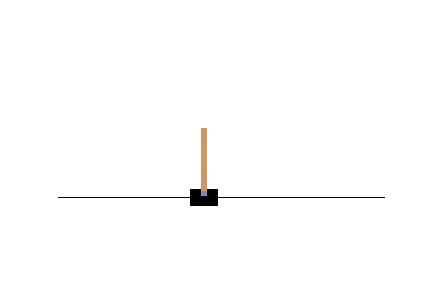
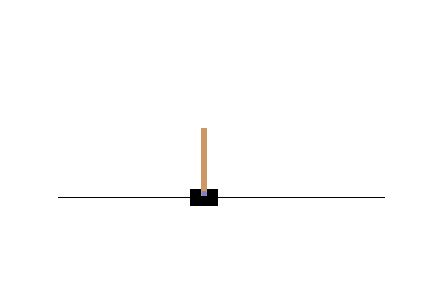
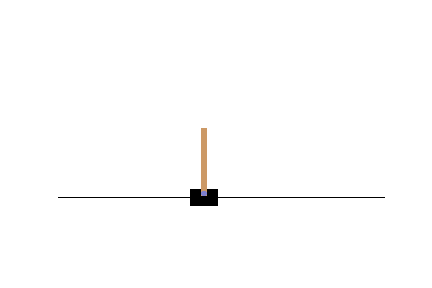
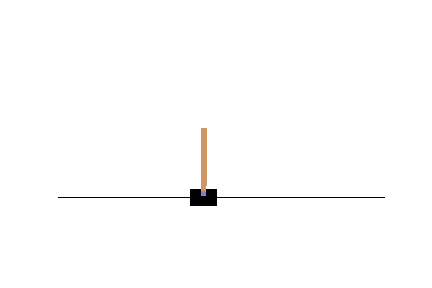
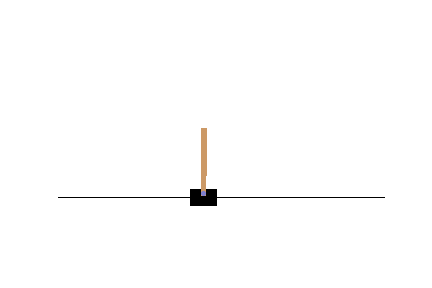
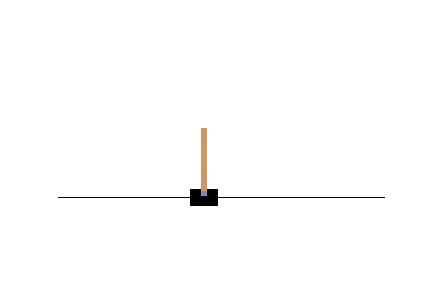
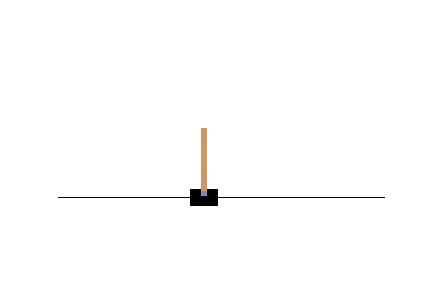
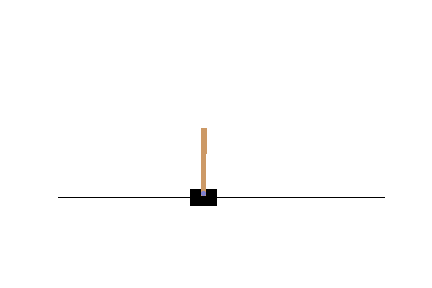
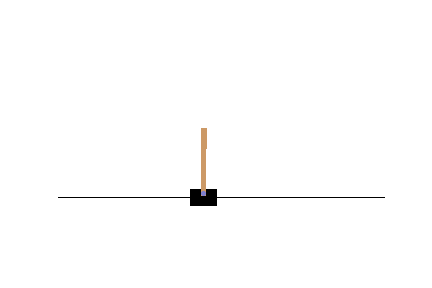
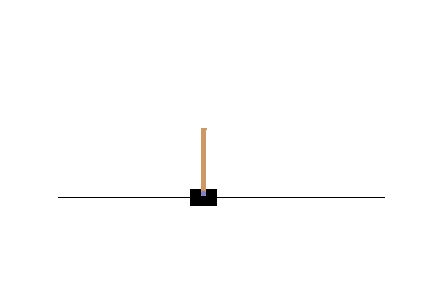
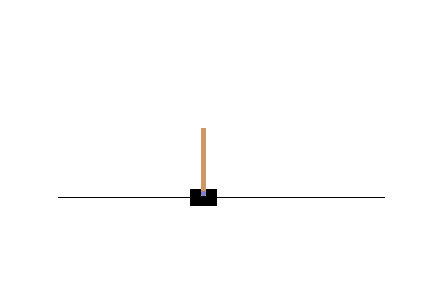
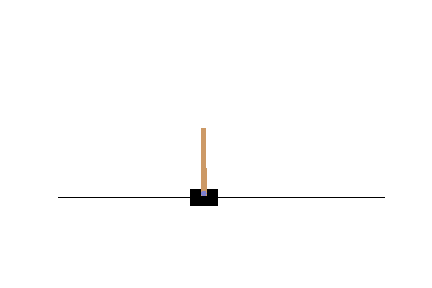
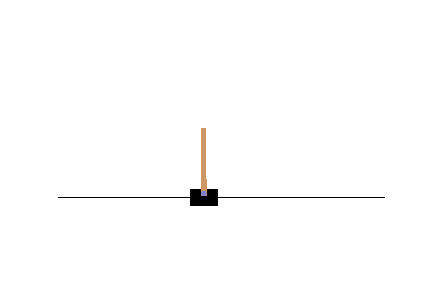
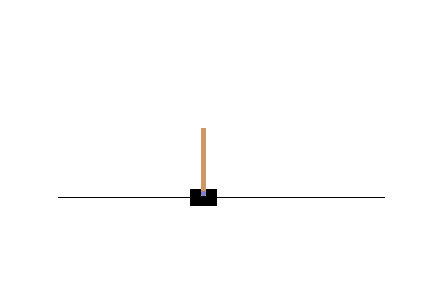
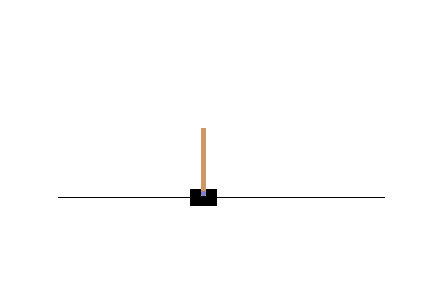
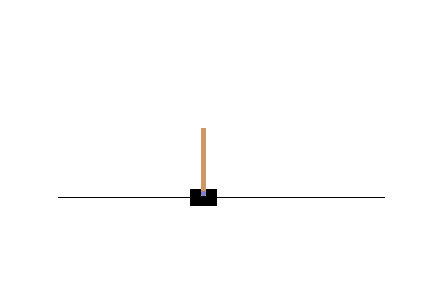
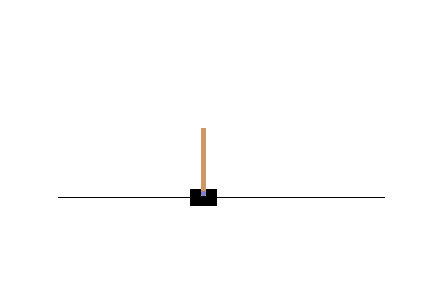
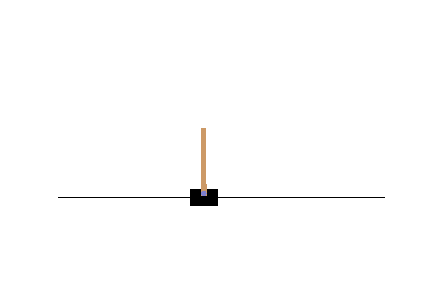
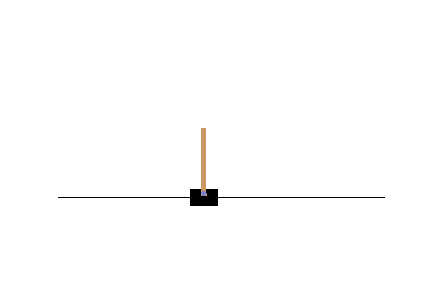
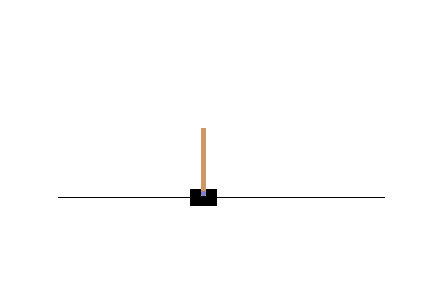
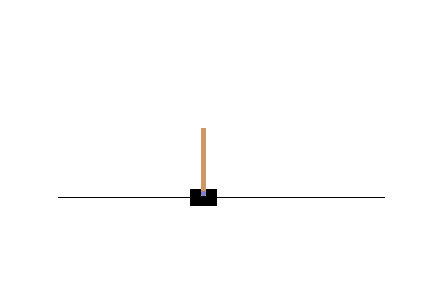
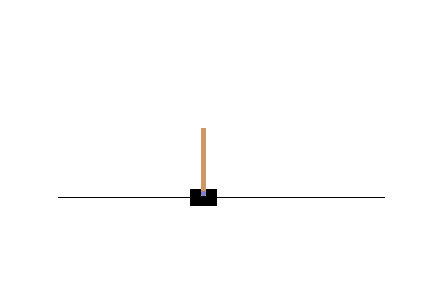
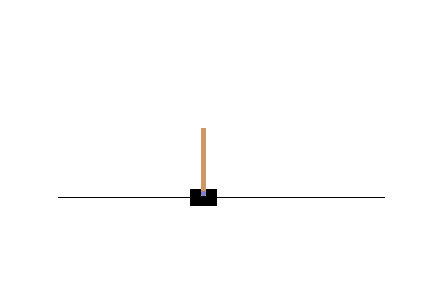
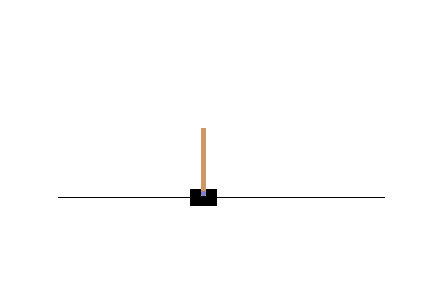
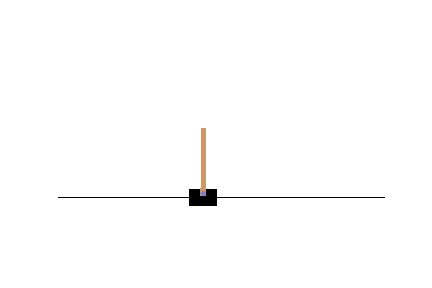
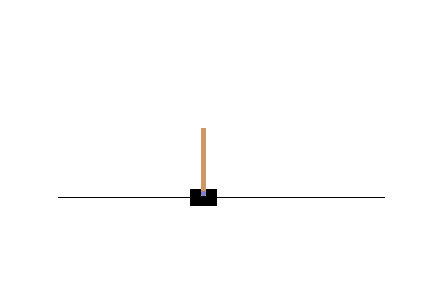
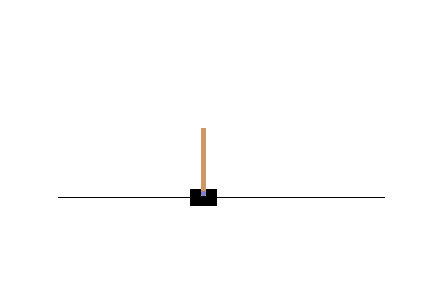
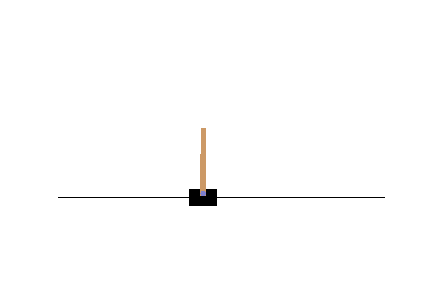
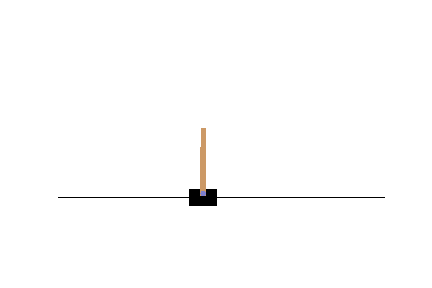
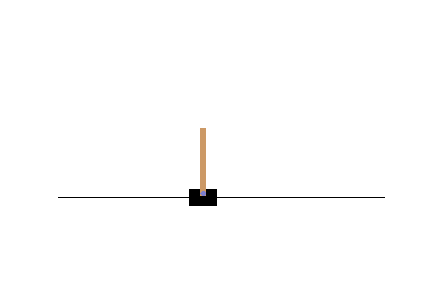
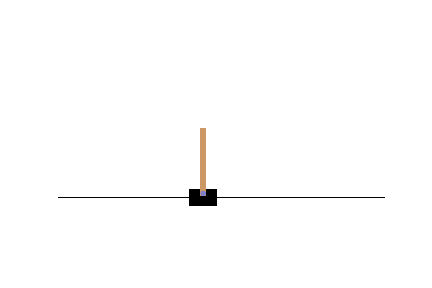
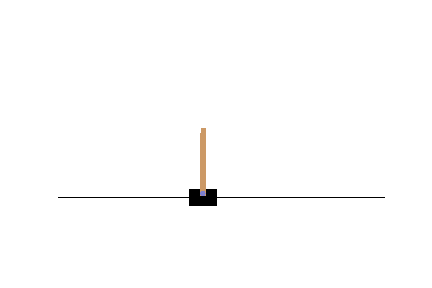
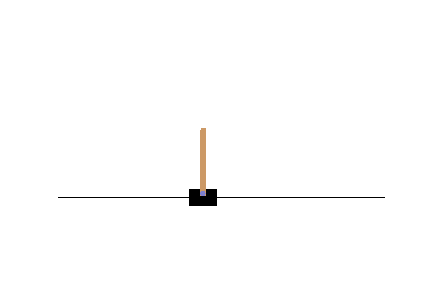

In [19]:
env = gym.make('CartPole-v1')
obs = env.reset()
total_reward = 0
frames = []
for t in range(10000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    obs = obs.astype(np.float32).reshape((1, -1))
    action = agent.control(obs)
    obs, reward, done, info = env.step(action)
    total_reward += reward
    if done:
        break
env.close()
print('Total Reward : %.2f'%total_reward)
display_frames_as_gif(frames)

# TRPOAgent with Gaussian policy

## KL divergence between two Gaussian

### $D_{kl}(\;\pi_{old}(\cdot|s) \;| \;\pi_{new}(\cdot|s)\;)=\int \pi_{old}(a|s) \log(\frac{\pi_{new}(a|s)}{\pi_{old}(a|s)}) da$

### If $\pi(\cdot|s) = \mathcal{N}( \mu(s), \Sigma)$ where $\Sigma$ is a diagonal matrix, i.e., $\Sigma = [(\sigma^{i})^2]$, then

### $D_{kl}(\;\pi_{old}(\cdot|s) \;| \;\pi_{new}(\cdot|s)\;)=\sum_{i=1}^{D} \left[\log(\sigma_{new}^{i}) - \log(\sigma_{old}^{i}) + \frac{1}{2}\left(\frac{\sigma_{old}^{i}}{\sigma_{new}^{i}}\right)^{2} + \frac{(\mu_{new}^{i}(s) - \mu_{old}^{i}(s))^{2}}{2(\sigma_{new}^{i})^2} - \frac{1}{2}\right]$
### where $i$ indicates the $i$th demesion

### We approximate KL divergence using sampling

### $D_{kl}^{\rho}(\; \pi_{old}\;|\;\pi_{new}\;) \approx \frac{1}{N} \sum_{i} D_{kl}(\;\pi_{old}(\cdot|s_i)\;|\;\pi_{new}(\cdot|s_i)\;)$

In [22]:
class TRPOAgent_gaussian(object):
    def __init__(self, obs_dim, act_dim,
                 hdim=64, max_std=5.0,
                 cg_damping=1e-3, max_kl=0.01,
                 seed=0):
        
        self.seed=seed
        
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        
        self.hdim = hdim
        self.max_std = max_std
        
        self.cg_damping = cg_damping
        self.max_kl = max_kl
        
        self._build_graph()
        
    def _build_graph(self):
        self.g = tf.Graph()
        with self.g.as_default():
            self._placeholders()
            self._policy_nn()
            self._logprob()
            self._loss()
            self._kl_entropy()
            self._trpo_optimizer()
            
            self.init = tf.global_variables_initializer()
            self._init_session()
            
    def _placeholders(self):
        # observations, actions and advantages:
        self.obs_ph = tf.placeholder(tf.float32, (None, self.obs_dim), 'obs')
        self.act_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'act')
        self.scores_ph = tf.placeholder(tf.float32, (None,), 'scores')
        
        # place holder for old parameters
        self.old_std_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'old_std')
        self.old_mean_ph = tf.placeholder(tf.float32, (None, self.act_dim), 'old_means')

    def _policy_nn(self):
        
        hid1_size = self.hdim
        hid2_size = self.hdim
        
        # TWO HIDDEN LAYERS
        out = tf.layers.dense(self.obs_ph, hid1_size, tf.tanh,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h1")
        out = tf.layers.dense(out, hid2_size, tf.tanh,
                              kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), name="h2")
        
        # MEAN FUNCTION
        self.mean = tf.layers.dense(out, self.act_dim,
                                kernel_initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed), 
                                name="mean")
        # UNI-VARIATE
        self.logits_std = tf.get_variable("logits_std",shape=(1,),initializer=tf.random_normal_initializer(stddev=0.01,seed= self.seed))
        self.std = self.max_std*tf.ones_like(self.mean)*tf.sigmoid(self.logits_std) # IMPORTANT TRICK
        
        # SAMPLE OPERATION
        self.sample_action = self.mean + tf.random_normal(tf.shape(self.mean),seed=self.seed)*self.std
        
    def _logprob(self):
        # PROBABILITY WITH TRAINING PARAMETER
        y = self.act_ph 
        mu = self.mean
        sigma = self.std
        
        self.logp = tf.reduce_sum(-0.5*tf.square((y-mu)/sigma)-tf.log(sigma)- 0.5*np.log(2.*np.pi),axis=1)

        # PROBABILITY WITH OLD (PREVIOUS) PARAMETER
        old_mu_ph = self.old_mean_ph
        old_sigma_ph = self.old_std_ph
                
        self.logp_old = tf.reduce_sum(-0.5*tf.square((y-old_mu_ph)/old_sigma_ph)-tf.log(old_sigma_ph)- 0.5*np.log(2.*np.pi),axis=1)
    def _loss(self):
        
        # Proximal Policy Optimization CLIPPED LOSS FUNCTION
        ratio = tf.exp(self.logp - self.logp_old) 
        self.loss = -tf.reduce_mean(self.scores_ph*ratio)
        
    def _kl_entropy(self):

        mean, std = self.mean, self.std
        old_mean, old_std = self.old_mean_ph, self.old_std_ph
 
        log_std_old = tf.log(old_std)
        log_std_new = tf.log(std)
        frac_std_old_new = old_std/std

        # KL DIVERGENCE BETWEEN TWO GAUSSIAN
        kl = tf.reduce_sum(log_std_new - log_std_old + 0.5*tf.square(frac_std_old_new) + 0.5*tf.square((mean - old_mean)/std)- 0.5,axis=1)
        self.kl = tf.reduce_mean(kl)
        
        # ENTROPY OF GAUSSIAN
        entropy = tf.reduce_sum(log_std_new + 0.5 + 0.5*np.log(2*np.pi),axis=1)
        self.entropy = tf.reduce_mean(entropy)
         
    def _trpo_optimizer(self):
        # GRADIENT OF KL
        var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        
        self.flat_var = tf.concat([tf.reshape(v, [np.prod(v.shape)]) for v in var_list], 0)
        
        pg_grads = tf.gradients(self.loss, var_list)
        self.pg = tf.concat([tf.reshape(pg_grad, [np.prod(v.shape)]) for (v, pg_grad) in zip(var_list, pg_grads)], 0)
        
        grads = tf.gradients(self.kl, var_list)
        self.flat_tangent = tf.placeholder(tf.float32, shape=(None))
        shapes = [v.shape for v in var_list]
        start = 0
        tangents = []
        for shape in shapes:
            size = int(np.prod(shape))
            param = tf.reshape(self.flat_tangent[start:(start + size)], shape)
            tangents.append(param)
            start += size
        gvp = [tf.reduce_sum(g * t) for (g, t) in zip(grads, tangents)]
        
        gvp_grads = tf.gradients(gvp, var_list)
        self.fvp =  tf.concat([tf.reshape(gvp_grad, [np.prod(v.shape)]) for (v, gvp_grad) in zip(var_list, gvp_grads)], 0)
        
        assigns = []
        total_size = sum(int(np.prod(shape)) for shape in shapes)
        self.theta = tf.placeholder(tf.float32, shape=(total_size))
        start = 0
        for (shape, v) in zip(shapes, var_list):
            size = int(np.prod(shape))
            assigns.append(v.assign(tf.reshape(self.theta[start:start+size],shape)))
            start += size
        self.set_from_flat = assigns
        
    def _init_session(self):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        self.sess = tf.Session(config=config,graph=self.g)
        self.sess.run(self.init)

    def get_action(self, obs): # SAMPLE FROM POLICY
        feed_dict = {self.obs_ph: obs}
        sampled_action, = self.sess.run(self.sample_action,feed_dict=feed_dict)
        return sampled_action
    
    def control(self, obs): # COMPUTE MEAN
        obs = obs.squeeze()
        feed_dict = {self.obs_ph: [obs]}
        best_action = self.sess.run(self.mean,feed_dict=feed_dict)
        return best_action        
    
    def update(self, observes, actions, scores): # TRAIN POLICY
        
        old_means_np, old_std_np = self.sess.run([self.mean, self.std],{self.obs_ph: observes}) # COMPUTE OLD PARAMTER
        feed_dict = {self.obs_ph: observes,
                     self.act_ph: actions,
                     self.scores_ph: scores,
                     self.old_mean_ph: old_means_np,
                     self.old_std_ph: old_std_np}          

        thprev = self.sess.run(self.flat_var)

        def hessian_vector_product(p):
            feed_dict[self.flat_tangent] = p
            return self.sess.run(self.fvp, feed_dict) + p * self.cg_damping

        g = self.sess.run(self.pg, feed_dict=feed_dict)
        stepdir = conjugate_gradient(hessian_vector_product, -g)
        shs = (.5 * stepdir.dot(hessian_vector_product(stepdir)) )

        lm = np.sqrt(shs/ self.max_kl) 

        fullstep = stepdir / lm
        expectedimprove = g.dot(fullstep)
        surrbefore = self.sess.run(self.loss, feed_dict=feed_dict)
        stepsize = 1.

        for _ in range(5):
            thnew = thprev + fullstep * stepsize
            self.sess.run(self.set_from_flat, feed_dict={self.theta:thnew})

            surr, kl = self.sess.run([self.loss, self.kl], feed_dict=feed_dict)
            improve = surr - surrbefore

            if not np.isfinite(surr).all():
                self.sess.run(self.set_from_flat, feed_dict={self.theta:thprev})
                break
            elif kl > self.max_kl * 1.5:
                stepsize *= .5
            elif improve < 0:
                stepsize *= .5
            else:
                break
          
        loss,kl,entropy  = self.sess.run([self.loss,self.kl,self.entropy], feed_dict)
        return loss,kl,entropy
    
    def close_sess(self):
        self.sess.close()

# Training

In [23]:
env = gym.make('MountainCarContinuous-v0')

np.random.seed(seed)
tf.set_random_seed(seed)
env.seed(seed=seed)

obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]

agent = TRPOAgent_gaussian(obs_dim, act_dim, hdim=64, max_kl=0.03,max_std=1.0,seed=seed)

avg_return_list = deque(maxlen=10)
avg_loss_list = deque(maxlen=10)

episode_size = 1
nupdates = 600

for update in range(nupdates+1):

    trajectories = run_policy(env, agent, episodes=episode_size)
    compute_returns(trajectories)
    observes, actions, returns = build_train_set(trajectories)
    pol_loss, kl, entropy = agent.update(observes, actions, returns)
    
    avg_loss_list.append(pol_loss)
    avg_return_list.append([np.sum(t['rewards']) for t in trajectories])
    if (update%100) == 0:
        print('[{}/{}] return : {:.3f}, policy loss : {:.3f}, policy kl : {:.5f}, policy entropy : {:.3f}'.format(update, nupdates, np.mean(avg_return_list), np.mean(avg_loss_list), kl, entropy))
        
    if (np.mean(avg_return_list) > 90): # Threshold return to success cartpole 
        print('[{}/{}] return : {:.3f}, policy loss : {:.3f}'.format(update,nupdates, np.mean(avg_return_list), np.mean(avg_loss_list)))
        print('The problem is solved with {} episodes'.format(update*episode_size))
        break

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
[0/600] return : -25.002, policy loss : 3.945, policy kl : 0.00011, policy entropy : 0.715
[100/600] return : 74.812, policy loss : -30.136, policy kl : 0.00013, policy entropy : 0.631
[126/600] return : 90.023, policy loss : -43.326
The problem is solved with 126 episodes


# Evaluation

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Total Reward : 98.05



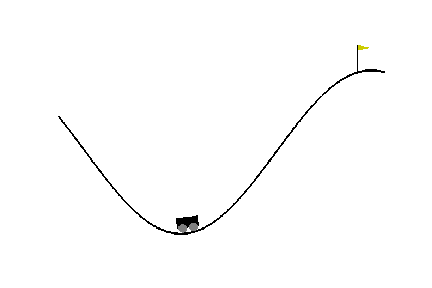
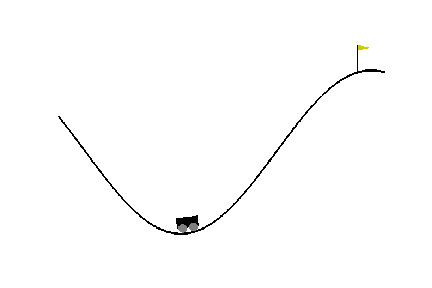
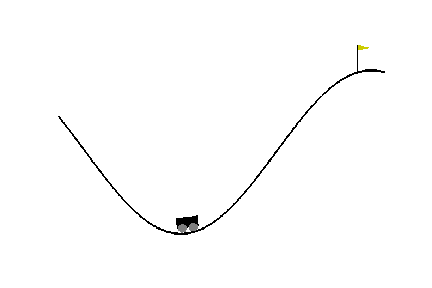
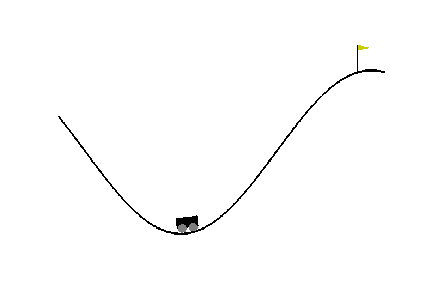
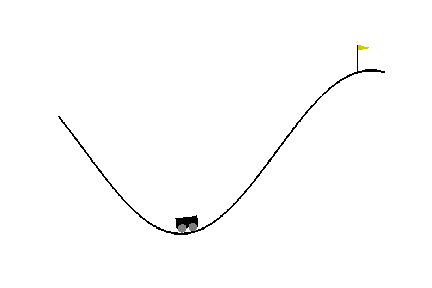
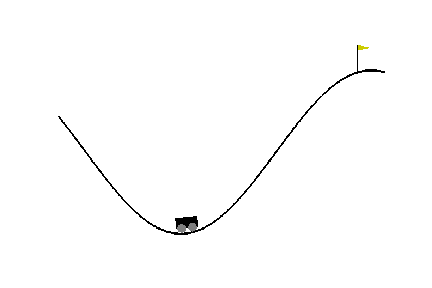
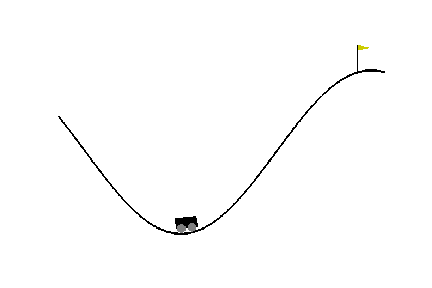
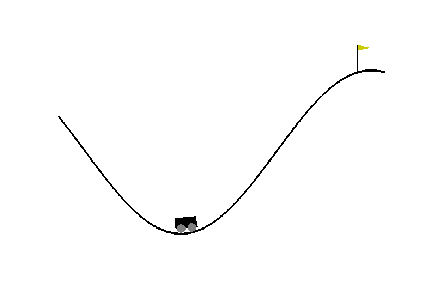
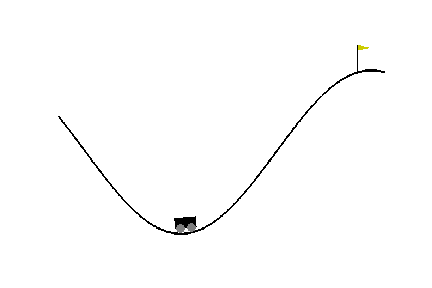
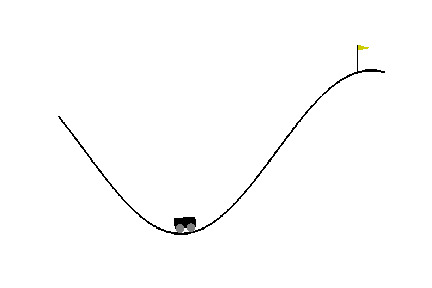
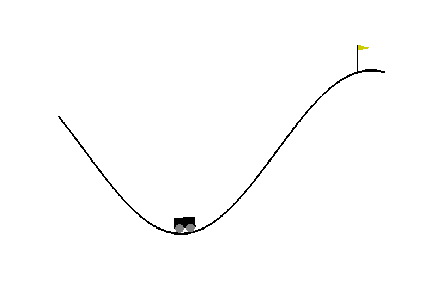
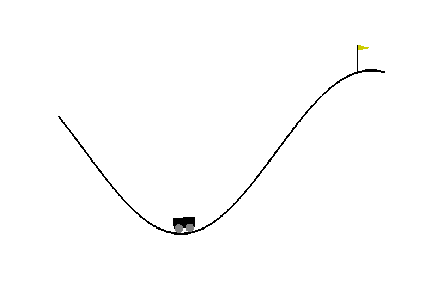
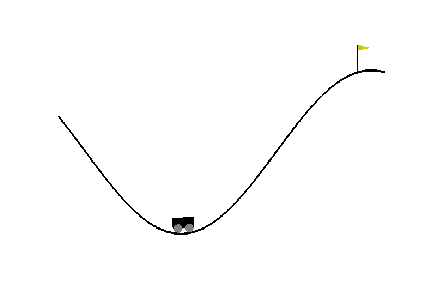
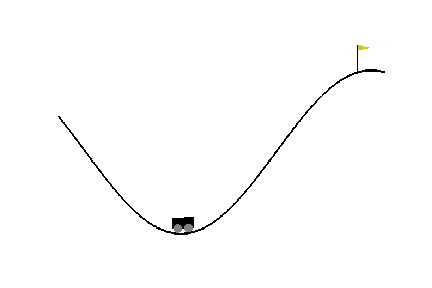
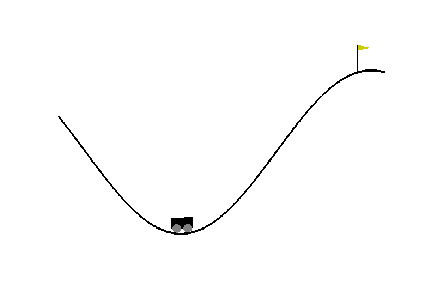
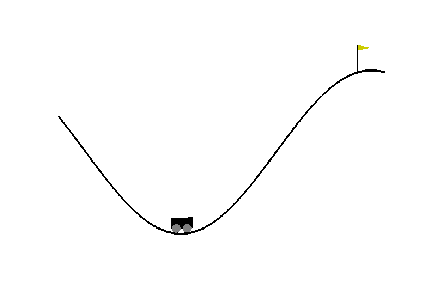
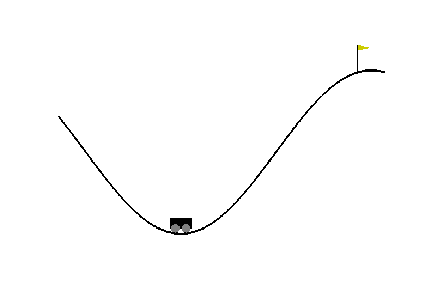
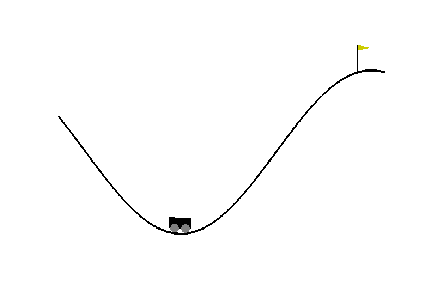
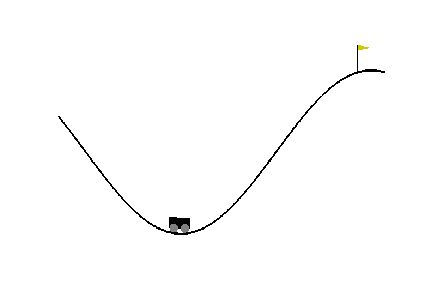
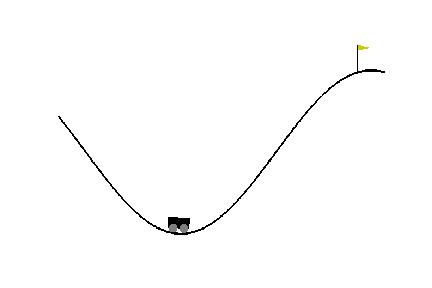
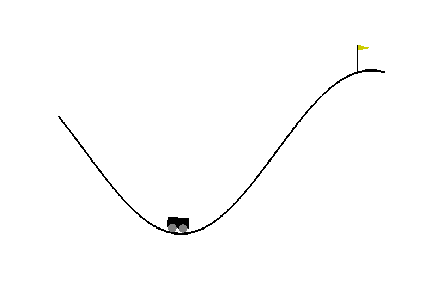
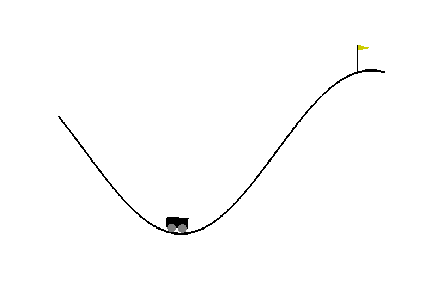
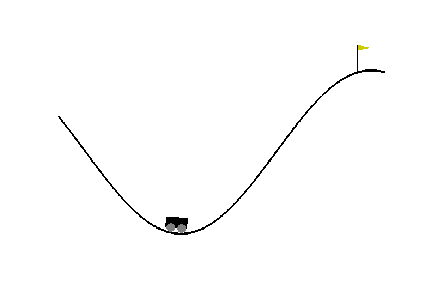
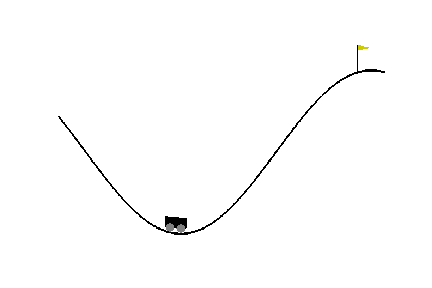
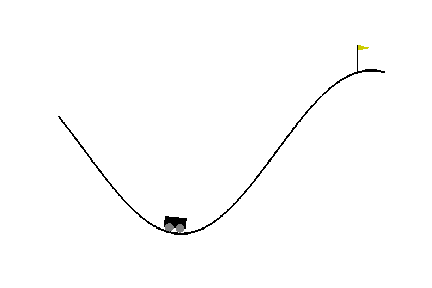
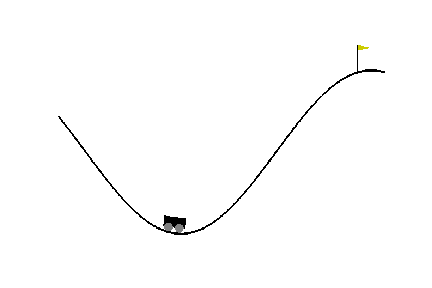
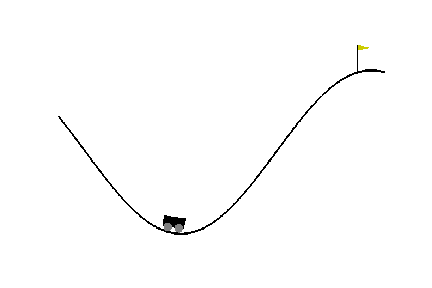
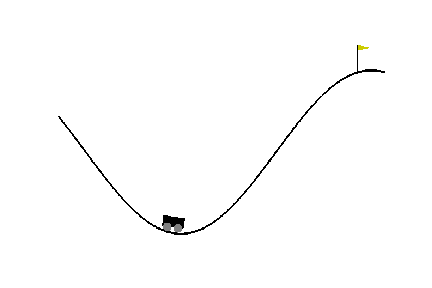
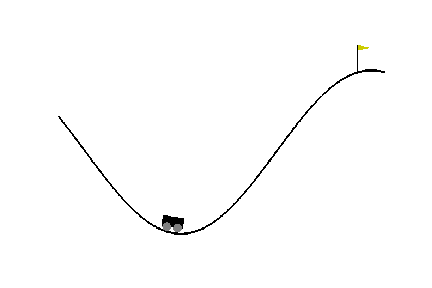
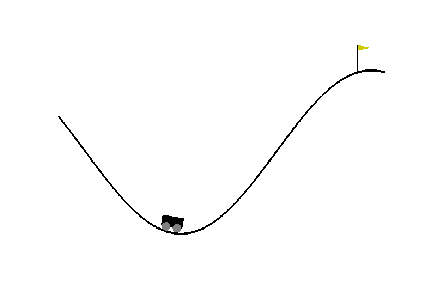
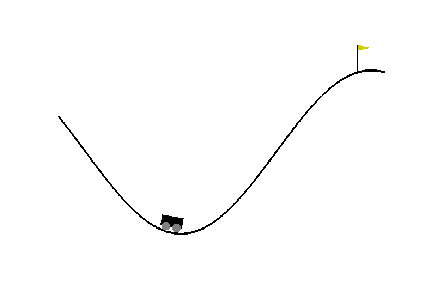
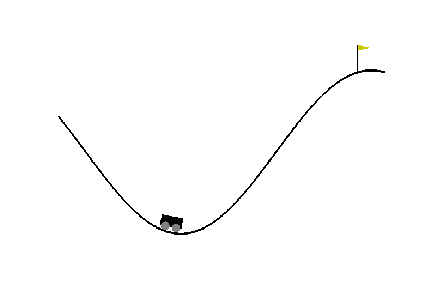
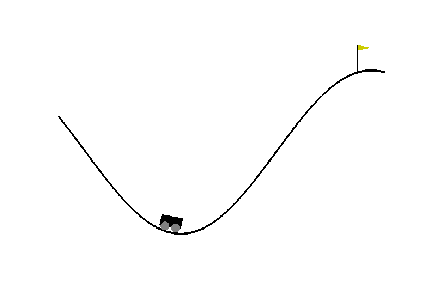
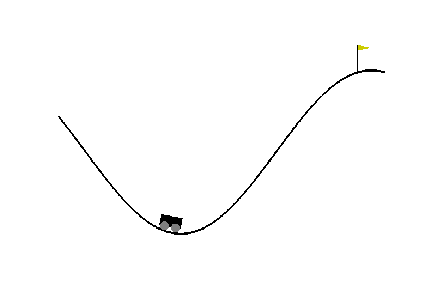
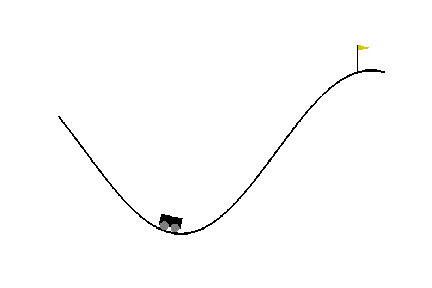
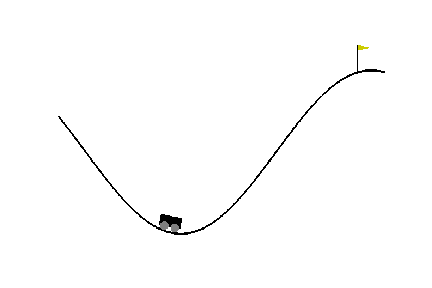
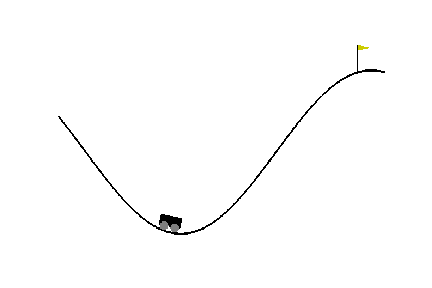
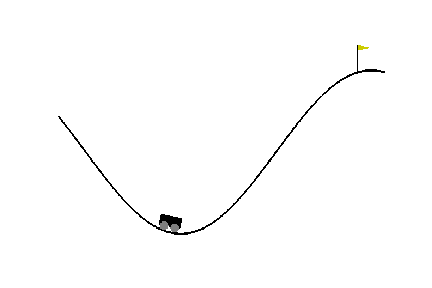
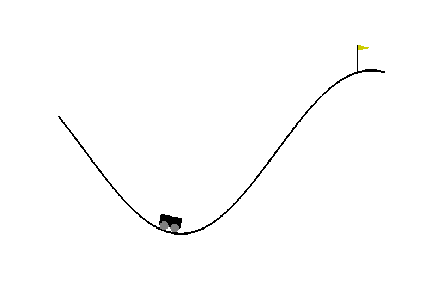
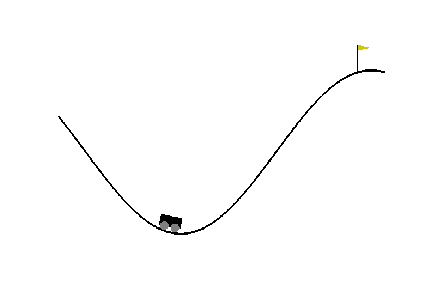
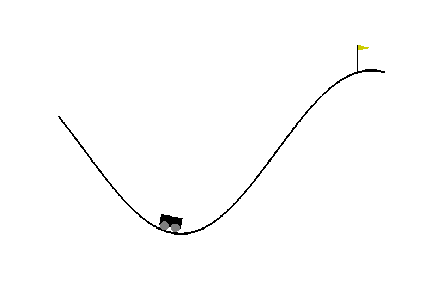
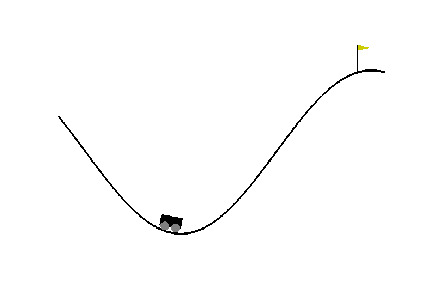
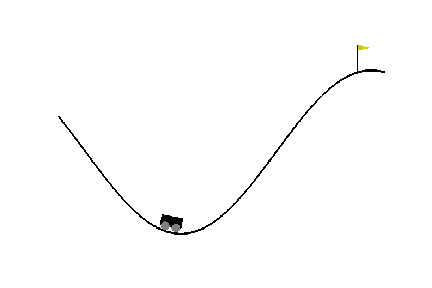
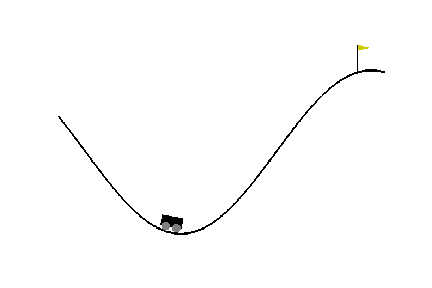
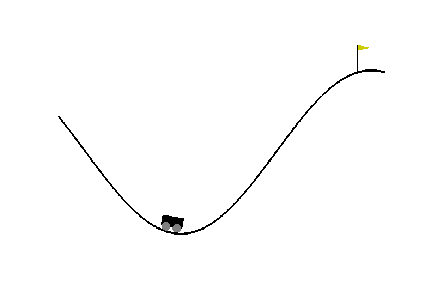
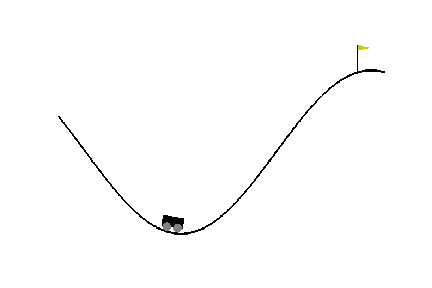
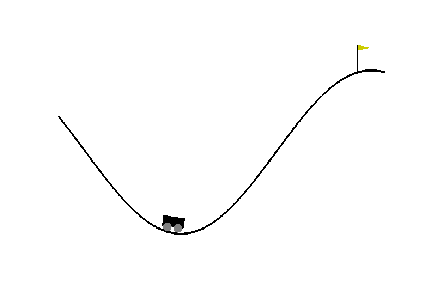
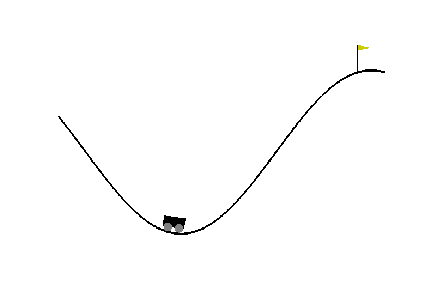
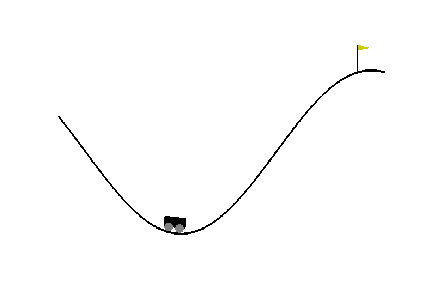
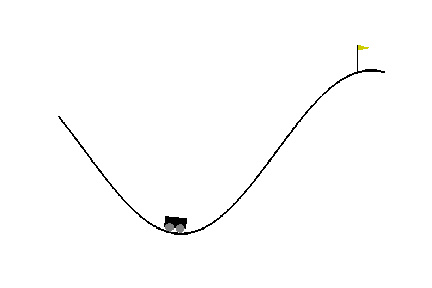
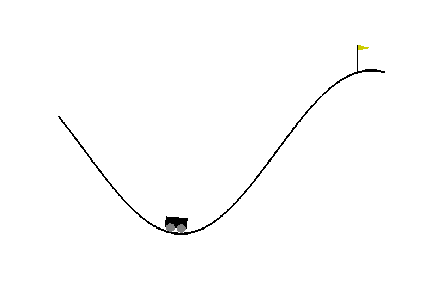
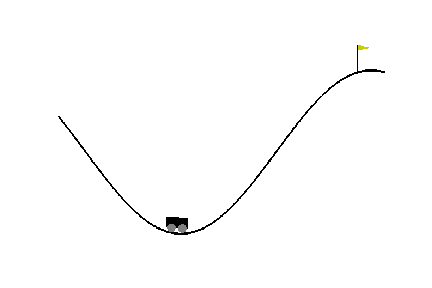
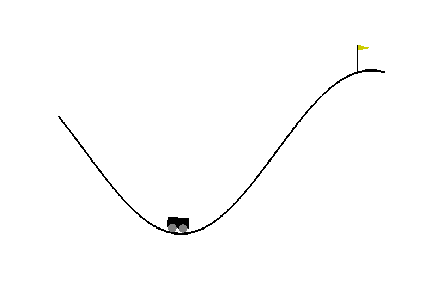
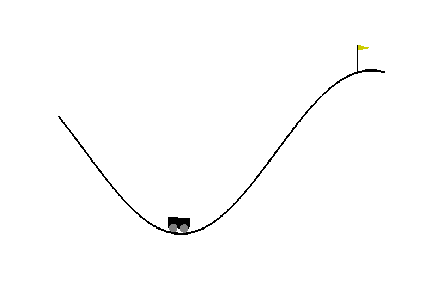
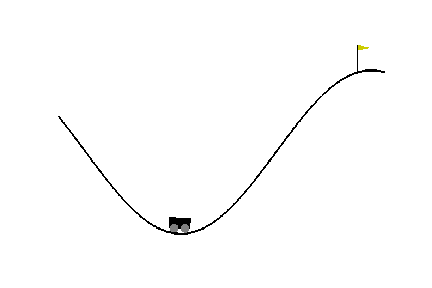
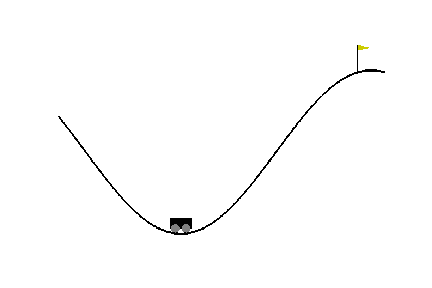
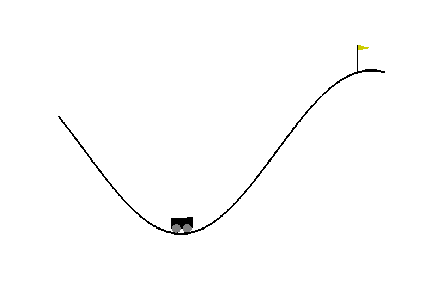
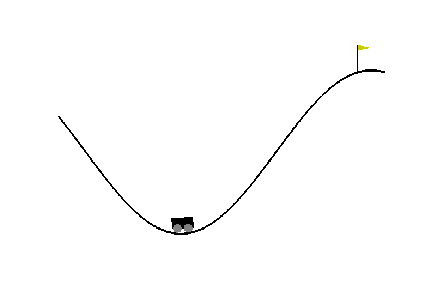
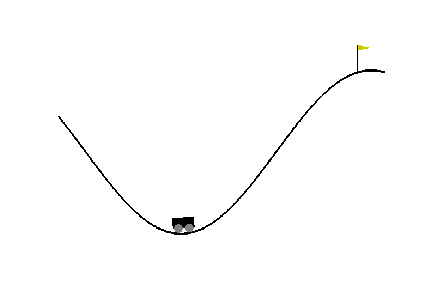
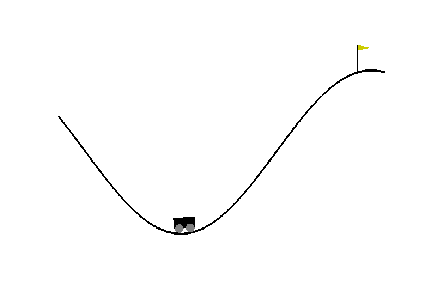
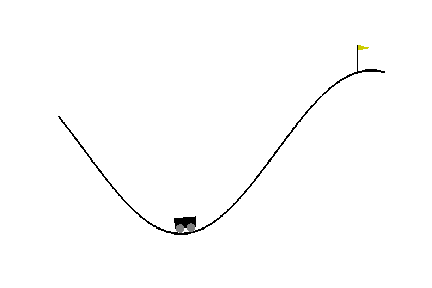
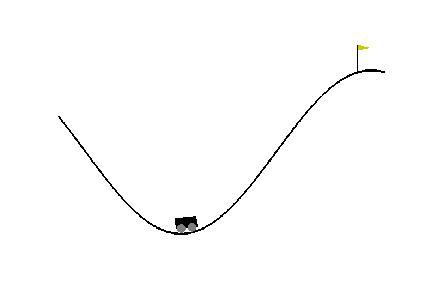
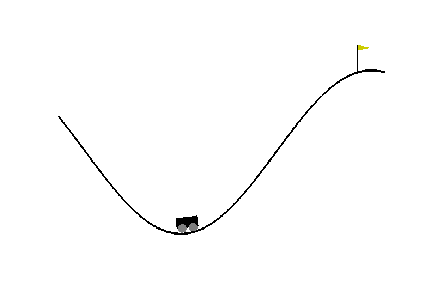
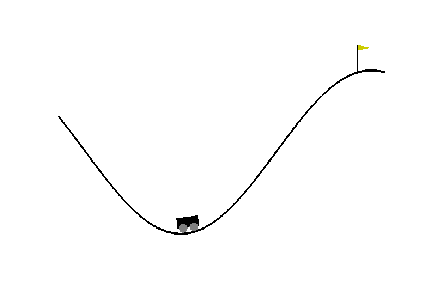
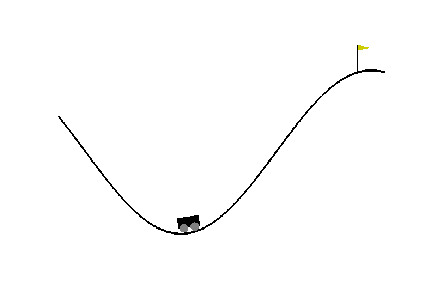
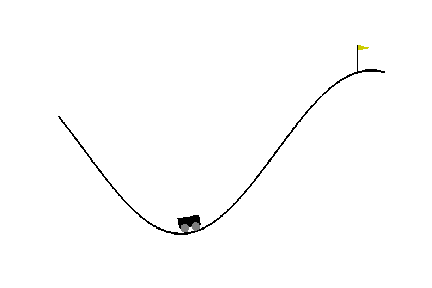
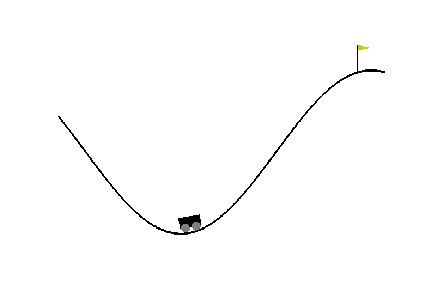
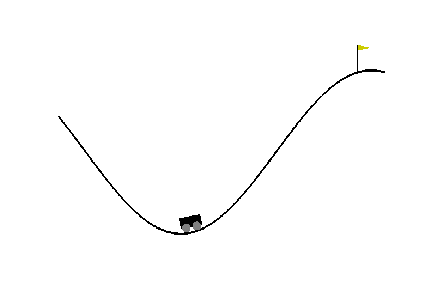
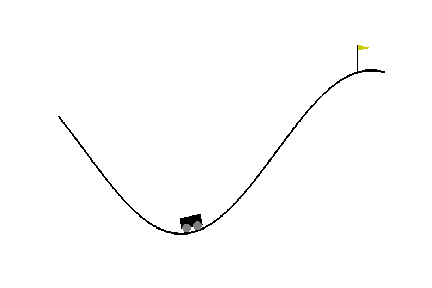
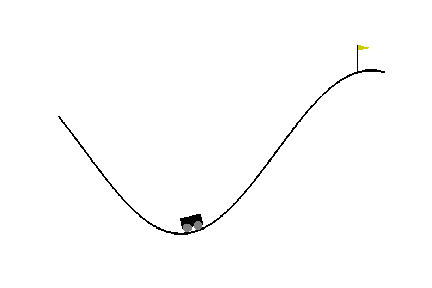
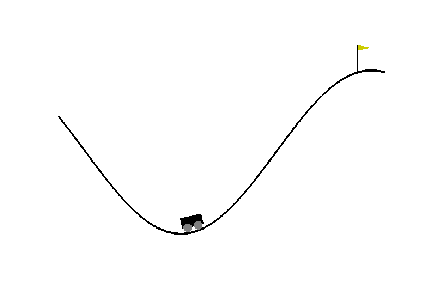
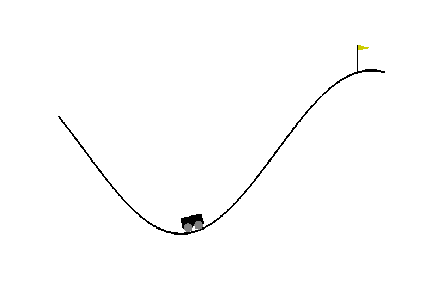
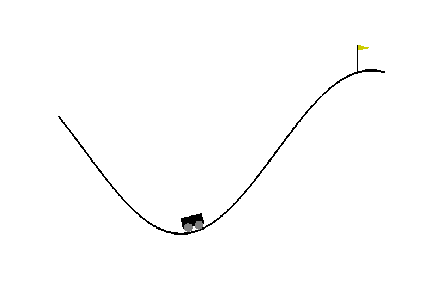
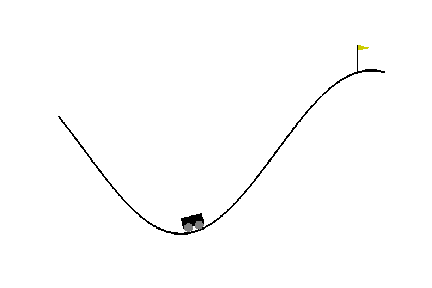
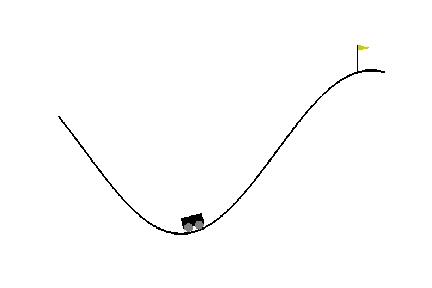
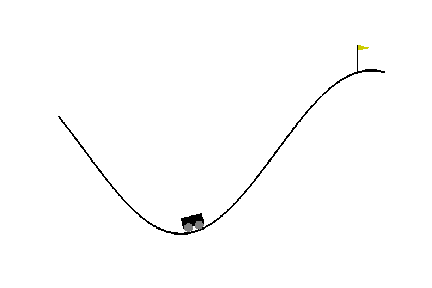
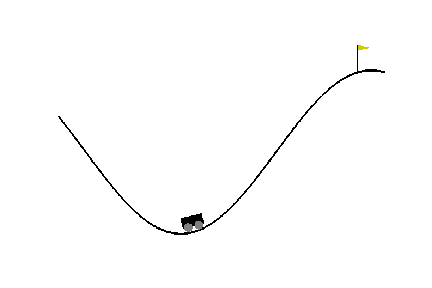
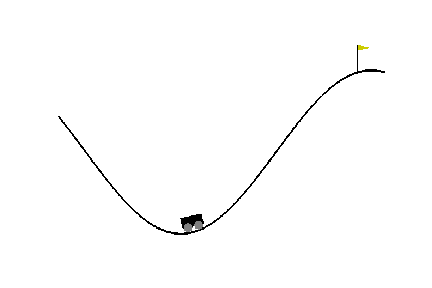
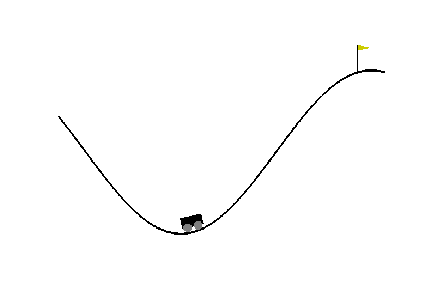
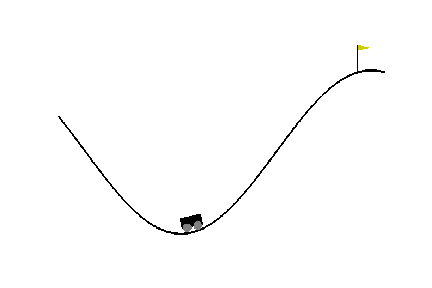
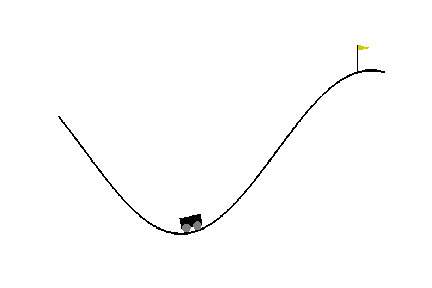
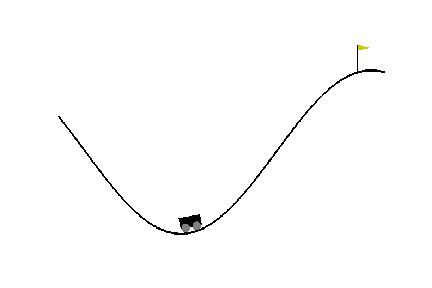
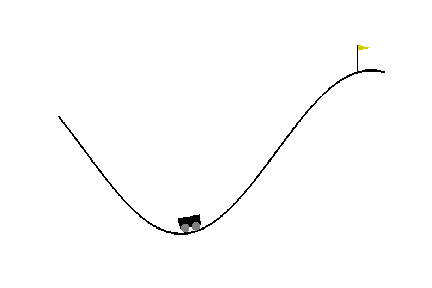
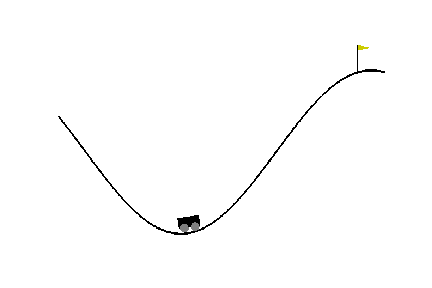
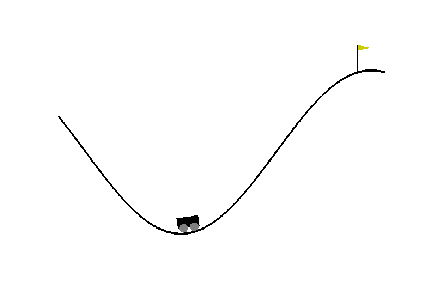
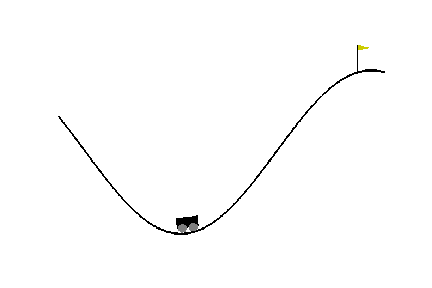
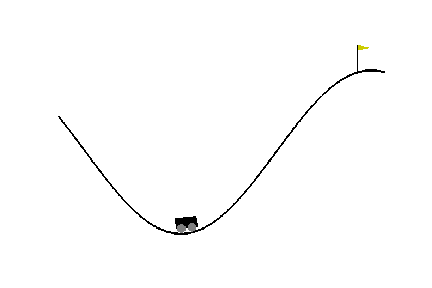
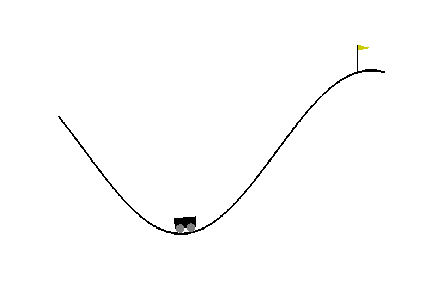
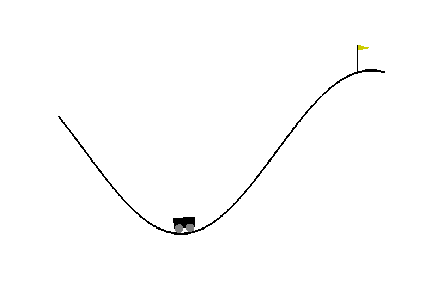
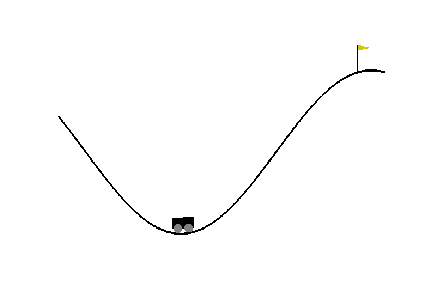
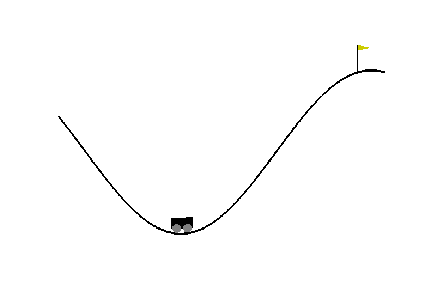
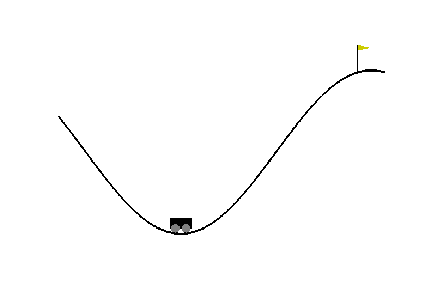
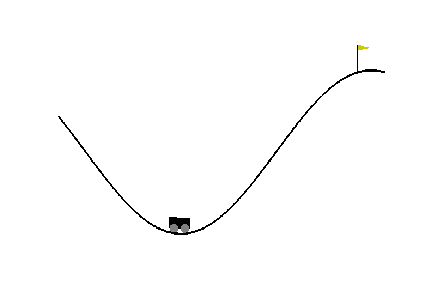
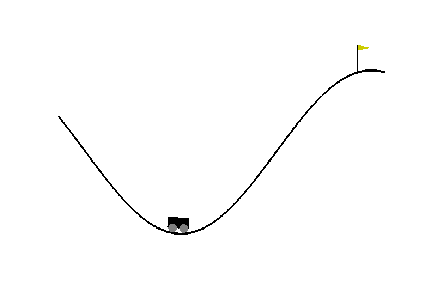
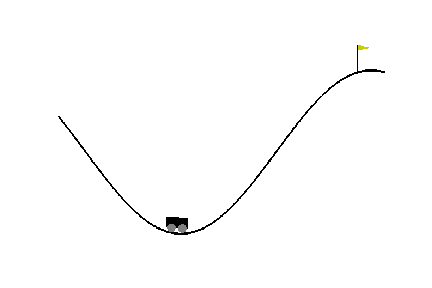
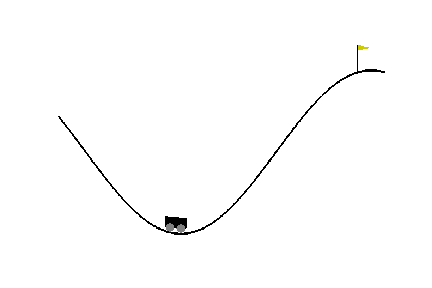
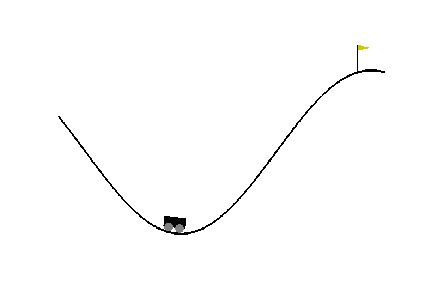
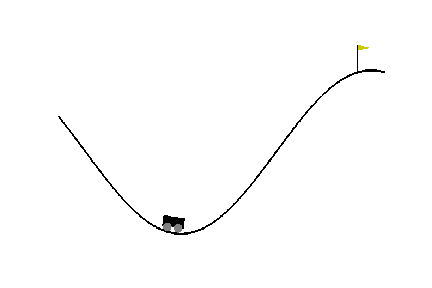
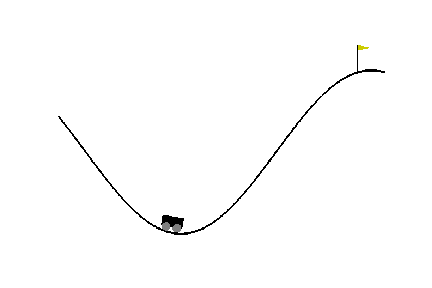
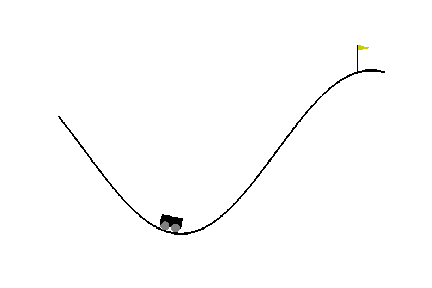
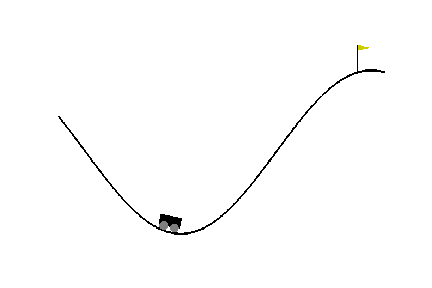
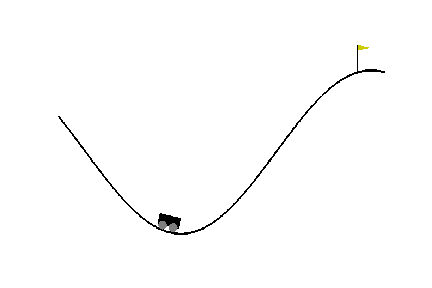
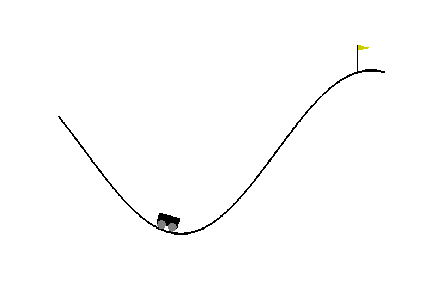
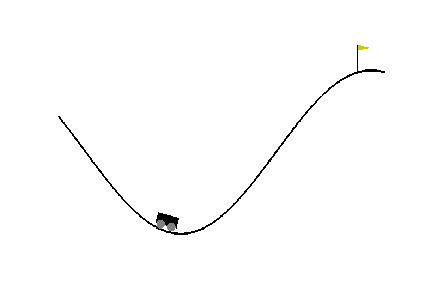
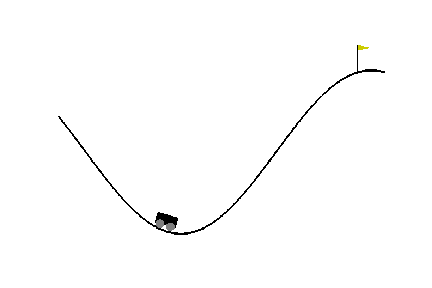
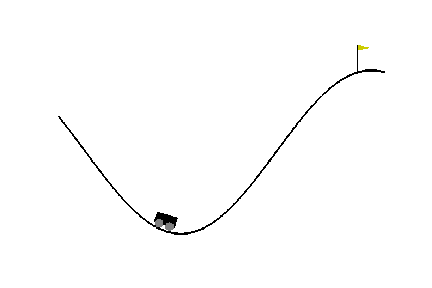
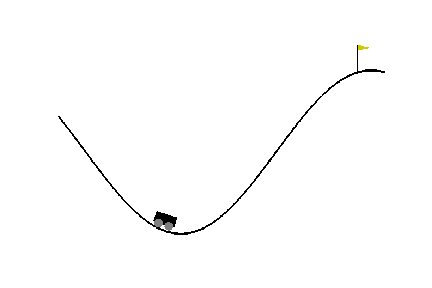
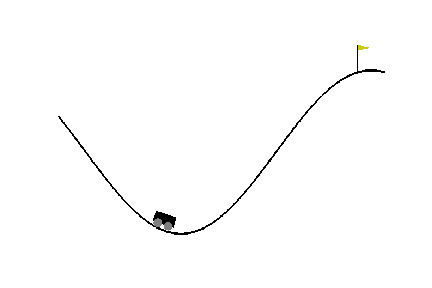
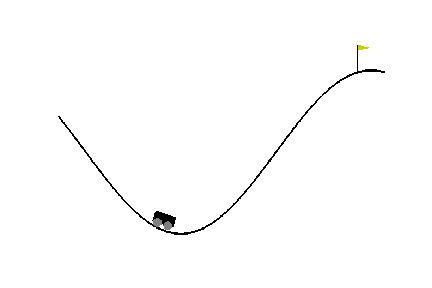
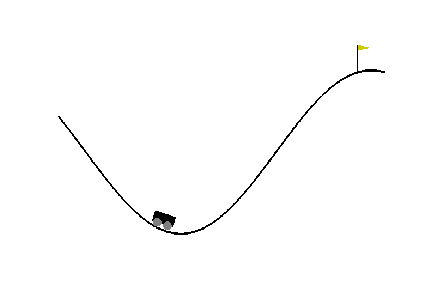
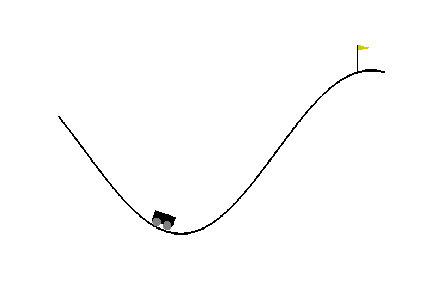
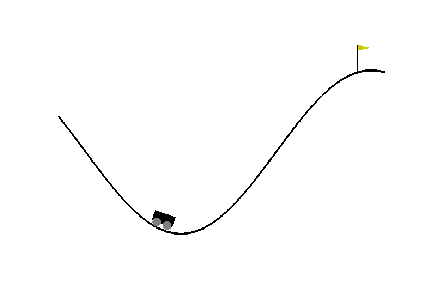
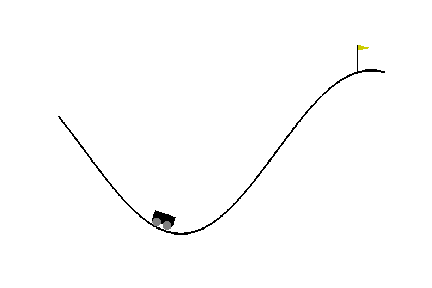
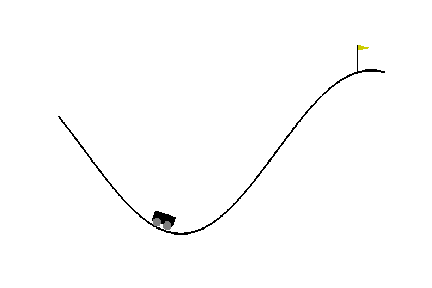
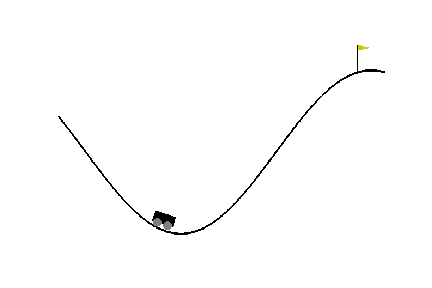
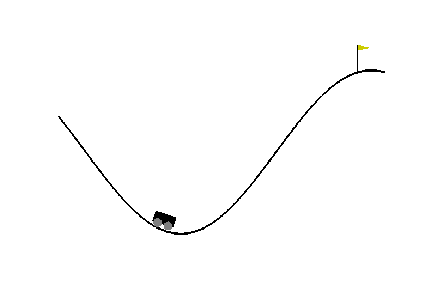
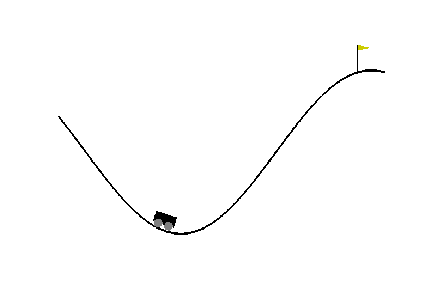
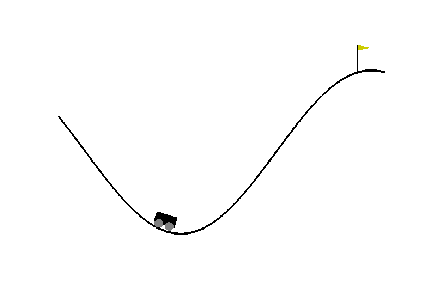
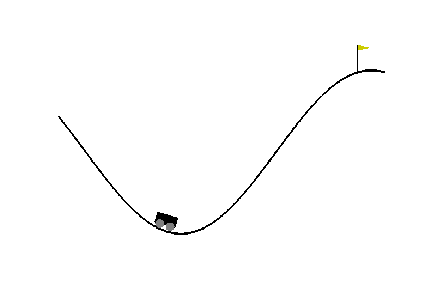
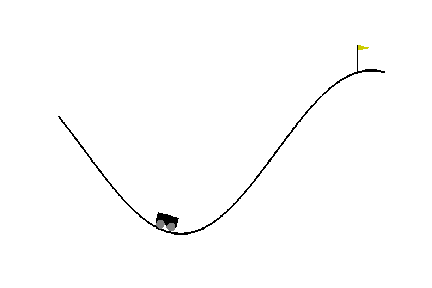
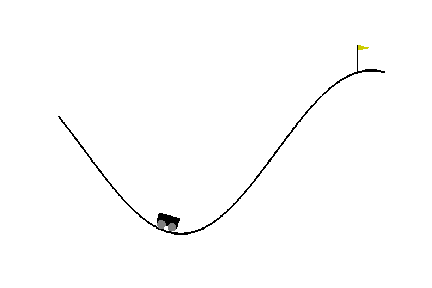
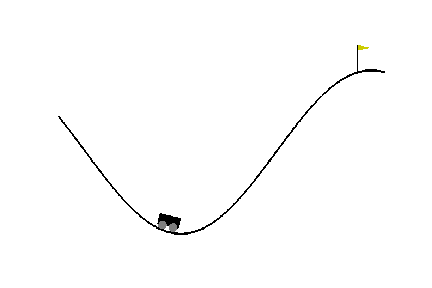
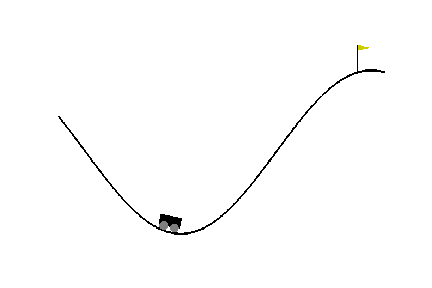
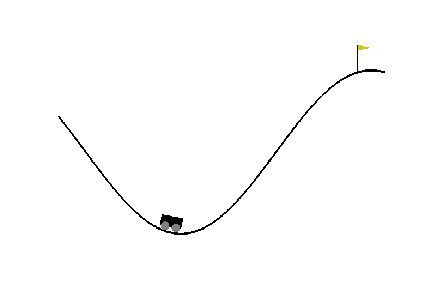
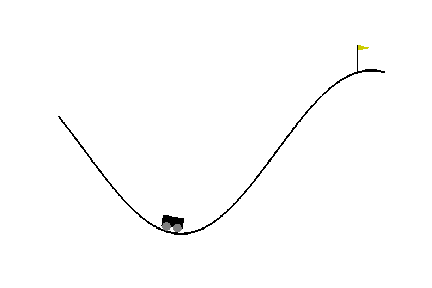
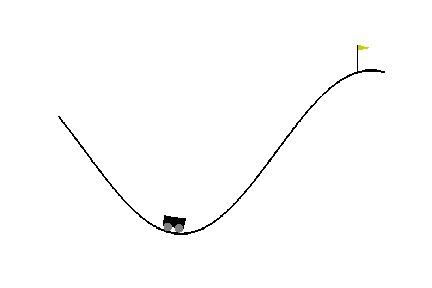
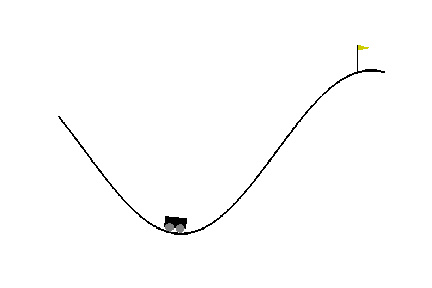
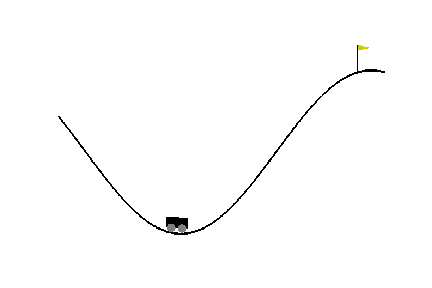
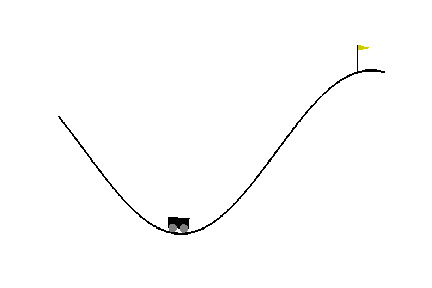
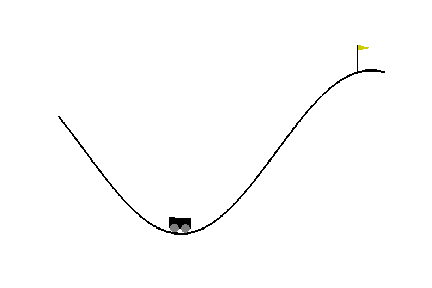
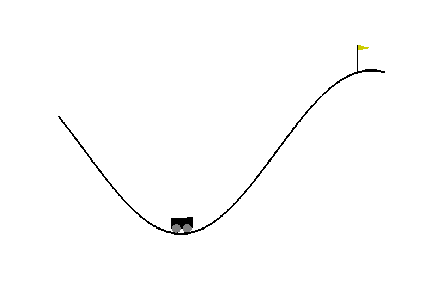
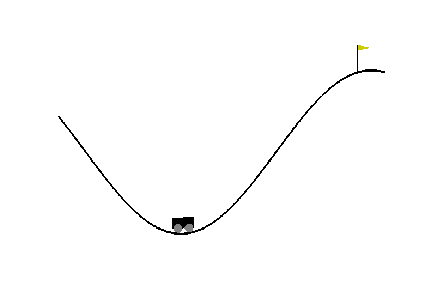
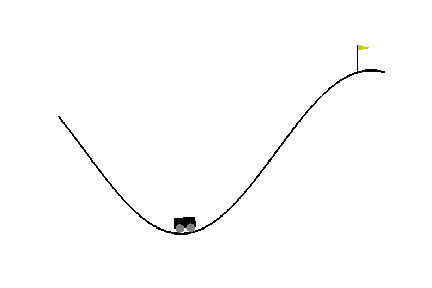
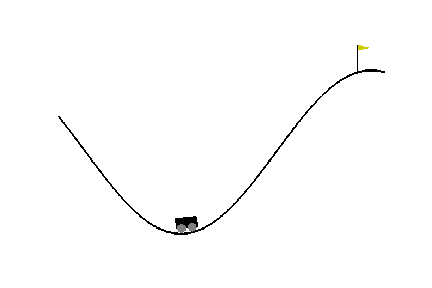
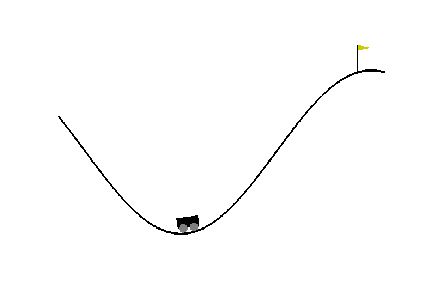
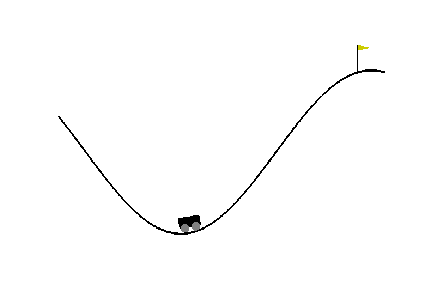
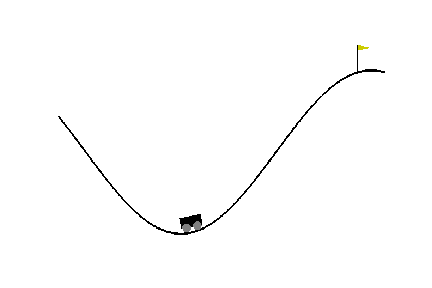
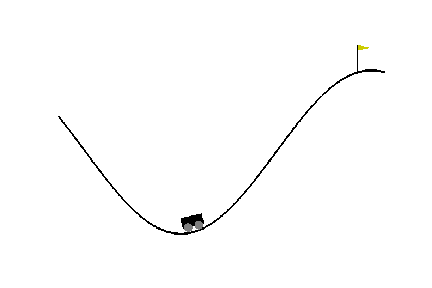
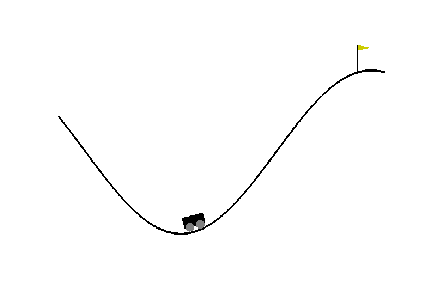
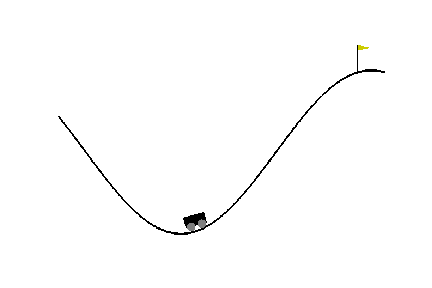
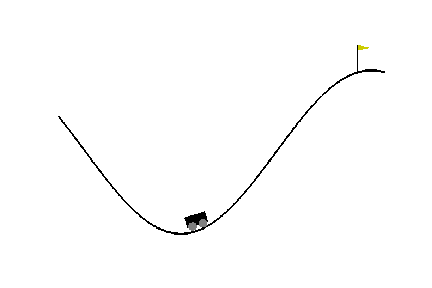
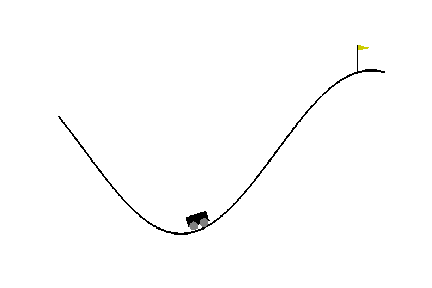
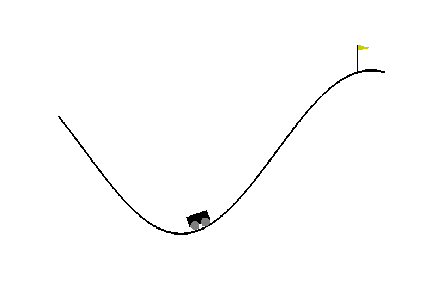
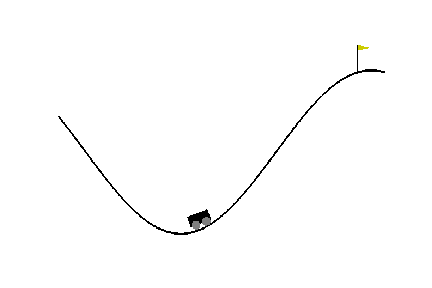
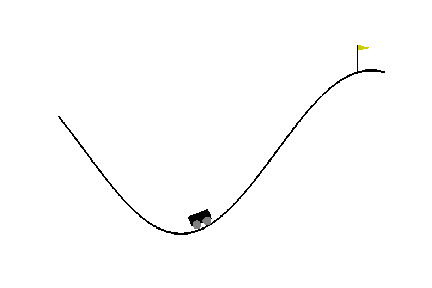
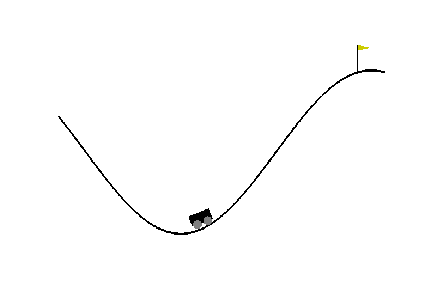
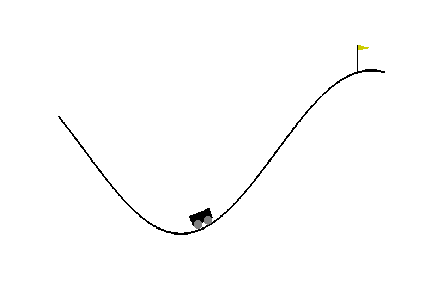
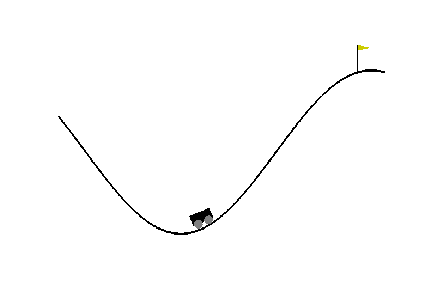
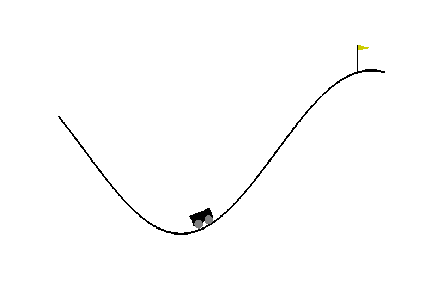
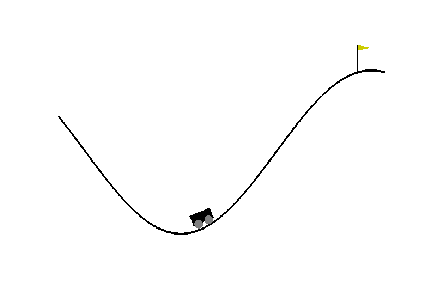
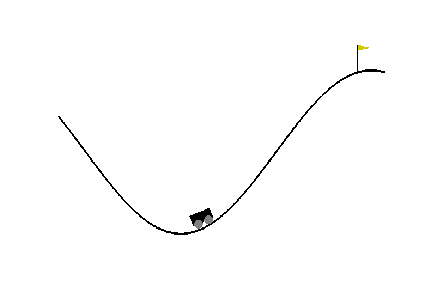
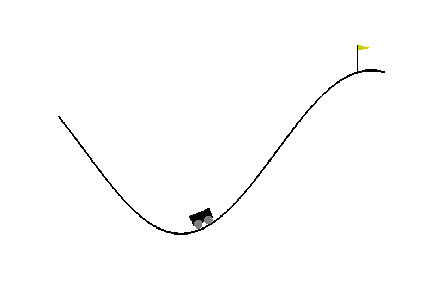
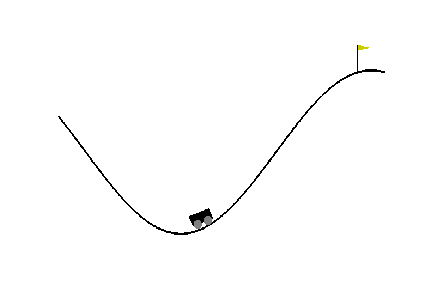
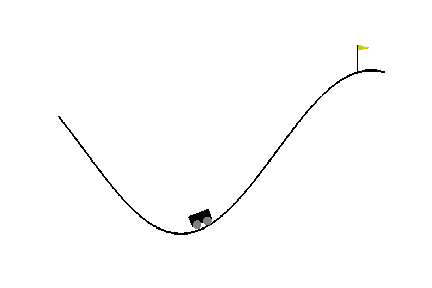
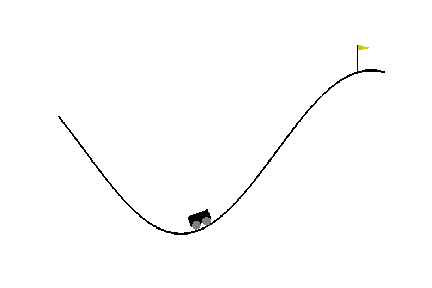
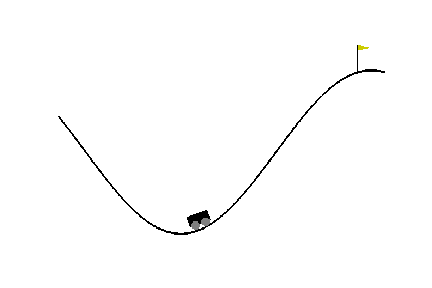
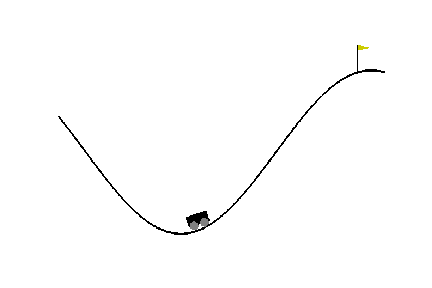
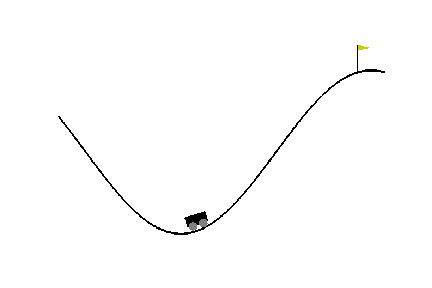
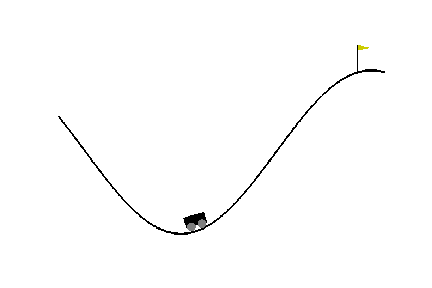
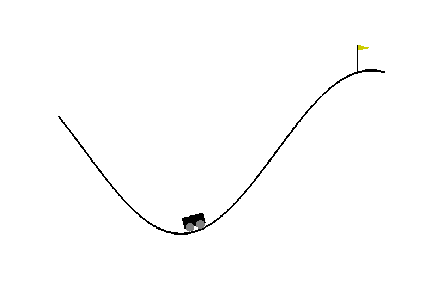
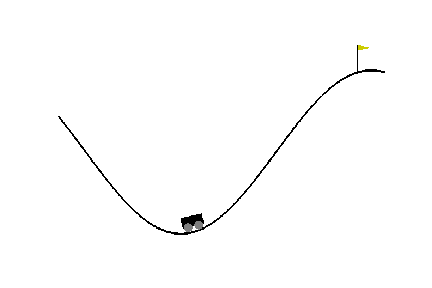
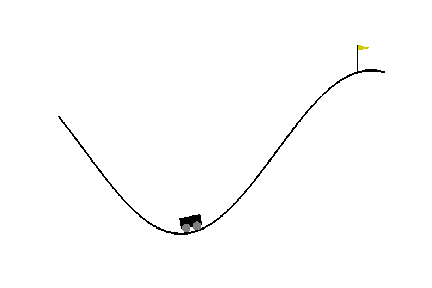
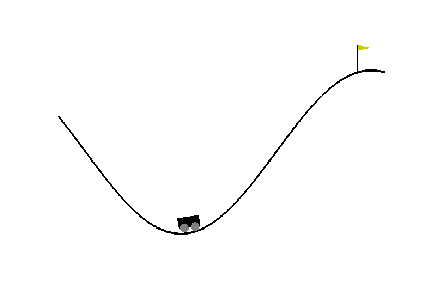
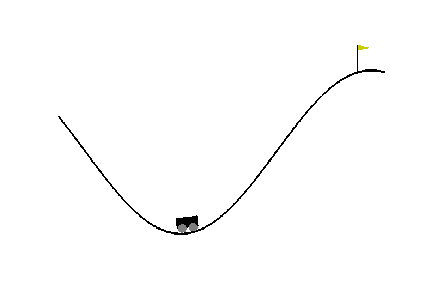
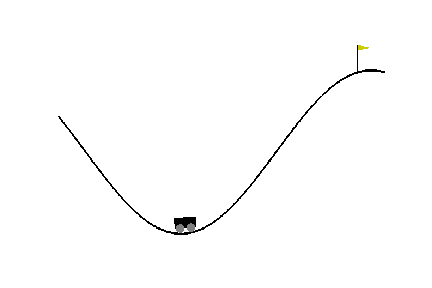
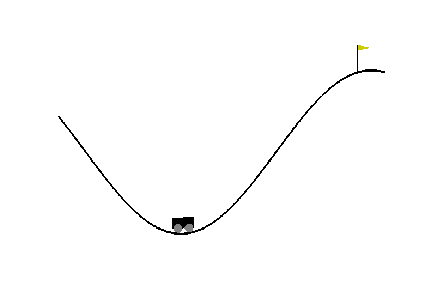
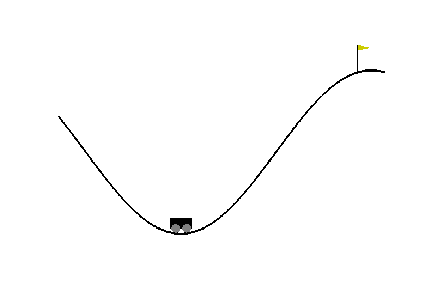
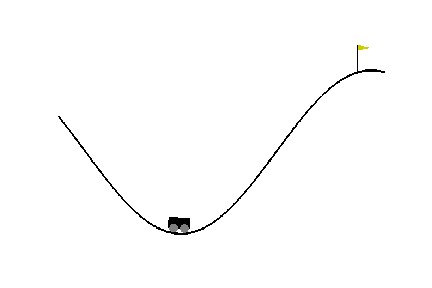
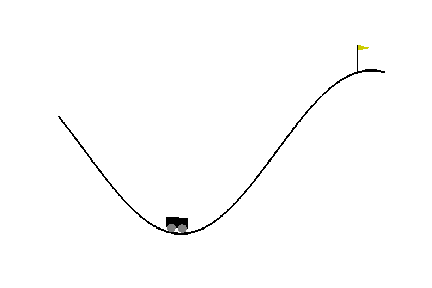
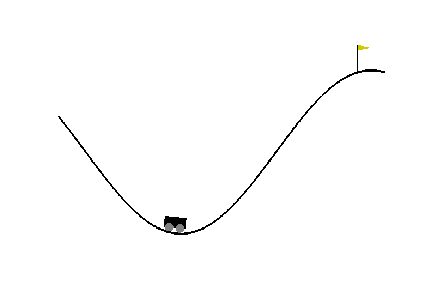
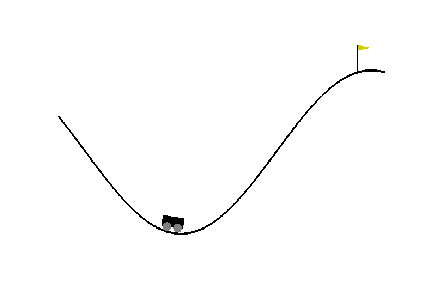
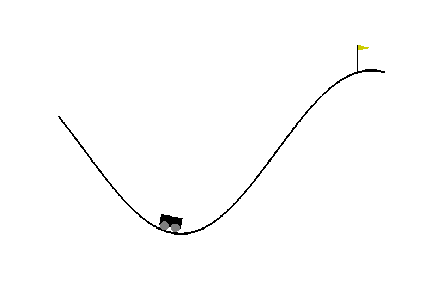
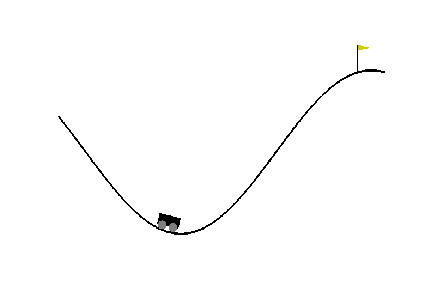
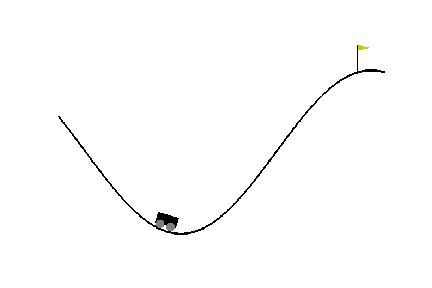
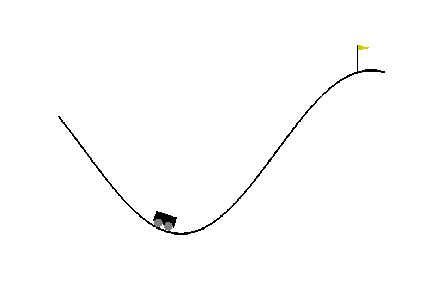
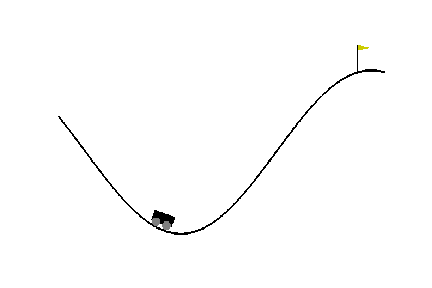
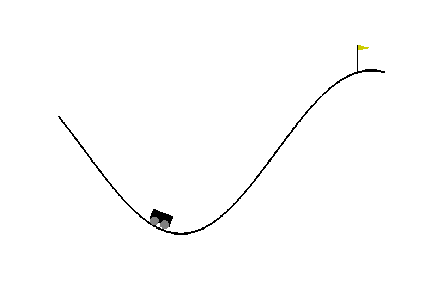
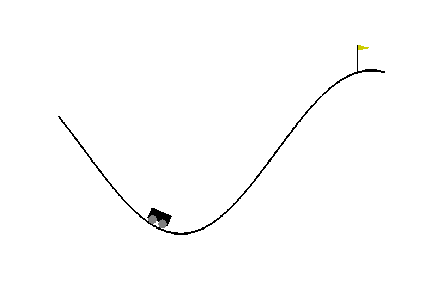
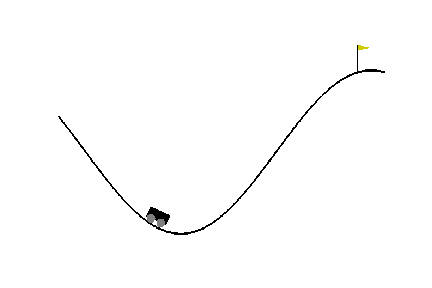
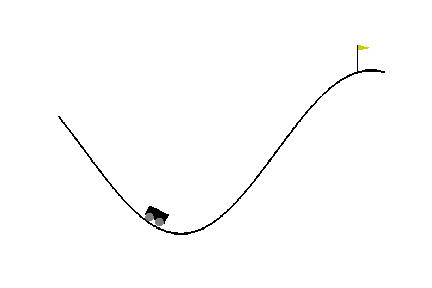
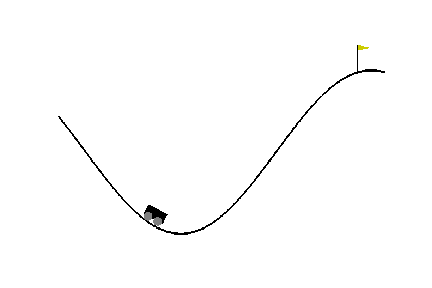
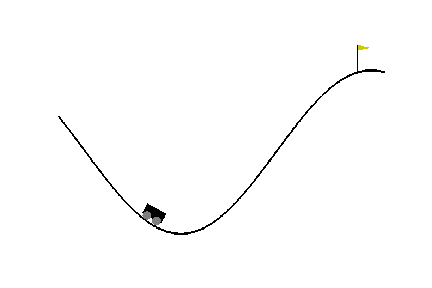
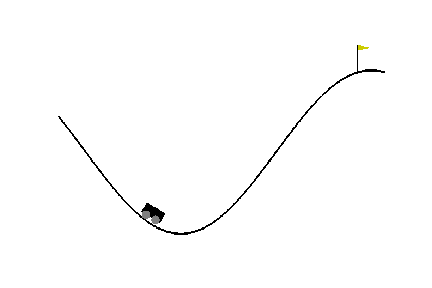
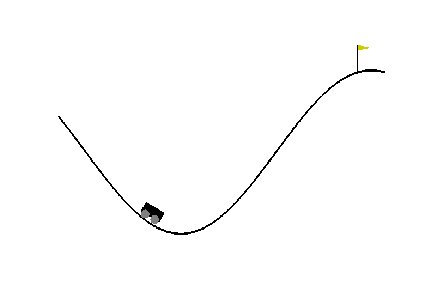
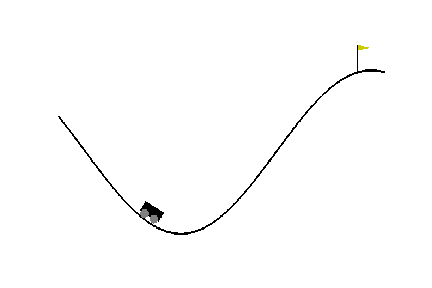
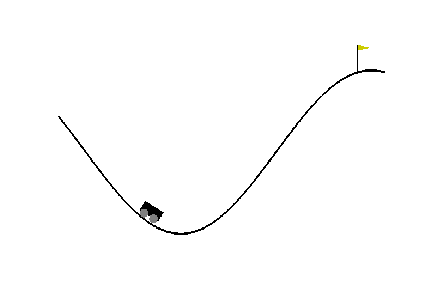
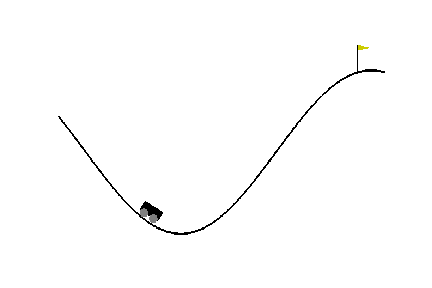
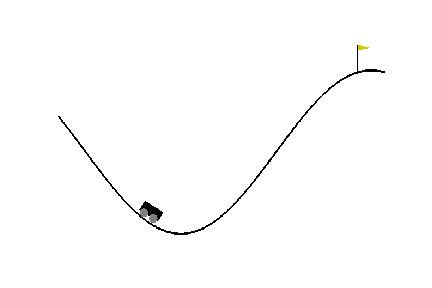
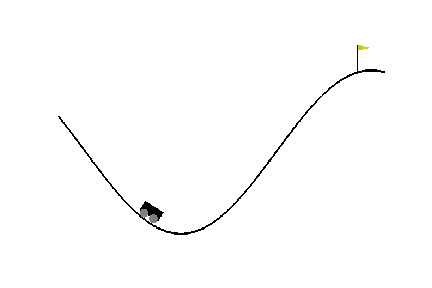
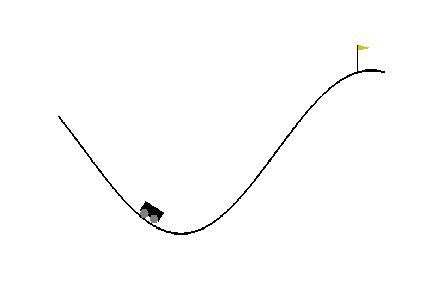
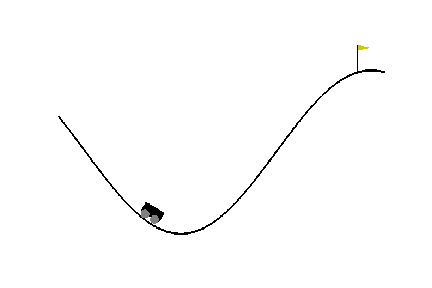
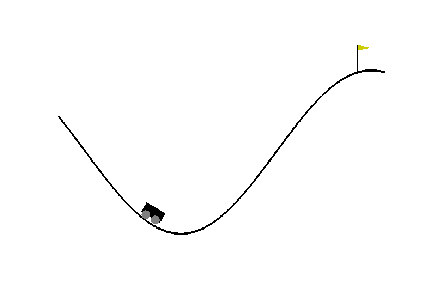
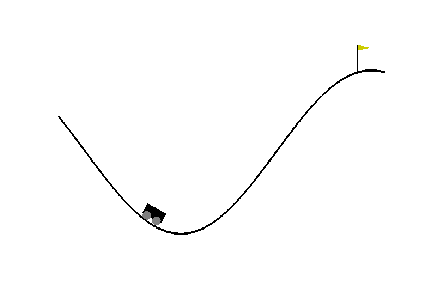
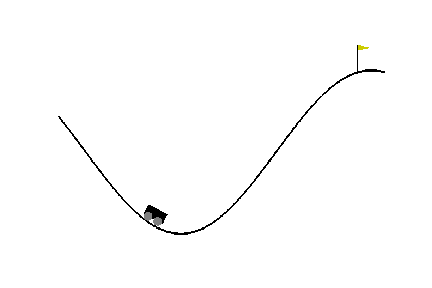
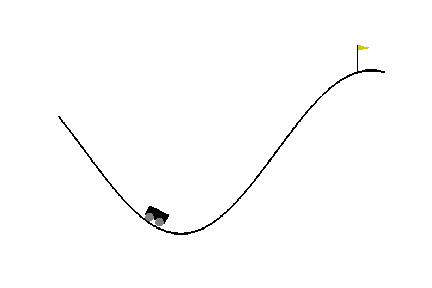
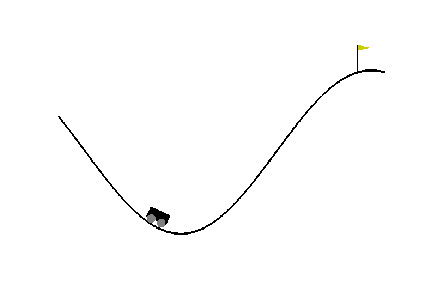
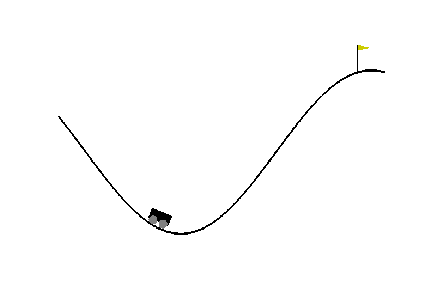
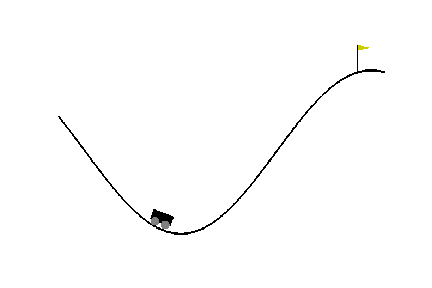
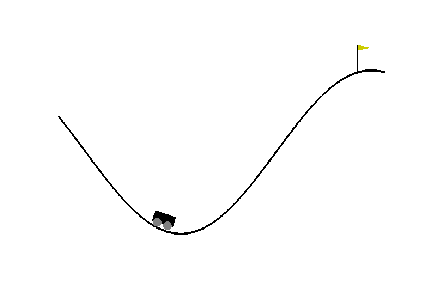
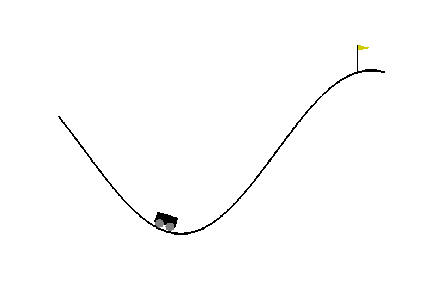
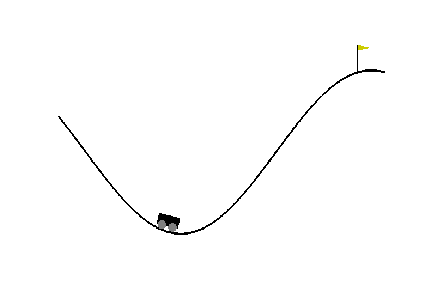
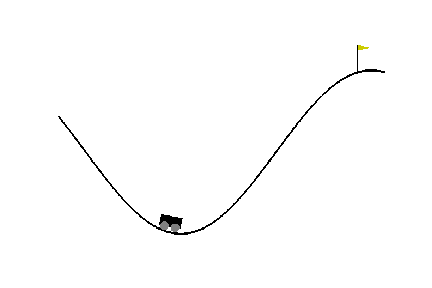
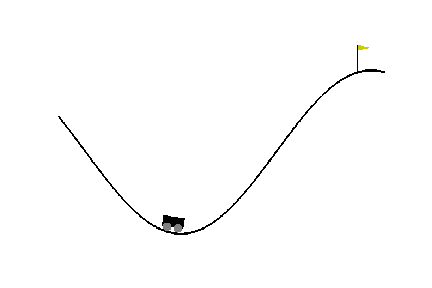
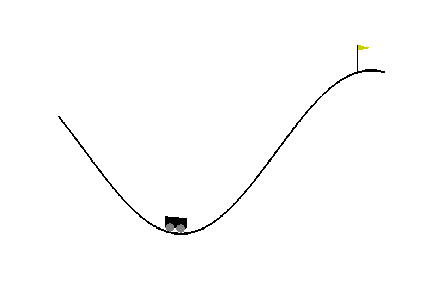
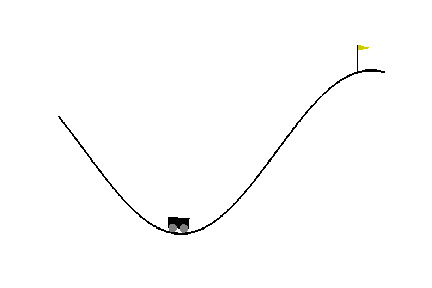
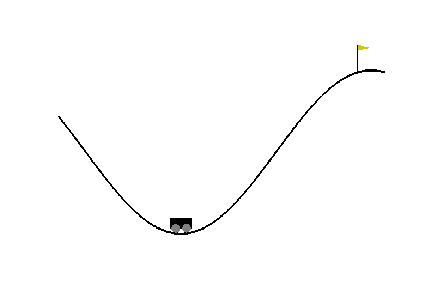
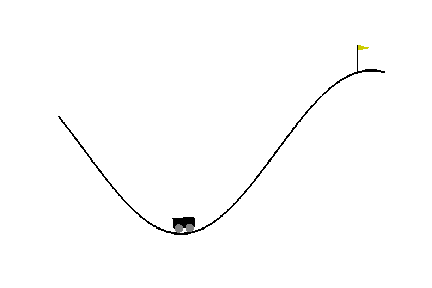
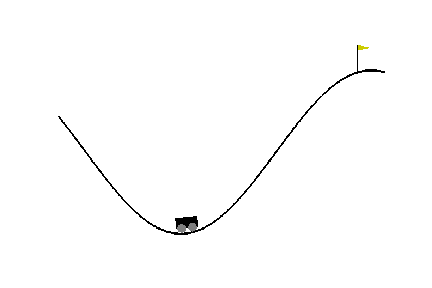
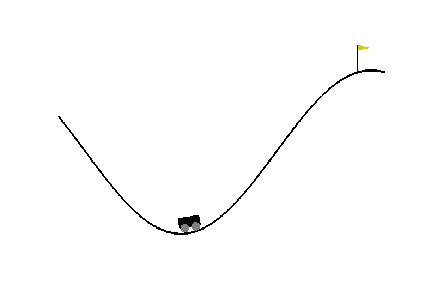
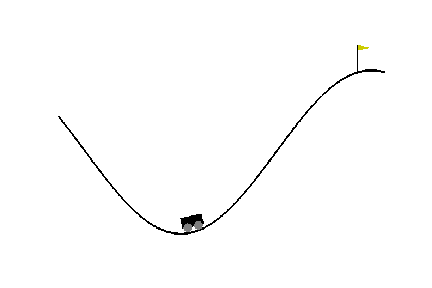
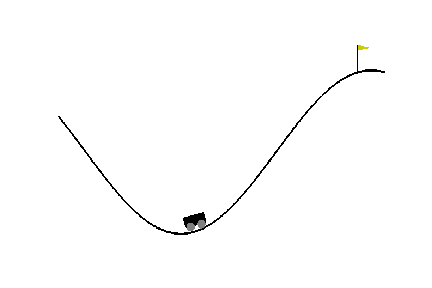
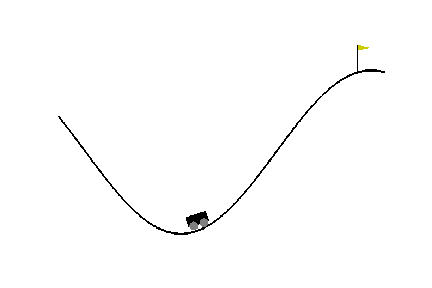
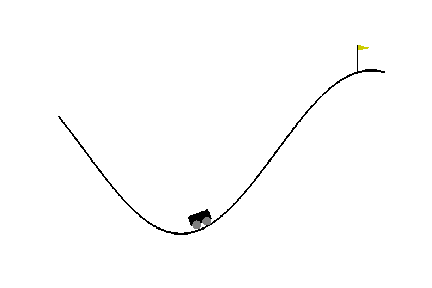
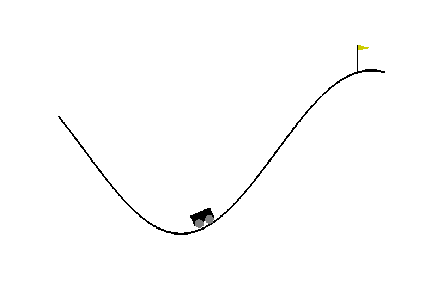
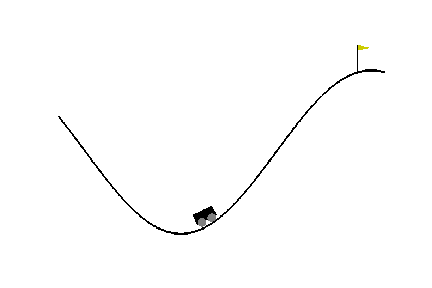
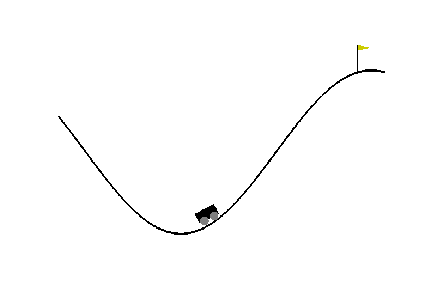
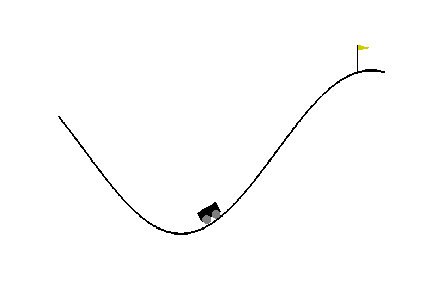
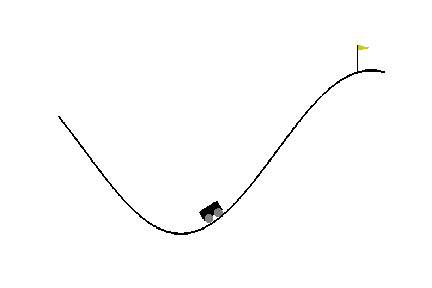
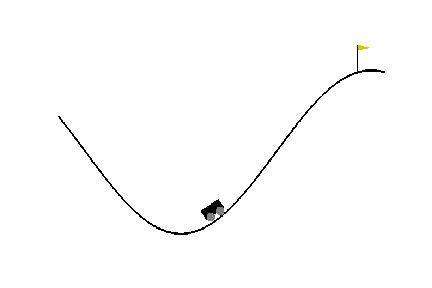
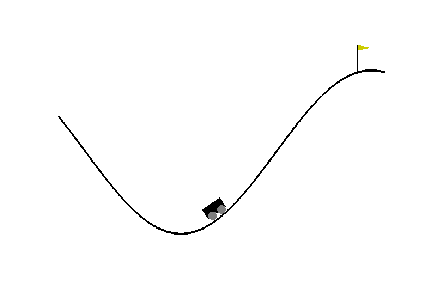
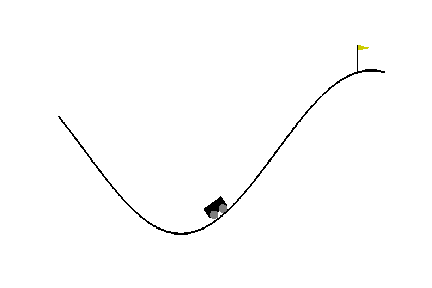
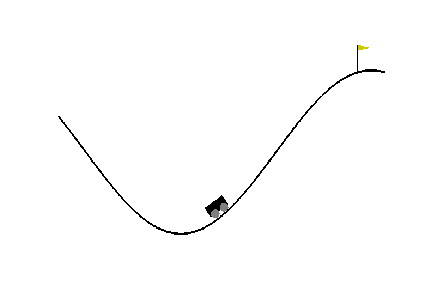
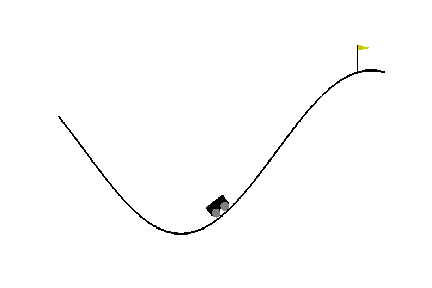
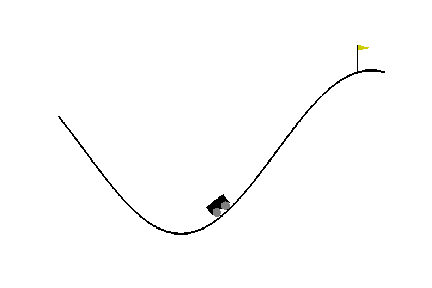
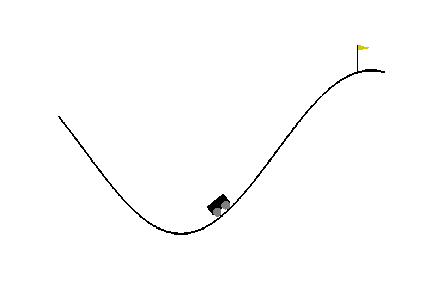
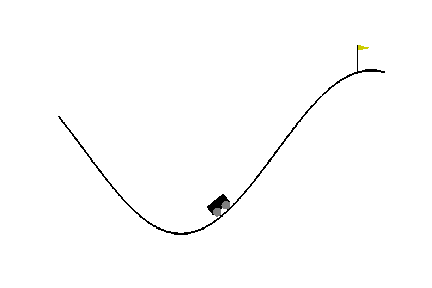
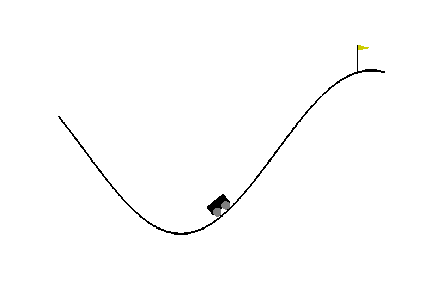
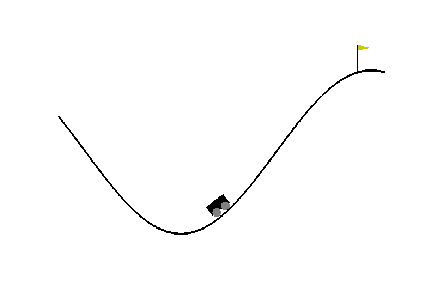
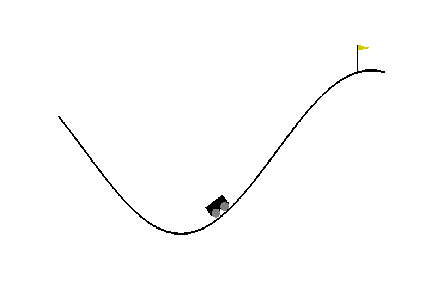
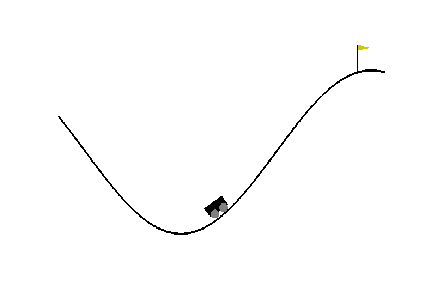
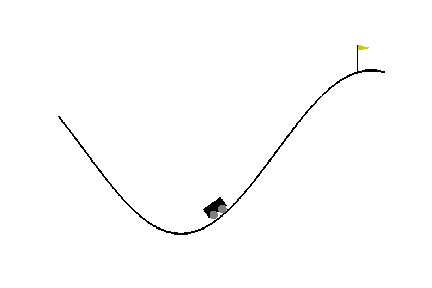
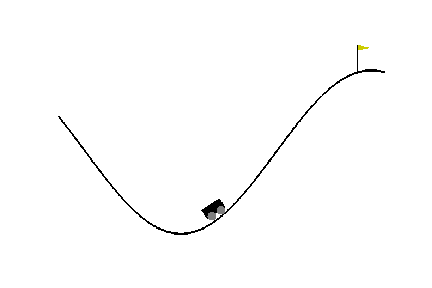
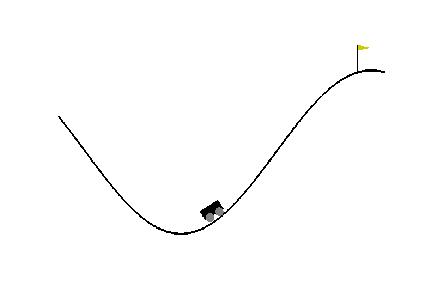
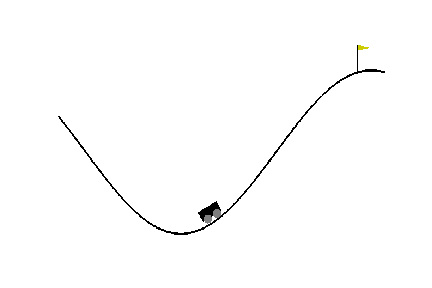
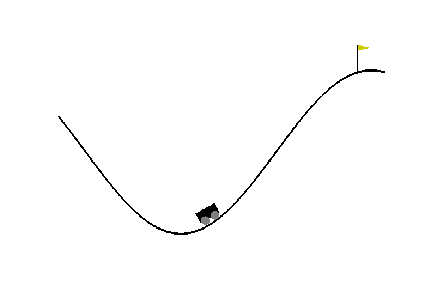
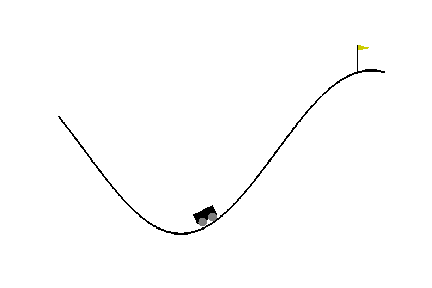
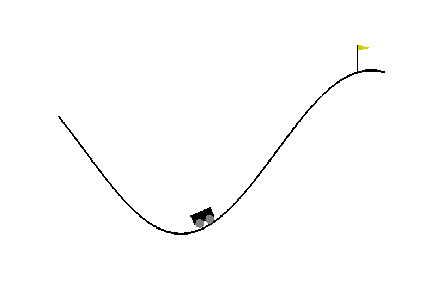
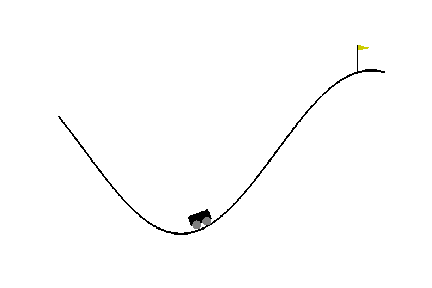
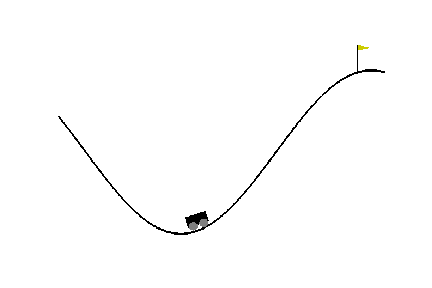
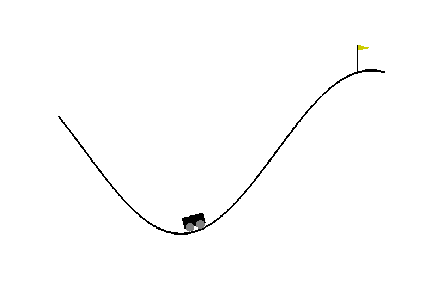
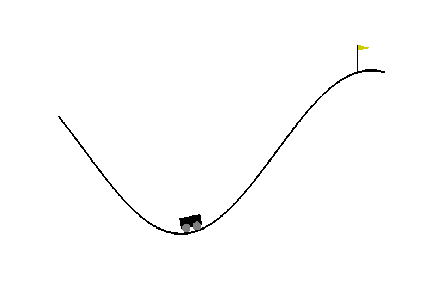
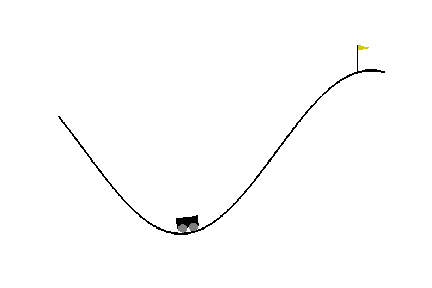
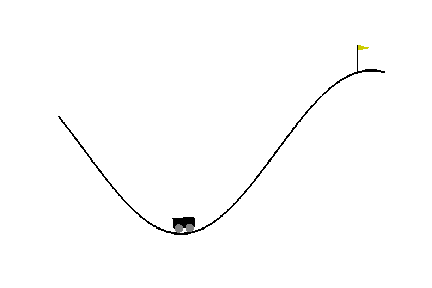
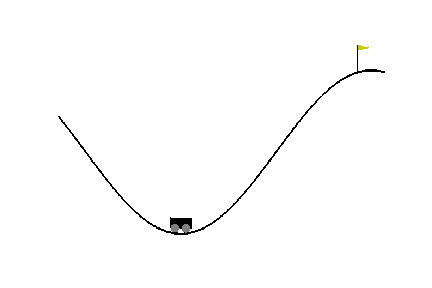
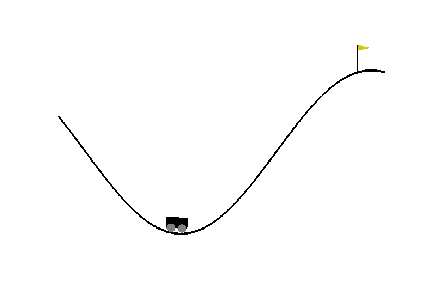
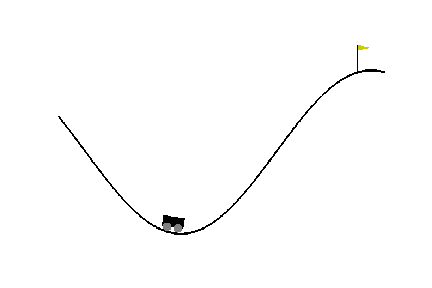
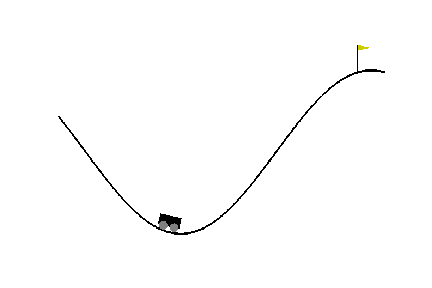
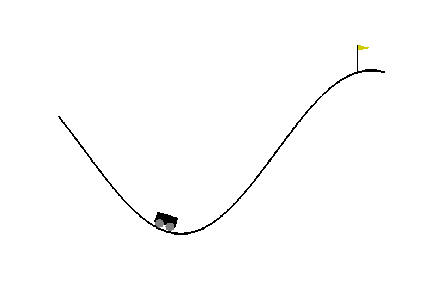
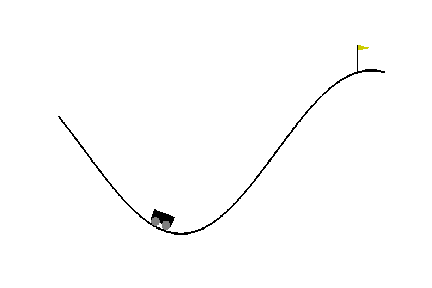
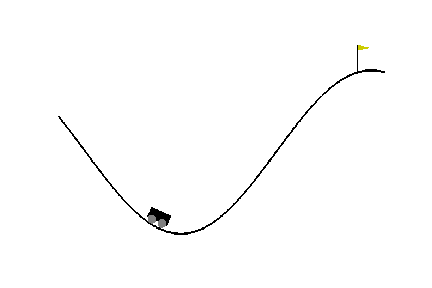
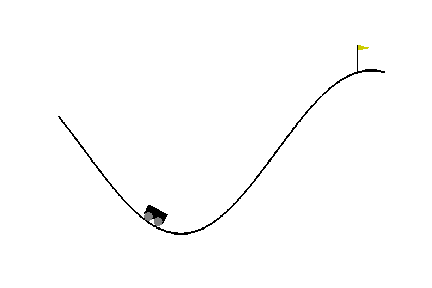
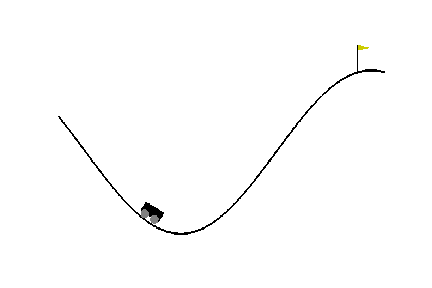
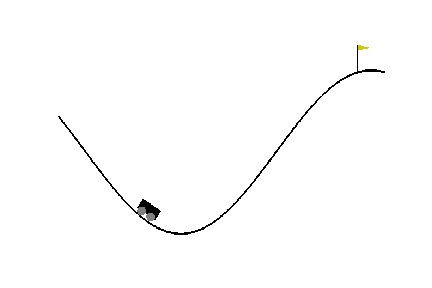
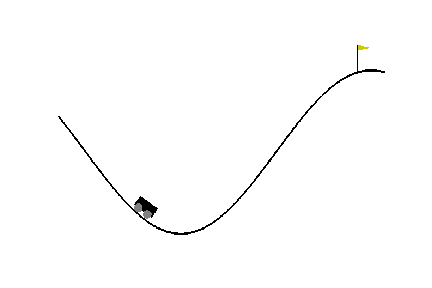
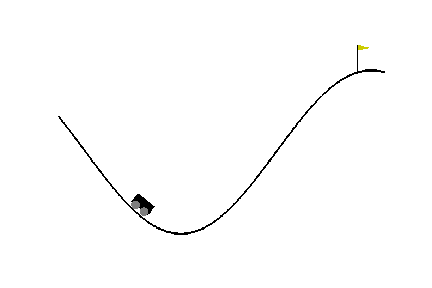
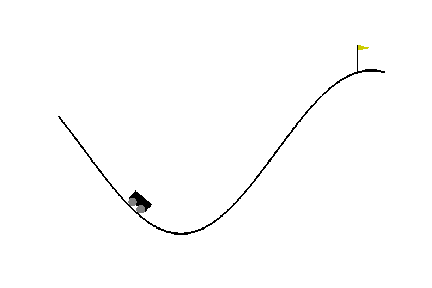
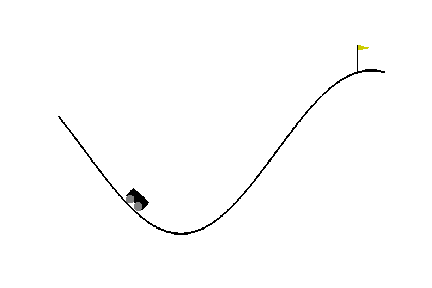
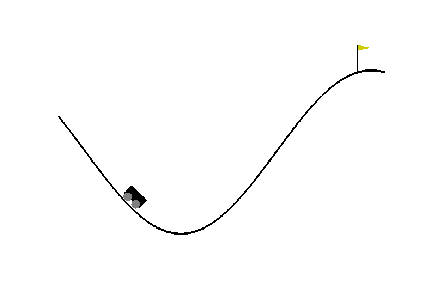
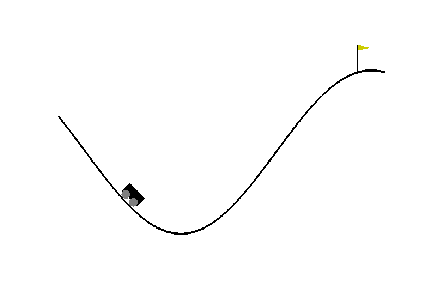
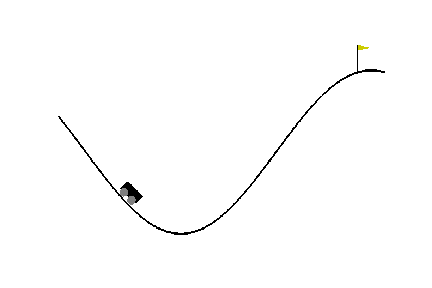
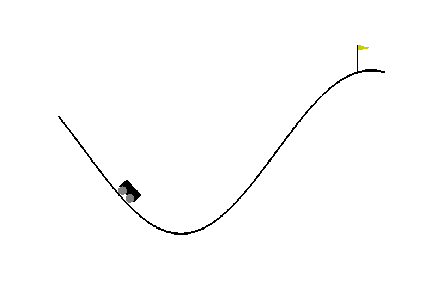
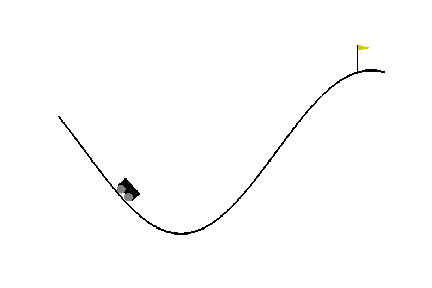
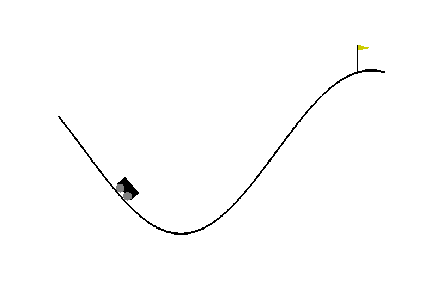
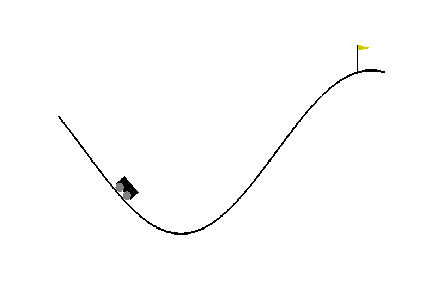
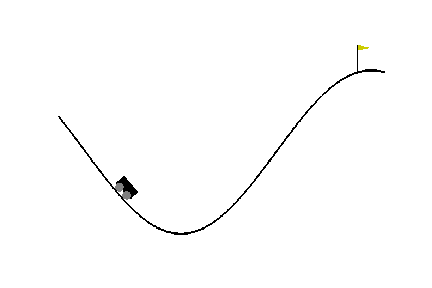
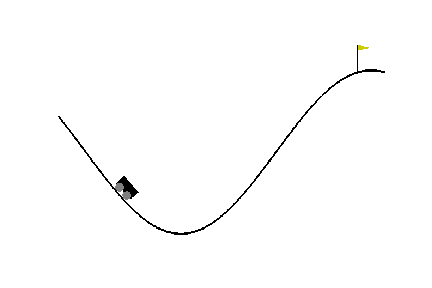
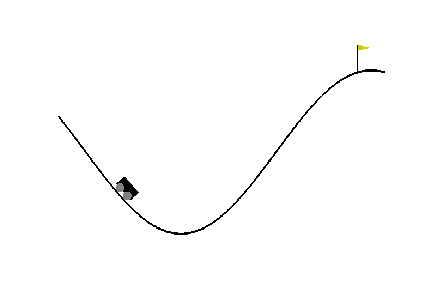
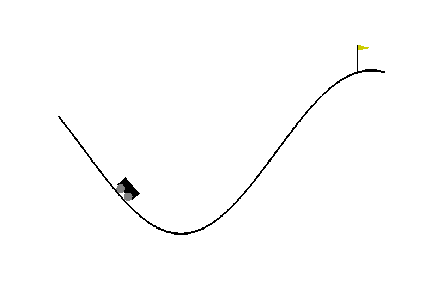
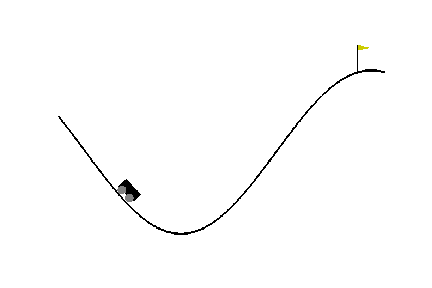
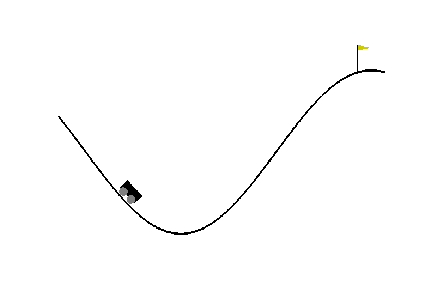
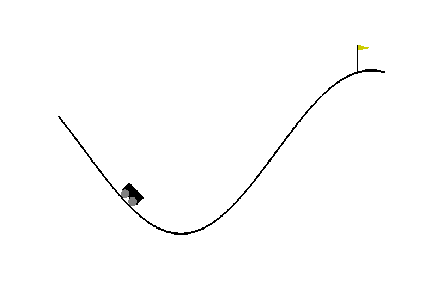
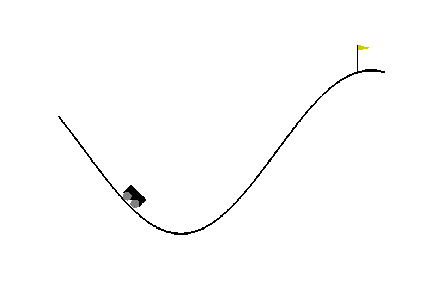
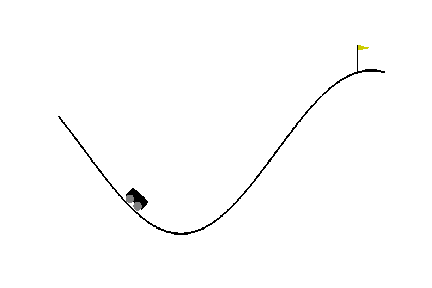
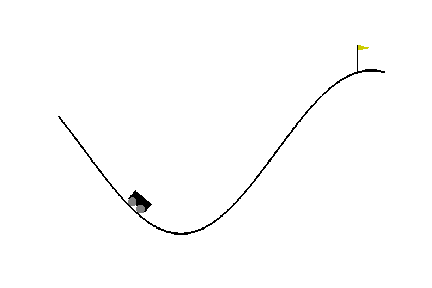
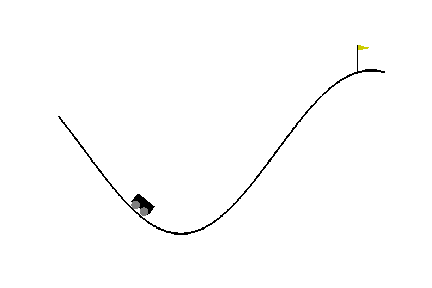
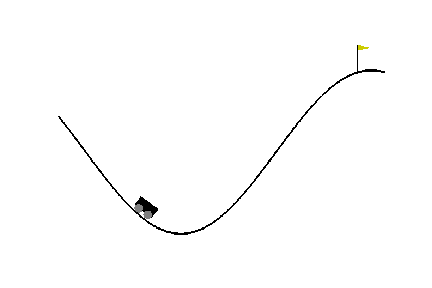
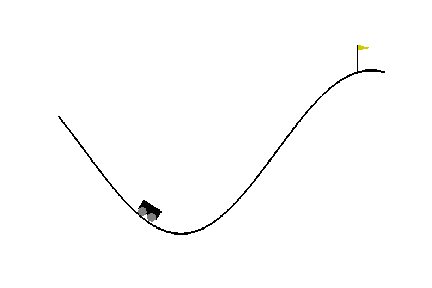
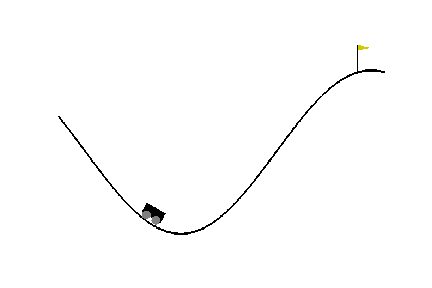
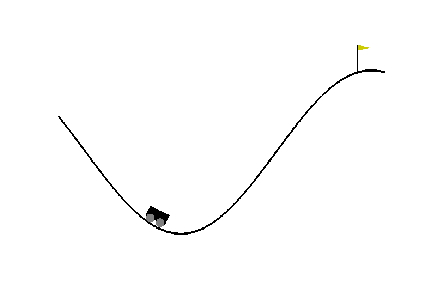
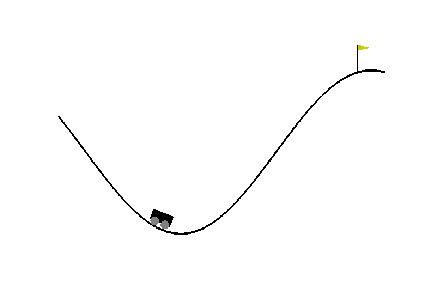
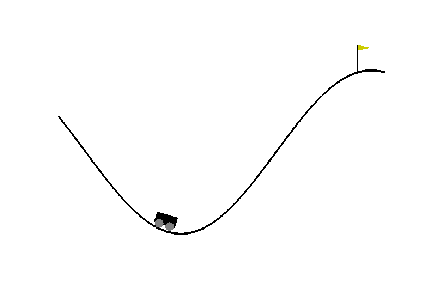
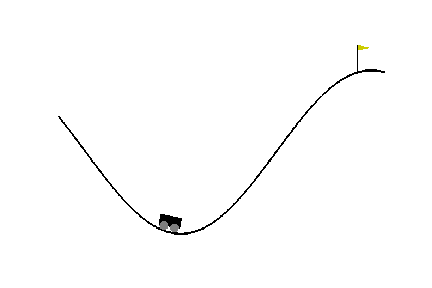
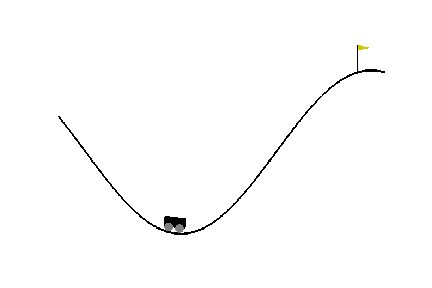
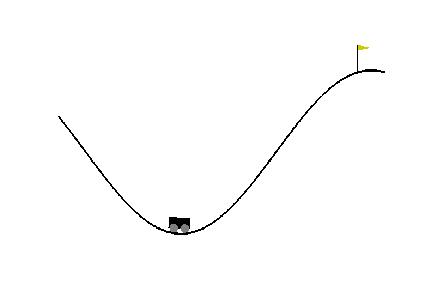
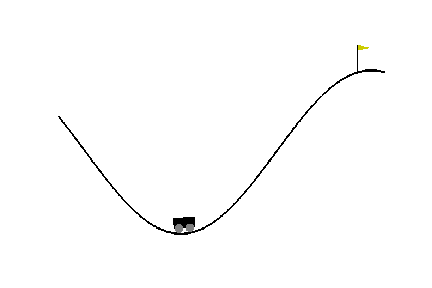
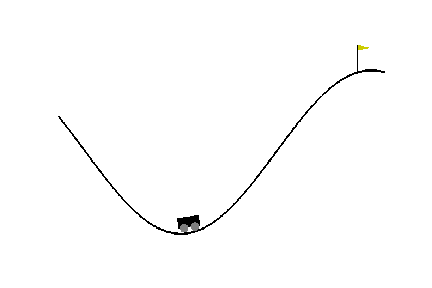
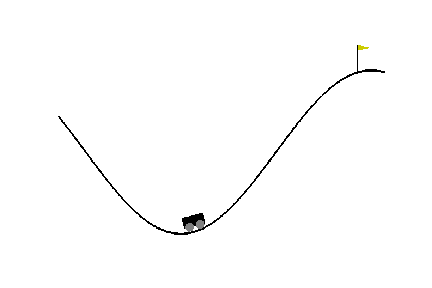
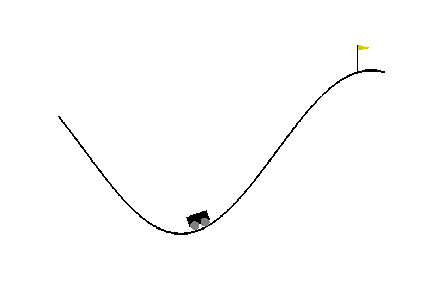
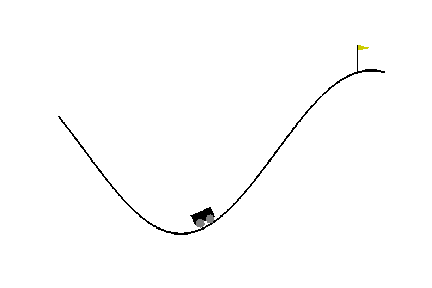
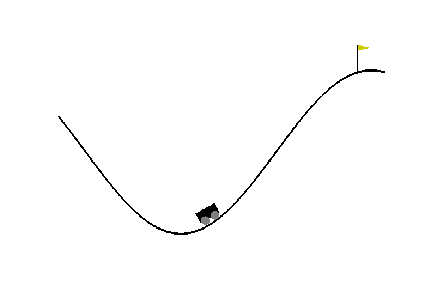
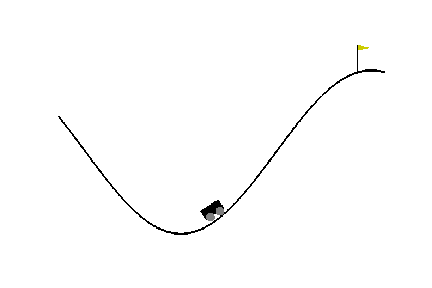
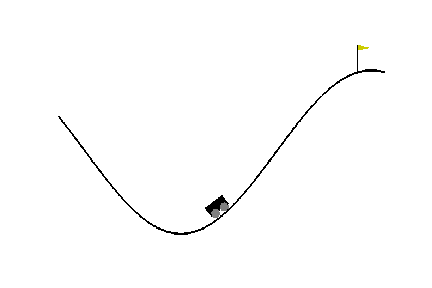
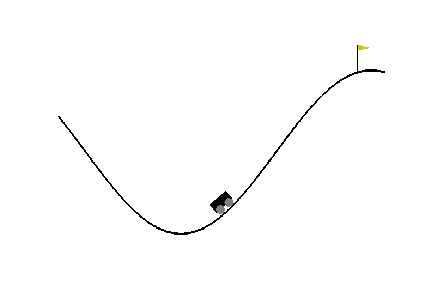
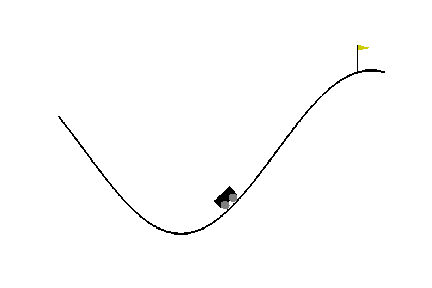
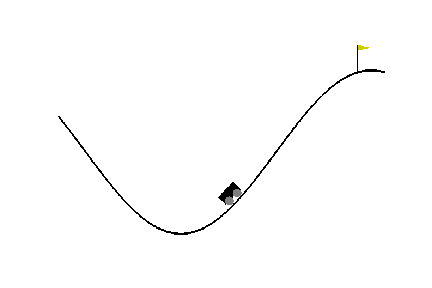
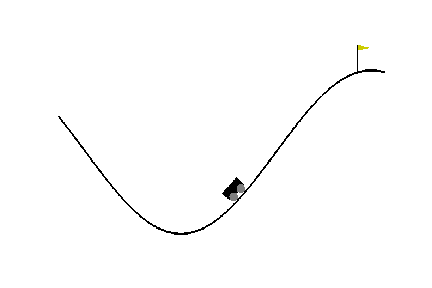
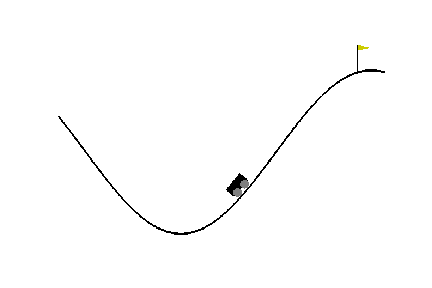
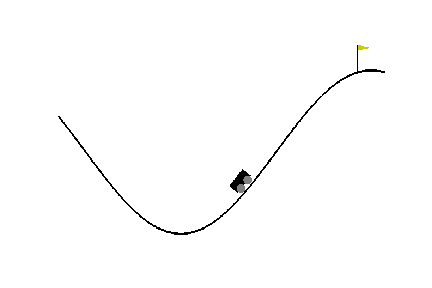
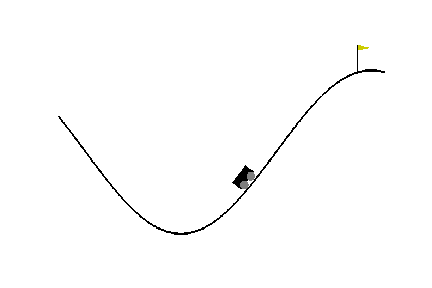
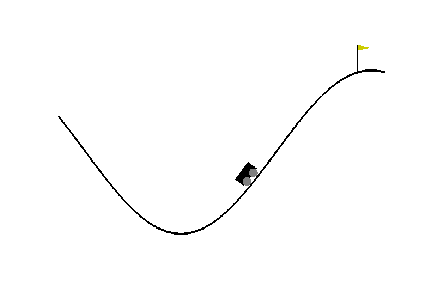
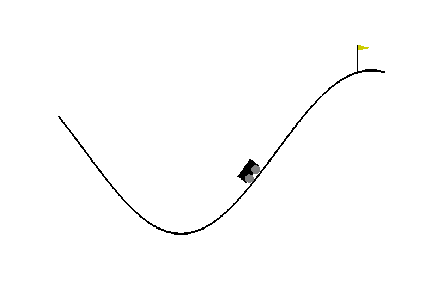
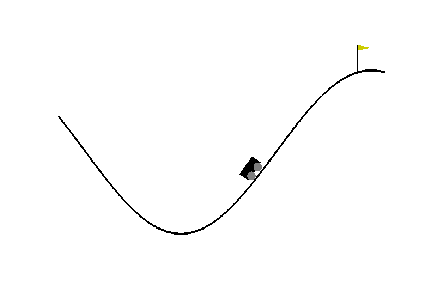
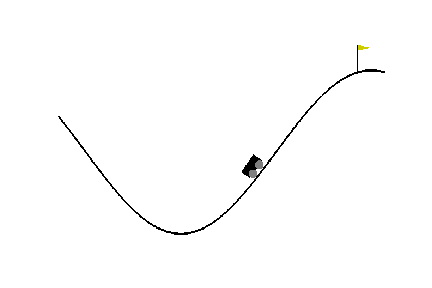
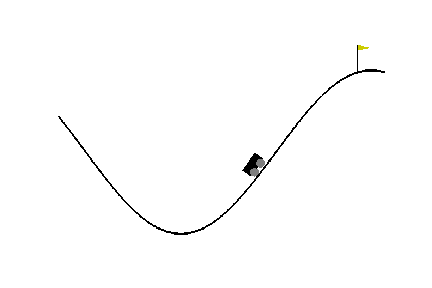
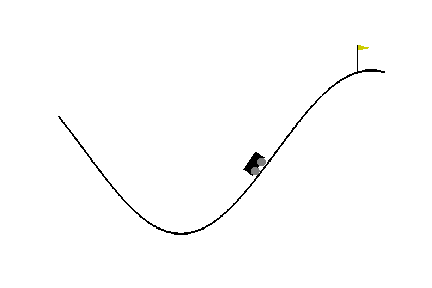
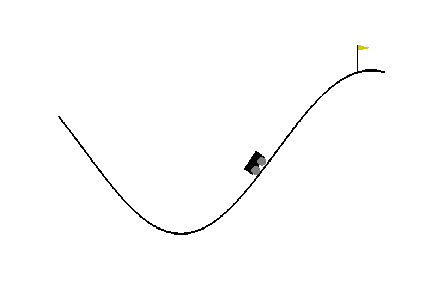
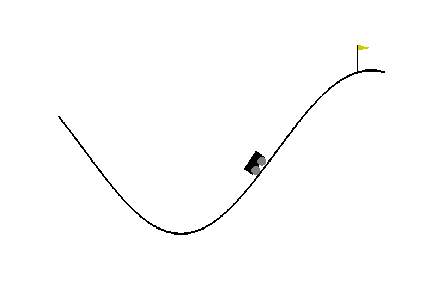
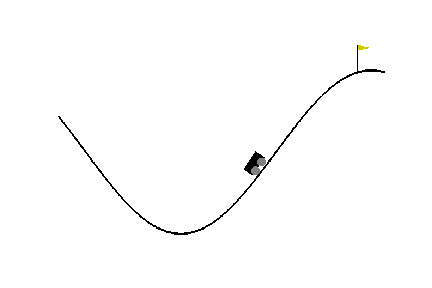
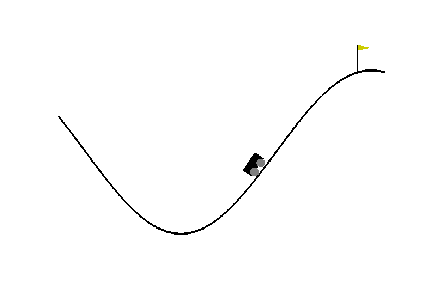
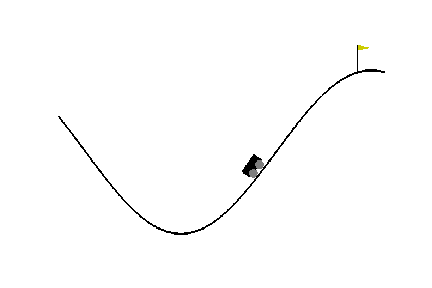
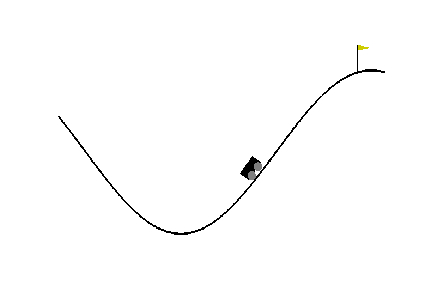
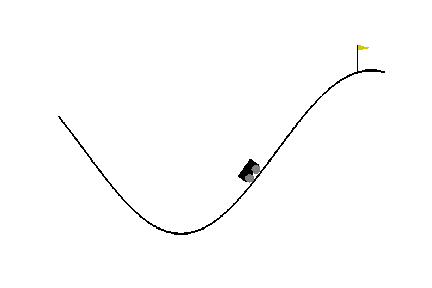
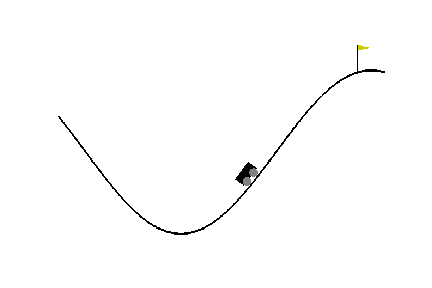
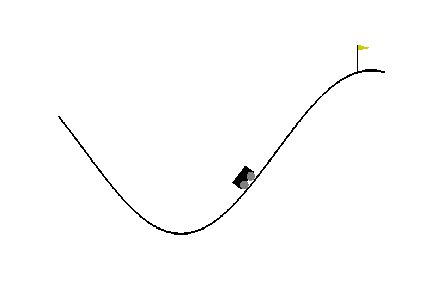
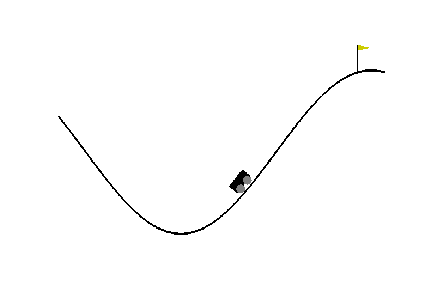
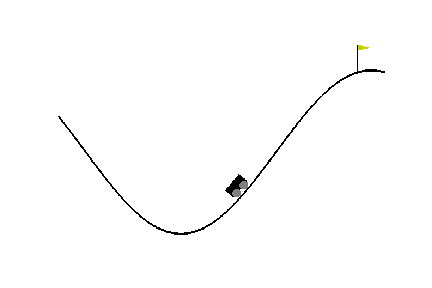
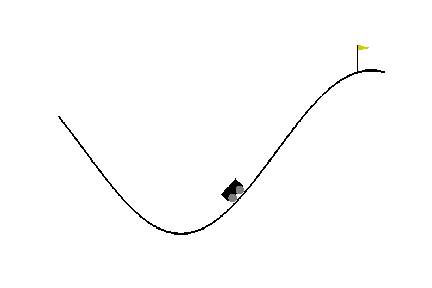
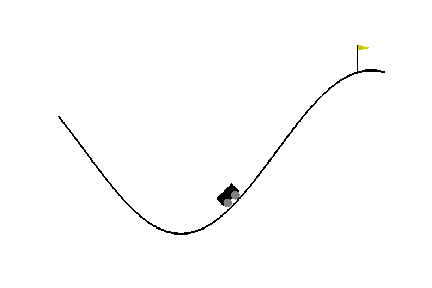
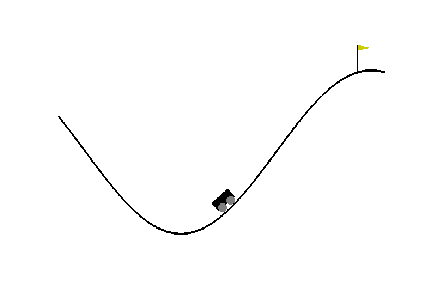
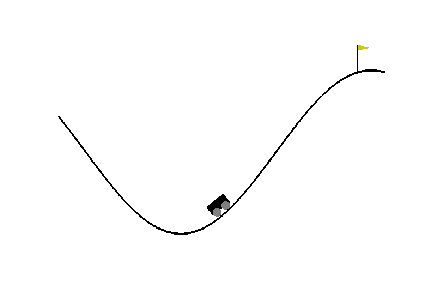
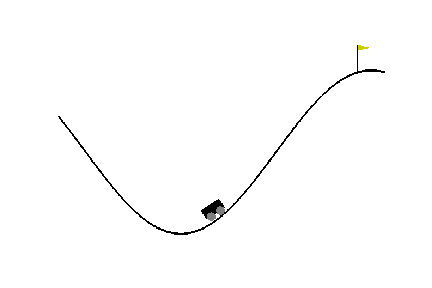
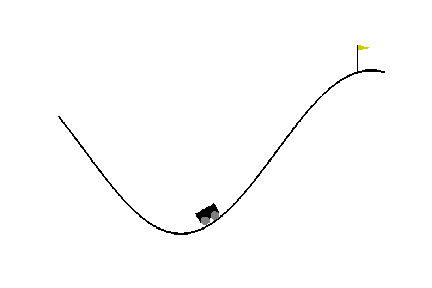
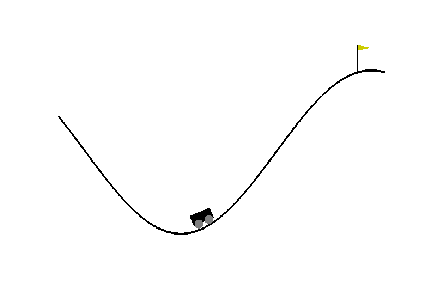
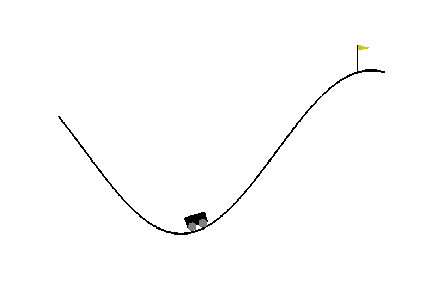
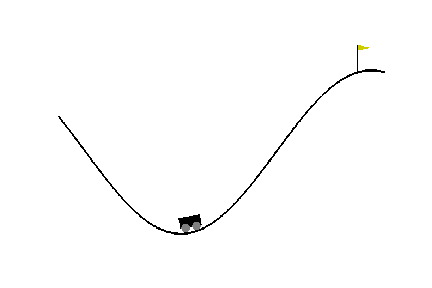
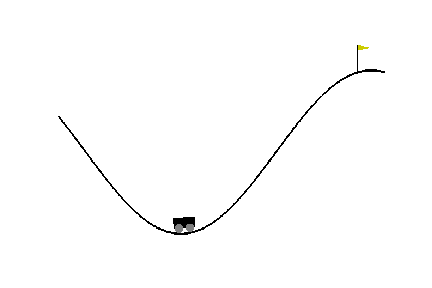
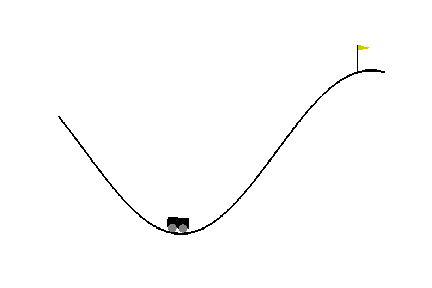
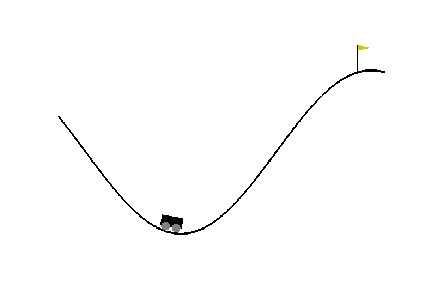
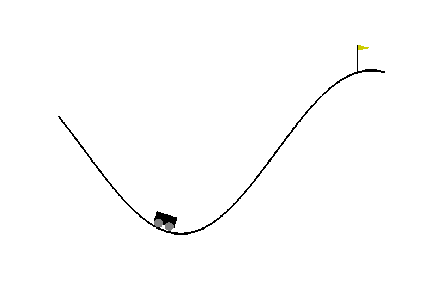
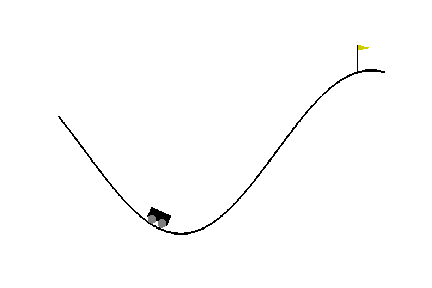
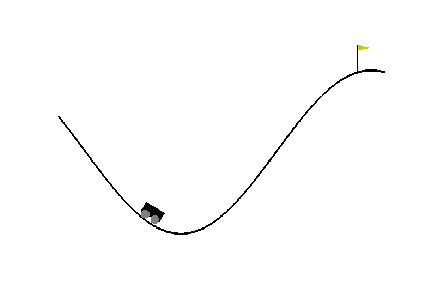
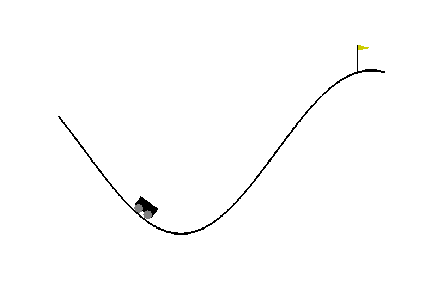
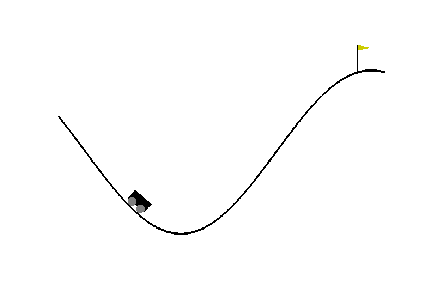
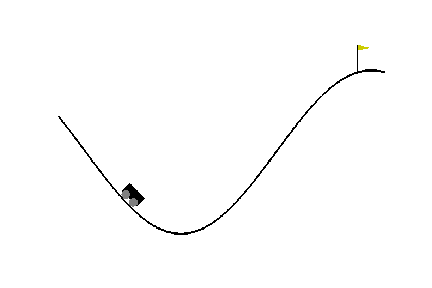
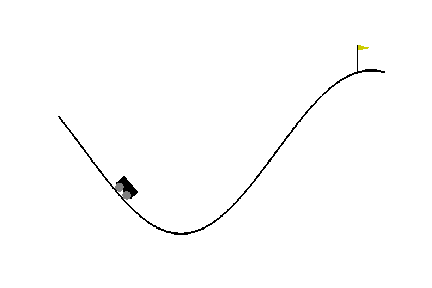
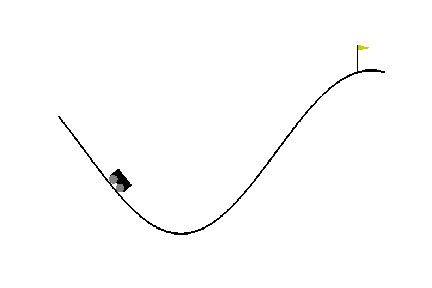
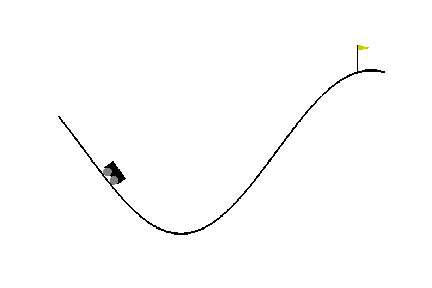
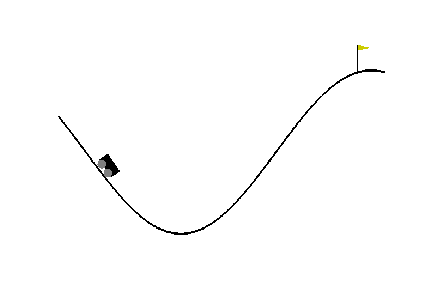
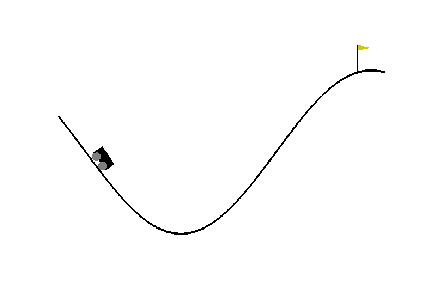
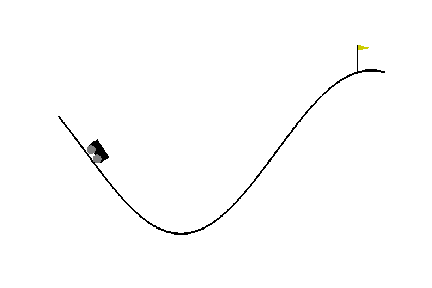
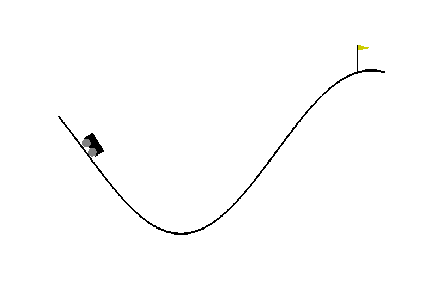
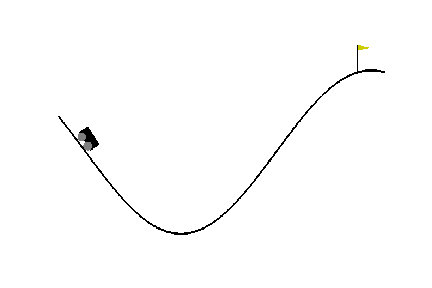
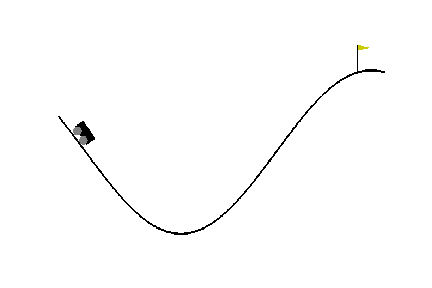
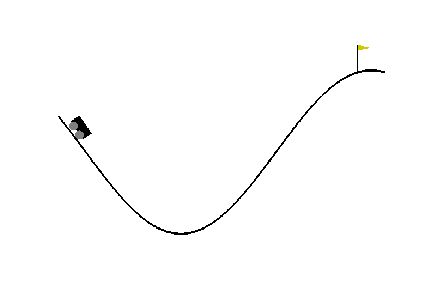
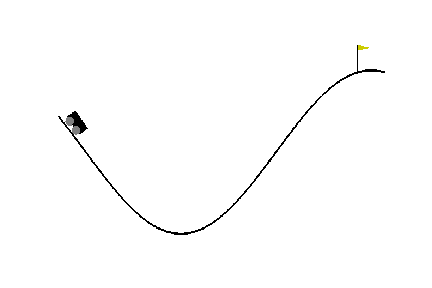
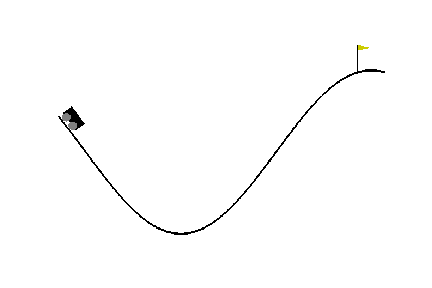
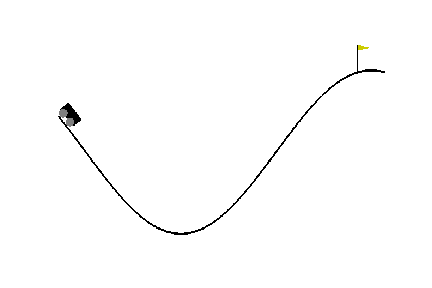
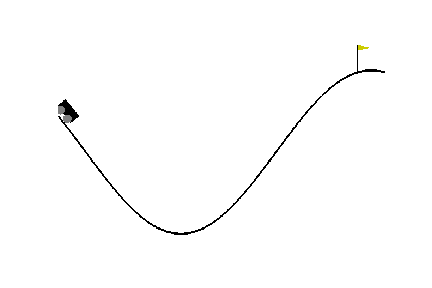
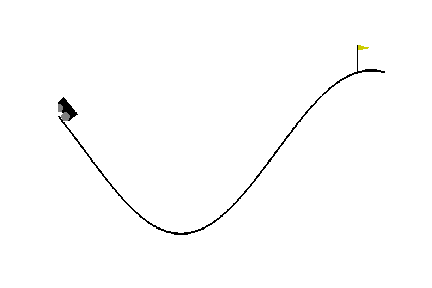
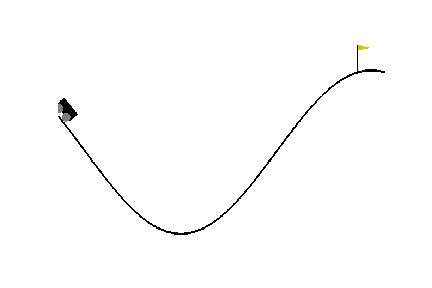
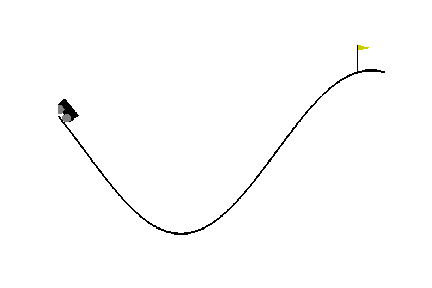
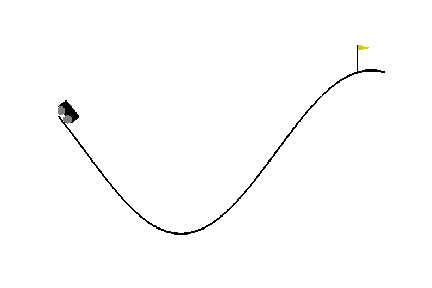
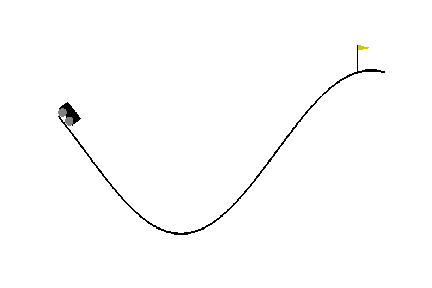
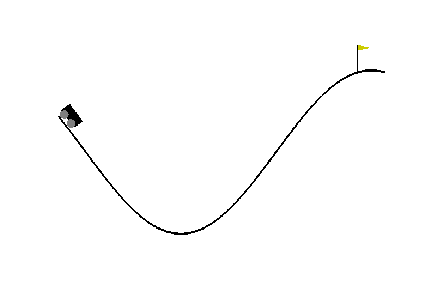
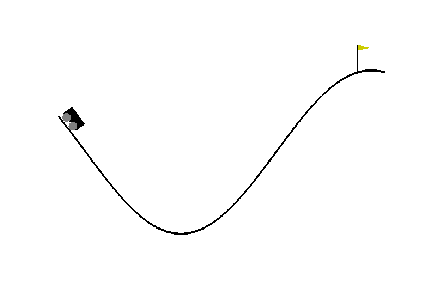
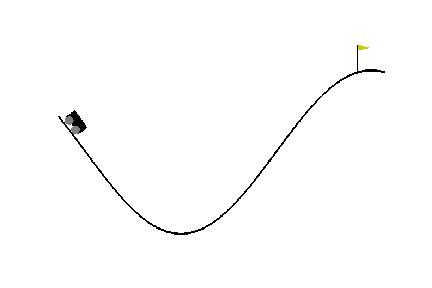
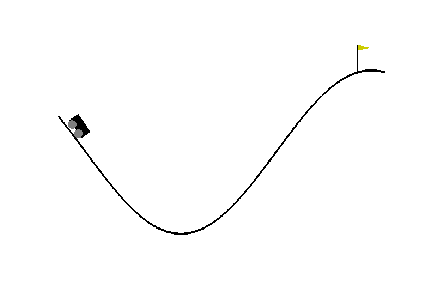
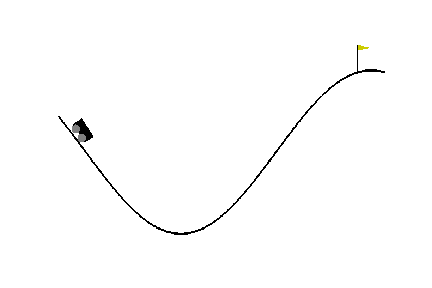
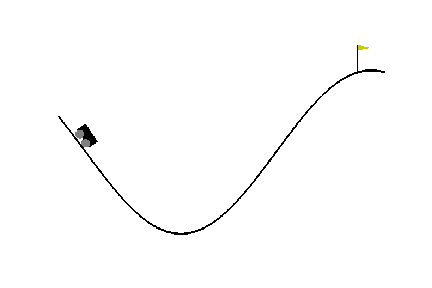
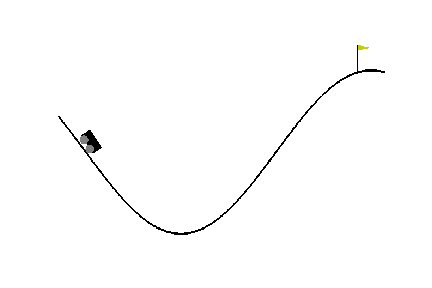
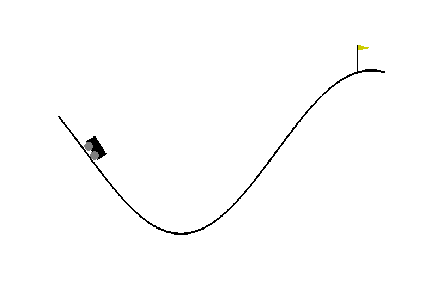
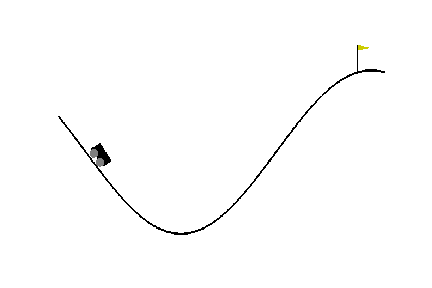
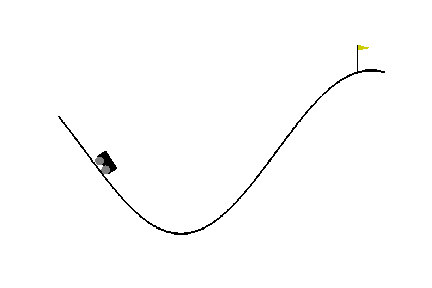
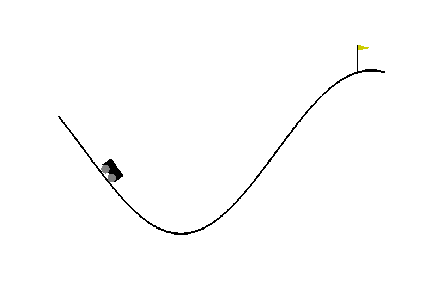
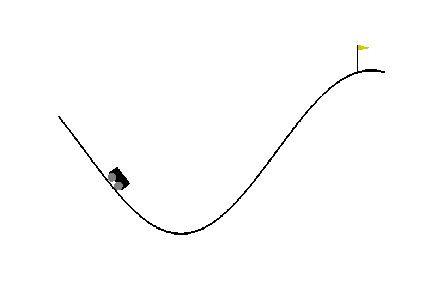
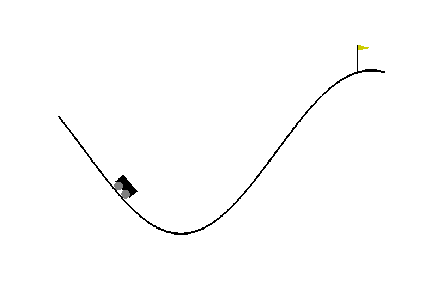
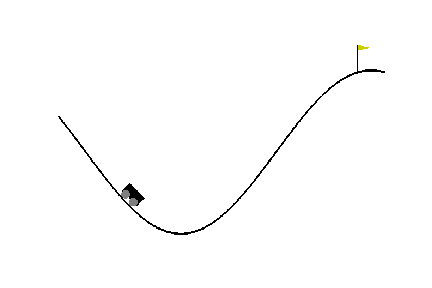
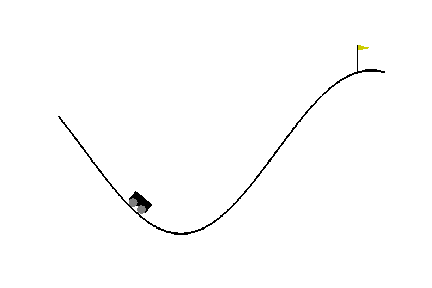
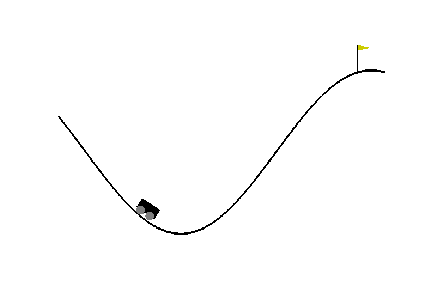
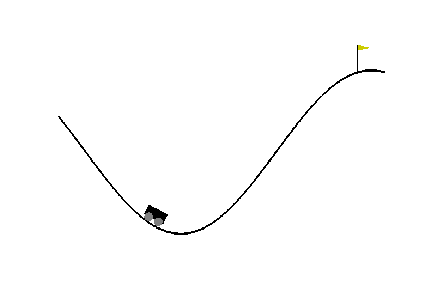
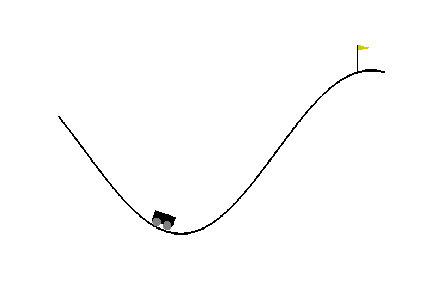
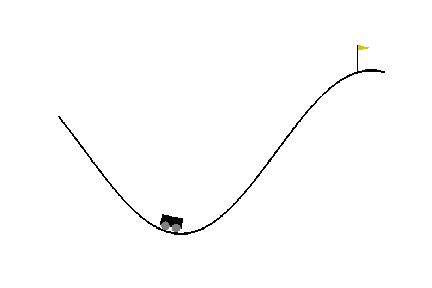
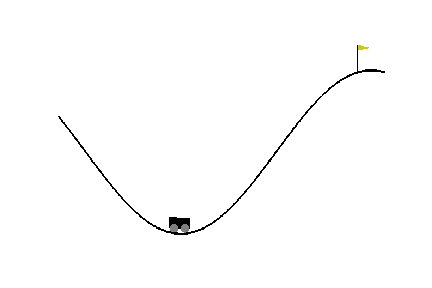
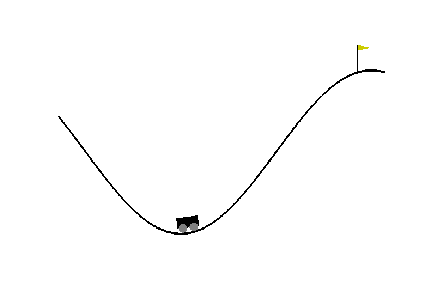
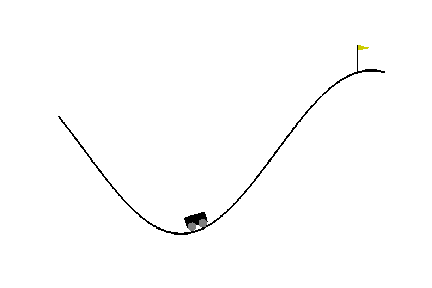
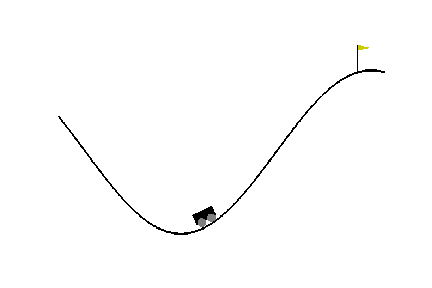
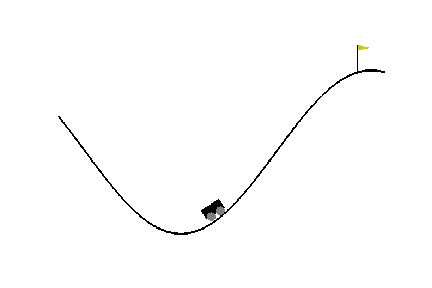
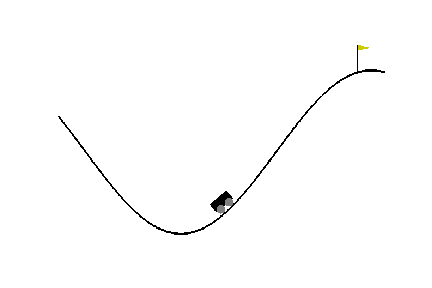
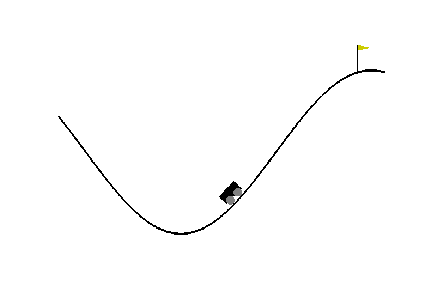
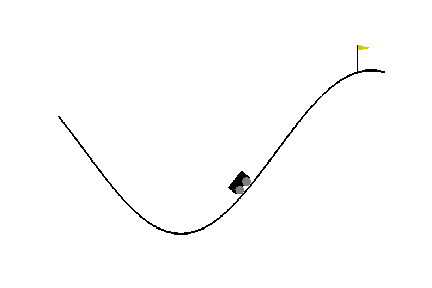
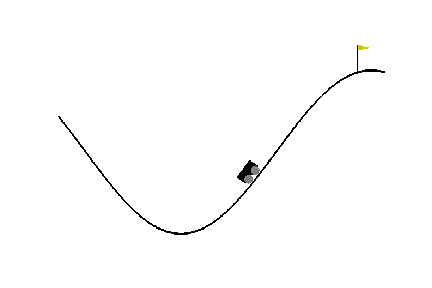
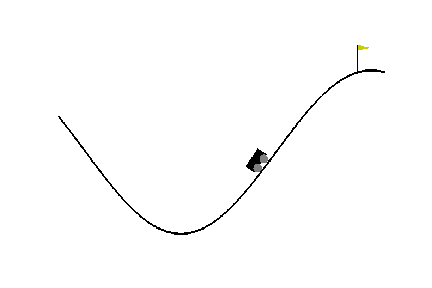
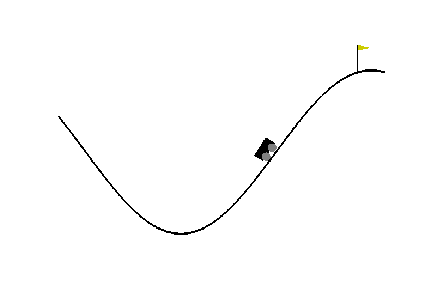
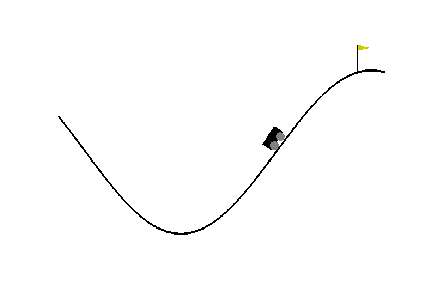
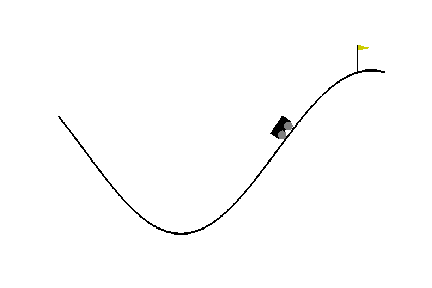
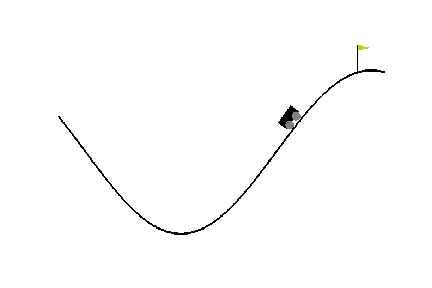
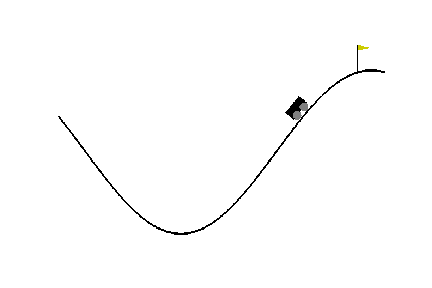
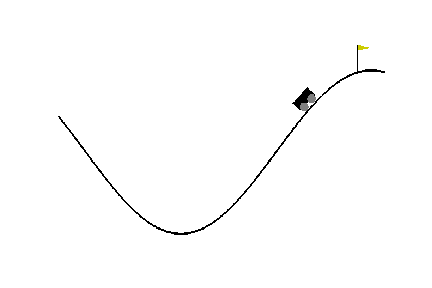
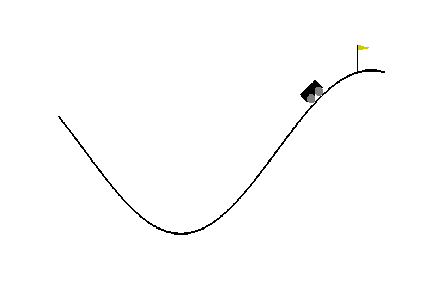
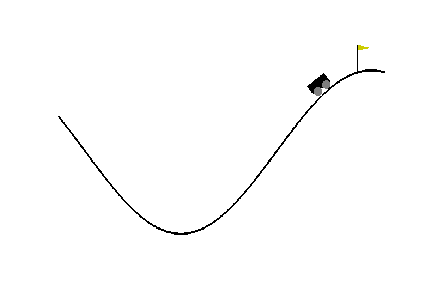
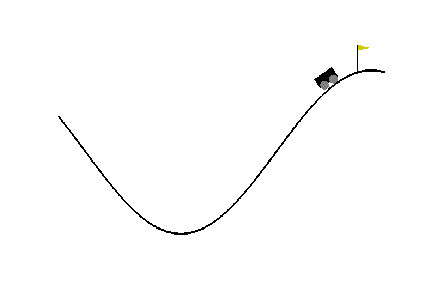
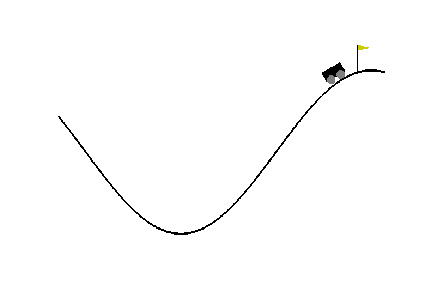
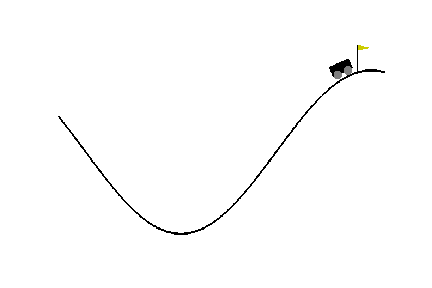
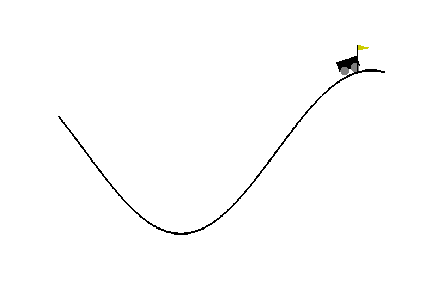

In [24]:
env = gym.make('MountainCarContinuous-v0')
obs = env.reset()
total_reward = 0
frames = []
for t in range(10000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    obs = obs.astype(np.float32).reshape((1, -1))
    action = agent.control(obs).reshape((1, -1)).astype(np.float32)
    obs, reward, done, info = env.step(action)
    total_reward += reward
    if done:
        break
env.close()
print('Total Reward : %.2f'%total_reward)
display_frames_as_gif(frames)